# Trabajo Práctico N°2 Aprendizaje Automático 1
## Integrantes ##
1. López Ceratto, Julieta : L-3311/1
2. Rodríguez Griñó, Tomás : R-4643/4
3. Slepoy, David: S-5782/7

Importamos librerías necesarias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import optuna
from scipy.stats import randint
import warnings
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings("ignore")

# Funciones a usar

In [2]:
def recall_2_clases(y_real,y_pred, **kwargs)->float:
    recall_1 = recall_score(y_true= y_real, y_pred= y_pred, pos_label=1)
    recall_0 = recall_score(y_true= y_real, y_pred= y_pred, pos_label=0)
    recall_conjunto = 0.7*recall_1 + 0.3 * recall_0
    return recall_conjunto

In [3]:
def metricas(dict_modelo:dict, model)-> pd.DataFrame:
    df_metricas = pd.DataFrame()
    for key, value in dict_modelo.items():
        dict_metricas = {
            'Nombre Modelo': key
            }
        x_list = value[0]
        for i in range (1, len(value)):
            if i == 1:
                type = 'Train'
            elif i == 2:
                type = 'Val'
            else:
                type = 'Test'
            y_real,y_pred = value[i]
            x = x_list[i-1]
            dict_metricas[f'Accuracy {type}'] = accuracy_score(y_real, y_pred),
            dict_metricas[f'Recall 2 clases {type}'] = recall_2_clases(y_real, y_pred),
            dict_metricas[f'Precision Llueve {type}'] =precision_score(y_real, y_pred, pos_label=1),
            dict_metricas[f'Recall Llueve {type}'] = recall_score(y_real, y_pred, pos_label=1),
            dict_metricas[f'F1-Score Llueve {type}'] = f1_score(y_real, y_pred, pos_label=1),
            if model:
                dict_metricas[f'AUC-ROC Llueve {type}'] = roc_auc_score(y_real, model.predict_proba(x)[:, 1]),
            dict_metricas[f'Precision No Llueve {type}'] =precision_score(y_real, y_pred, pos_label=0),
            dict_metricas[f'Recall No Llueve {type}'] = recall_score(y_real, y_pred, pos_label=0),
            dict_metricas[f'F1-Score No Llueve {type}'] = f1_score(y_real, y_pred, pos_label=0),
            if model:
                dict_metricas[f'AUC-ROC No Llueve {type}'] = 1- roc_auc_score(y_real, model.predict_proba(x)[:, 1]),
    # Concatenar el DataFrame de métricas
    df_metricas = pd.concat([df_metricas, pd.DataFrame(dict_metricas, index=[key])])
    return df_metricas
                             

In [4]:
def plot_trials(trial: dict, optim: str, tipo: str):
    param_names = ['C', 'penalty', 'max_iter', 'class_weight']
    params = []
    score = []
    iterations = []
    
    for i in range(len(trial)):
        if tipo == 'optuna':
            params.append(trial[i].params)       # Guarda los parámetros de cada iteración
            score.append(trial[i].values[0])     # Guarda el score de cada iteración
            iterations.append(i)                 # Guarda el número de iteración
        else:
            param_trial = {}
            for p in param_names:
                param_trial[p] = trial[f'param_{p}'][i]        # Guarda cada parámetro del trial actual
            score.append(trial['mean_test_score'][i])
            params.append(param_trial)
            iterations.append(i)                 # Guarda el número de iteración para 'random'
            
    # Crear DataFrame con columnas 'Iteration', 'Params' y f'{optim} Score'
    data_trial_score = pd.DataFrame({'Iteration': iterations, 'Params': params, f'{optim} Score': score})
    # Configurar la figura para el gráfico
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Iteration', y=f'{optim} Score', data=data_trial_score)
    plt.xlabel('Iteration')
    plt.xticks(range(0, len(trial), 1))
    plt.ylabel(f'{optim} Score')
    plt.title('Trial Scores')
    plt.tight_layout()
    plt.show()
    
    # Configurar pandas para mostrar el contenido completo de 'Params'
    with pd.option_context('display.max_colwidth', None):
        display(data_trial_score)

In [5]:
def plot_params_trials(trial, tipo : str = 'notOptuna'):

    if tipo == 'notOptuna':
        # Extraer los valores de los hiperparámetros y el F1-score
        param_penalty = trial['param_penalty']
        param_max_iter = trial['param_max_iter']
        param_class_weight = trial['param_class_weight']
        param_C = trial['param_C']
        f1_scores = trial['mean_test_score']

    else:
        # Extraer los valores de los hiperparámetros y el F1-score
        param_C = [t.params['C'] for t in trial]
        param_penalty = [t.params['penalty'] for t in trial]
        param_class_weight = [t.params['class_weight'] for t in trial]
        param_max_iter = [t.params['max_iter'] for t in trial]
        f1_scores = [t.value for t in trial]

    # Graficar los resultados
    plt.figure(figsize=(15, 10))

    # Gráfica para param_penalty
    plt.subplot(2, 2, 1)
    plt.plot(range(len(param_penalty)), param_penalty, marker='o')
    plt.title('Penalidad por Iteración')
    plt.xlabel('Iteración')
    plt.ylabel('Penalidad')

    # Gráfica para param_max_iter
    plt.subplot(2, 2, 2)
    plt.plot(range(len(param_max_iter)), param_max_iter, marker='o')
    plt.title('Máximas iteraciones por Iteración')
    plt.xlabel('Iteración')
    plt.ylabel('param_max_iter')

    # Gráfica para param_C
    plt.subplot(2, 2, 4)
    plt.plot(range(len(param_C)), param_C, marker='o')
    plt.title('C por Iteración')
    plt.xlabel('Iteración')
    plt.ylabel('C')

    # Gráfica para class_weight
    plt.subplot(2, 2, 4)
    sns.histplot(x = range(len(param_class_weight)), y = param_class_weight)
    plt.title('Class Weight por iteración')
    plt.xlabel('Iteración')
    plt.ylabel('class_weight')

    plt.tight_layout()
    plt.show()

# PUNTO 1


In [6]:
old_df = pd.read_csv('src\weatherAUS.csv', sep = ',')

In [7]:
old_df[old_df['Location'] == "Williamtown"].iloc[0]

Date              2009-01-01
Location         Williamtown
MinTemp                 15.2
MaxTemp                 34.0
Rainfall                 0.0
Evaporation             11.6
Sunshine                 9.2
WindGustDir               NW
WindGustSpeed           41.0
WindDir9am               WNW
WindDir3pm                SE
WindSpeed9am            17.0
WindSpeed3pm            20.0
Humidity9am             62.0
Humidity3pm             36.0
Pressure9am           1005.2
Pressure3pm           1001.5
Cloud9am                 3.0
Cloud3pm                 6.0
Temp9am                 23.7
Temp3pm                 28.7
RainToday                 No
RainTomorrow              No
Name: 39538, dtype: object

In [8]:
old_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  
145459     20.9         No           NaN  

[145460 rows x 23 columns]

1- Date: La fecha en la que se registró.

2- Location: La ciudad en Australia.

3- MinTemp: Temperatura mínima registrada ese día (en grados).

4- MaxTemp: Temperatura máxima registrada ese día (en grados).

5- Rainfall: Cantidad de lluvia registrada ese día (en mm).

6- Evaporation: Cantidad de agua evaporada ese día (en mm).

7- Sunshine: Número de horas de sol.

8- WindGustDir: Dirección del viento durante la ráfaga más fuerte.

9- WindGustSpeed: Velocidad de la ráfaga de viento más fuerte (en km/h).

10- WindDir9am: Dirección del viento a las 9 de la mañana.

11- WindDir3pm: Dirección del viento a las 3 de la tarde.

12- WindSpeed9am: Velocidad del viento a las 9 de la mañana (en km/h).

13- WindSpeed3pm: Velocidad del viento a las 3 de la tarde (en km/h).

14- Humidity9am: Porcentaje de humedad relativa a las 9 de la mañana (en %).

15- Humidity3pm: Porcentaje de humedad relativa a las 3 de la tarde (en %).

16- Pressure9am: Presión atmosférica a las 9 de la mañana (en hPa).

17- Pressure3pm: Presión atmosférica a las 3 de la tarde (en hPa).

18- Cloud9am: Cobertura de nubes a las 9 de la mañana (en oktas, de 0 a 8).

19- Cloud3pm: Cobertura de nubes a las 3 de la tarde (en oktas, de 0 a 8).

20- Temp9am: Temperatura a las 9 de la mañana (en grados).

21- Temp3pm: Temperatura a las 3 de la tarde (en grados).

22- RainToday: Indica si llovió hoy.

23- RainTomorrow: Variable objetivo que indica si lloverá al día siguiente.


Realizamos una linea de codigo en la cual se eligen 10 ciudades aleatorias. Con estas mismas se trabajara en todo el trabajo practico

In [9]:
unique_locations = old_df['Location'].unique()

# Seleccionmos aleatoriamente 10 ciudades
selected_cities = pd.Series(unique_locations).sample(n=10, random_state=42).tolist()

# Filtrmos el DataFrame para quedarnos solo con las ciudades seleccionadas
df = old_df[old_df['Location'].isin(selected_cities)]

# Mostrmos las 10 ciudades con las que nos quedamos
cities = df['Location'].unique()
for city in cities:
    print(city)

Williamtown
MountGinini
Bendigo
Portland
Watsonia
Dartmoor
Townsville
Launceston
AliceSprings
Katherine


## Datos Faltantes

In [10]:
df.isnull().sum()


Date                 0
Location             0
MinTemp            238
MaxTemp            174
Rainfall           730
Evaporation      10077
Sunshine         14182
WindGustDir        774
WindGustSpeed      771
WindDir9am        2263
WindDir3pm         510
WindSpeed9am       320
WindSpeed3pm       316
Humidity9am        832
Humidity3pm       1409
Pressure9am       4300
Pressure3pm       4297
Cloud9am         10895
Cloud3pm         11650
Temp9am            602
Temp3pm           1111
RainToday          730
RainTomorrow       731
dtype: int64

## Eliminamos las filas donde los datos faltantes son null en la variable a predecir

In [11]:
df['RainTomorrow'].isnull().sum() / len(df)

0.0253696119941695

In [12]:
df = df.dropna(subset=['RainTomorrow'])

In [13]:
df.columns


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Agregamos columnas 'Dia-del-año', 'Mes' y "Estación"
Estas columnas corresponden al día, mes y estación del año, se utilizará mas adelante

In [14]:
#Primero convertimos el tipo de dato de Date a fecha
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
df['Date']

39538    2009-01-01
39539    2009-01-02
39540    2009-01-03
39541    2009-01-04
39542    2009-01-05
            ...    
143875   2017-06-19
143876   2017-06-20
143877   2017-06-21
143878   2017-06-22
143879   2017-06-23
Name: Date, Length: 28083, dtype: datetime64[ns]

In [16]:
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month

In [17]:
df['Day_of_Year'] 

39538       1
39539       2
39540       3
39541       4
39542       5
         ... 
143875    170
143876    171
143877    172
143878    173
143879    174
Name: Day_of_Year, Length: 28083, dtype: int32

Chequeamos que se hayan hecho bien las divisiones

In [18]:
def obtener_estacion(mes):
    '''
    Esta función devuelve una estación dado un mes.
    '''
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    elif mes in [9, 10, 11]:
        return 'Primavera'
    
df['Season'] = df['Month'].apply(obtener_estacion)

In [19]:
df['Season'].unique()

array(['Verano', 'Otoño', 'Invierno', 'Primavera'], dtype=object)

## Division del conjunto de datos 

In [20]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Day_of_Year', 'Month',
       'Season'],
      dtype='object')

In [21]:
# Definimos X e y
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow']

Quitamos Date del conjunto ya que no es necesaria

In [22]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.3, random_state= 41, shuffle=False)

### Datos faltantes ###

In [23]:
X_train.isnull().sum()

Location            0
MinTemp            80
MaxTemp            19
Rainfall          294
Evaporation      5941
Sunshine         7593
WindGustDir       404
WindGustSpeed     403
WindDir9am       1002
WindDir3pm        288
WindSpeed9am      193
WindSpeed3pm      175
Humidity9am       456
Humidity3pm       272
Pressure9am      2944
Pressure3pm      2937
Cloud9am         5975
Cloud3pm         5941
Temp9am           431
Temp3pm           250
RainToday         294
Day_of_Year         0
Month               0
Season              0
dtype: int64

Podemos ver que en varias columnas hay datos faltantes.


Primero vemos que no haya columnas duplicadas.


In [24]:
X_train.duplicated().sum()

0

## Imputación de datos faltantes ##


Los valores nulos tendremos que tratarlos de columna en columna

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15726 entries, 39538 to 82297
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       15726 non-null  object 
 1   MinTemp        15646 non-null  float64
 2   MaxTemp        15707 non-null  float64
 3   Rainfall       15432 non-null  float64
 4   Evaporation    9785 non-null   float64
 5   Sunshine       8133 non-null   float64
 6   WindGustDir    15322 non-null  object 
 7   WindGustSpeed  15323 non-null  float64
 8   WindDir9am     14724 non-null  object 
 9   WindDir3pm     15438 non-null  object 
 10  WindSpeed9am   15533 non-null  float64
 11  WindSpeed3pm   15551 non-null  float64
 12  Humidity9am    15270 non-null  float64
 13  Humidity3pm    15454 non-null  float64
 14  Pressure9am    12782 non-null  float64
 15  Pressure3pm    12789 non-null  float64
 16  Cloud9am       9751 non-null   float64
 17  Cloud3pm       9785 non-null   float64
 18  Temp9am

### Obtenemos media y moda para los datos segun el mes

In [26]:
# Función para aplicar mediana a columnas numéricas y moda a las no numéricas
def mediana_moda(grupo):
    '''
    Obtiene la mediana y moda según el tipo de dato, dado
    un grupo específico de datos.
    '''
    # Para las columnas numéricas aplicamos la mediana
    numericas = grupo.select_dtypes(include='number').median()
    
    # Para las columnas no numéricas aplicamos la moda
    no_numericas = grupo.select_dtypes(exclude='number').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Combinar resultados
    return pd.concat([numericas, no_numericas])

In [27]:
## Obtenemos mediana y moda según la columna por mes para el conjunto Train
medianas = X_train.groupby('Month').apply(mediana_moda)

### Guardado de imputers 

In [28]:
import pickle

In [29]:
# Guardar los valores de imputación en un archivo
medianas.to_csv("Docker\imputers.csv", index = True)

In [30]:
medianas

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
Month                                                                     
1         13.9    25.60       0.0          7.2      10.1           41.0   
2         13.9    25.50       0.0          6.0       9.0           39.0   
3         12.3    23.20       0.0          4.6       7.7           37.0   
4          9.7    19.50       0.0          3.0       6.1           35.0   
5          7.1    15.90       0.2          1.6       4.5           35.0   
6          5.1    13.90       0.2          1.2       4.3           35.0   
7          5.3    13.15       0.4          1.4       4.5           39.0   
8          5.5    14.00       0.2          2.2       6.0           41.0   
9          6.7    16.00       0.0          3.0       6.9           43.0   
10         8.2    18.60       0.0          4.0       7.8           41.0   
11        10.8    21.80       0.0          5.4       8.3           41.0   
12        11.7    23.35       0.0          6.0       9.6           41.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Temp9am  \
Month                                                        ...            
1              13.0          19.0         67.0         49.0  ...     17.9   
2              13.0          17.0         74.0         51.0  ...     17.4   
3              11.0          17.0         80.0         54.0  ...     15.6   
4              11.0          15.0         80.0         59.0  ...     14.0   
5              13.0          15.0         87.0         64.0  ...     10.9   
6              11.0          15.0         92.0         70.0  ...      8.6   
7              13.0          17.0         91.0         70.0  ...      8.4   
8              15.0          19.0         83.0         63.0  ...      9.4   
9              15.0          19.0         73.0         57.0  ...     11.4   
10             15.0          20.0         71.0         53.0  ...     12.4   
11             15.0          19.0         69.0         54.0  ...     15.1   
12             15.0          19.0         67.0         50.0  ...     16.4   

       Temp3pm  Day_of_Year  Month  Location  WindGustDir  WindDir9am  \
Month                                                                   
1         23.6         16.0    1.0   Bendigo          SSW          SE   
2         23.7         46.0    2.0  Watsonia          SSE         SSE   
3         21.7         75.0    3.0   Bendigo            W          SE   
4         18.2        106.0    4.0   Bendigo          SSE         WNW   
5         14.9        136.0    5.0  Portland          WNW         WNW   
6         12.9        166.0    6.0   Bendigo            N         WNW   
7         12.3        197.0    7.0   Bendigo            N           N   
8         12.9        228.0    8.0   Bendigo            W         WNW   
9         14.6        259.0    9.0   Bendigo          WNW           W   
10        17.2        289.0   10.0   Bendigo            W           W   
11        20.0        320.0   11.0   Bendigo            W         WSW   
12        21.6        350.0   12.0   Bendigo            W         SSE   

       WindDir3pm RainToday     Season  
Month                                   
1              SW        No     Verano  
2              SE        No     Verano  
3               W        No      Otoño  
4             SSW        No      Otoño  
5               W        No      Otoño  
6             WNW        No   Invierno  
7               N        No   Invierno  
8               W        No   Invierno  
9             WNW        No  Primavera  
10              W        No  Primavera  
11              W        No  Primavera  
12              W        No     Verano  

[12 rows x 24 columns]

### Llenamos datos faltantes segun el valor de mediana o moda que le corresponda al mes

In [31]:
def llenar_faltantes_por_mes(fila, df_mediana_moda):
    '''
    Dado una fila y los valores de media y moda para cada columna y mes,
    llena los datos faltantes de dicha fila
    '''
    mes = fila['Month']
    
    # Iterar sobre las columnas del DataFrame
    for columna in fila.index:
        # Si el valor es nulo, llenarlo con la mediana o moda del mes
        if pd.isnull(fila[columna]):
            if columna in df_mediana_moda.columns:
                fila[columna] = df_mediana_moda.loc[mes, columna]  # Usar la mediana o moda según el tipo
    return fila

In [32]:
### Rellenemos los datos faltantes de todos los conjuntos
### según los valores de mediana y moda por mes y columna
### obtenidos para el conjunto Train.
X_train = X_train.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_val = X_val.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)
X_test = X_test.apply(lambda fila: llenar_faltantes_por_mes(fila, medianas), axis=1)

In [33]:
### Quitamos las columnas categóricas mes y season 
### agregadas al principio ya que no serán necesarias posteriormente.
X_train.drop(columns= ['Month', 'Season'], inplace = True)
X_val.drop(columns= ['Month', 'Season'], inplace = True)
X_test.drop(columns= ['Month', 'Season'], inplace = True)

In [34]:
X_train.describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  15726.000000  15726.000000  15726.000000  15726.000000  15726.000000   
mean       8.859507     19.213710      2.448601      4.208495      6.771951   
std        5.605542      7.644137      7.426015      3.592641      3.102910   
min       -8.500000     -4.800000      0.000000      0.000000      0.000000   
25%        5.300000     14.300000      0.000000      1.800000      4.500000   
50%        8.900000     18.500000      0.000000      3.600000      6.900000   
75%       12.600000     24.000000      1.400000      6.000000      9.000000   
max       29.000000     46.700000    225.000000    145.000000     14.300000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Humidity9am   Humidity3pm  \
count   15726.000000  15726.000000  15726.000000  15726.000000  15726.000000   
mean       41.136271     14.017614     18.129340     76.250604     58.449002   
std        14.263745      8.123601      8.398769     18.161847     20.693571   
min         9.000000      0.000000      0.000000      5.000000      3.000000   
25%        31.000000      9.000000     13.000000     64.000000     44.000000   
50%        39.000000     13.000000     17.000000     78.000000     58.000000   
75%        48.000000     19.000000     22.000000     92.000000     72.000000   
max       113.000000     61.000000     72.000000    100.000000    100.000000   

        Pressure9am   Pressure3pm      Cloud9am      Cloud3pm       Temp9am  \
count  15726.000000  15726.000000  15726.000000  15726.000000  15726.000000   
mean    1018.091619   1016.224812      5.729620      5.549281     13.146477   
std        6.936871      6.812418      2.296778      2.136656      6.002481   
min      986.700000    985.500000      0.000000      0.000000     -7.200000   
25%     1013.900000   1012.200000      6.000000      5.000000      9.500000   
50%     1018.200000   1016.600000      7.000000      6.000000     13.000000   
75%     1022.300000   1020.400000      7.000000      7.000000     16.900000   
max     1039.300000   1037.300000      8.000000      8.000000     36.400000   

            Temp3pm   Day_of_Year  
count  15726.000000  15726.000000  
mean      17.834631    178.762622  
std        7.397860    104.834056  
min       -5.400000      1.000000  
25%       13.200000     88.000000  
50%       17.200000    175.000000  
75%       22.500000    269.000000  
max       45.200000    366.000000

No se utilizó KNN vecinos ya que tiene un costo computacional muy alto.

Se eligió tratar de llenar el valor faltante de forma más adecuada posible, esto lo inferimos obteniendo la mediana o moda -según la columna- para cada mes.
El uso del mes como criterio de agrupación ayuda a capturar los patrones estacionales que pueden estar presentes en los datos climáticos.

En datos de clima, por ejemplo, las temperaturas de enero podrían ser muy diferentes a las de julio, por lo que rellenar con la mediana o moda general (sin considerar el mes) no reflejaría adecuadamente las diferencias estacionales; agrupar por mes y reemplazar según ese grupo permite que los valores faltantes se llenen con algo que es más representativo del contexto temporal del dato faltante.

Se evita así también rellenar con datos "atípicos" para un mes o estación del año en particular.

Reemplazar los valores faltantes por la mediana o moda por mes es una técnica que ayuda a preservar la integridad estacional de los datos y a minimizar el impacto de valores extremos.

Criterio explicado segun variable:

- MintTemp y MaxTemp : Se eligio reemplazar los valores nulos por la mediana a pesar de que la distribución no sea muy asimétrica.
- Rainfall : Se eligio reemplazar los valores nulos por la mediana ya que es menos sensible a valores extremos.
- Evaporation y Sunshine: Aunque pueden tener cierta asimetría, la media sigue siendo una buena estimación del valor típico. Tambien porque la evaporación y las horas de sol suelen tener una variación más gradual que la lluvia.
- WindGustDir, WindDir9am y WindDir3pm: Se eligio reemplazar los valores nulos por la moda ya que la moda representa la dirección del viento más común, que es una buena estimación para valores faltantes.
- WindGustSpeed y WindSpeed9am, WindSpeed3pm: Se eligio reeemplazar por la mediana ya que la velocidad del viento puede tener una distribución sesgada, similar a la lluvia. Y la mediana es menos afectada por valores extremos ocasionales de vientos fuertes.
- Humidity9am y Humidity3pm: Se eligio reemplazar por la mediana a pesar que la humedad suele tener una distribución más simétrica que la lluvia o el viento. Y la mediana proporciona una buena estimación del nivel de humedad típico.
- Pressure9am y Pressure3pm: Se eligio reemplazar por la media porque la presión atmosférica tiende a tener una distribución bastante simétrica y los cambios en la presión suelen ser graduales, haciendo de la media una buena representación.
- Cloud9am y Cloud3pm: Se eligio reemplazar por la mediana pues la nubosidad se mide en una escala discreta (octavos), y la mediana proporciona un valor central que es un número entero en la escala de nubosidad.
- Temp9am y Temp3pm: Se eligio reemplazar por la media pues, similarmente a MinTemp y MaxTemp, las temperaturas suelen seguir una distribución aproximadamente normal.
- RainToday : Se eligio la reemplazar por la moda porque es una variable categórica binaria (Sí/No), y la moda representa el resultado más frecuente, que es una buena estimación para un evento binario.

Verificamos que ya no haya valores nulos.

In [35]:
X_train.isnull().any()

Location         False
MinTemp          False
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustDir      False
WindGustSpeed    False
WindDir9am       False
WindDir3pm       False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday        False
Day_of_Year      False
dtype: bool

## Visualización de datos ##

Visualizamos los datos por categoría y localización.

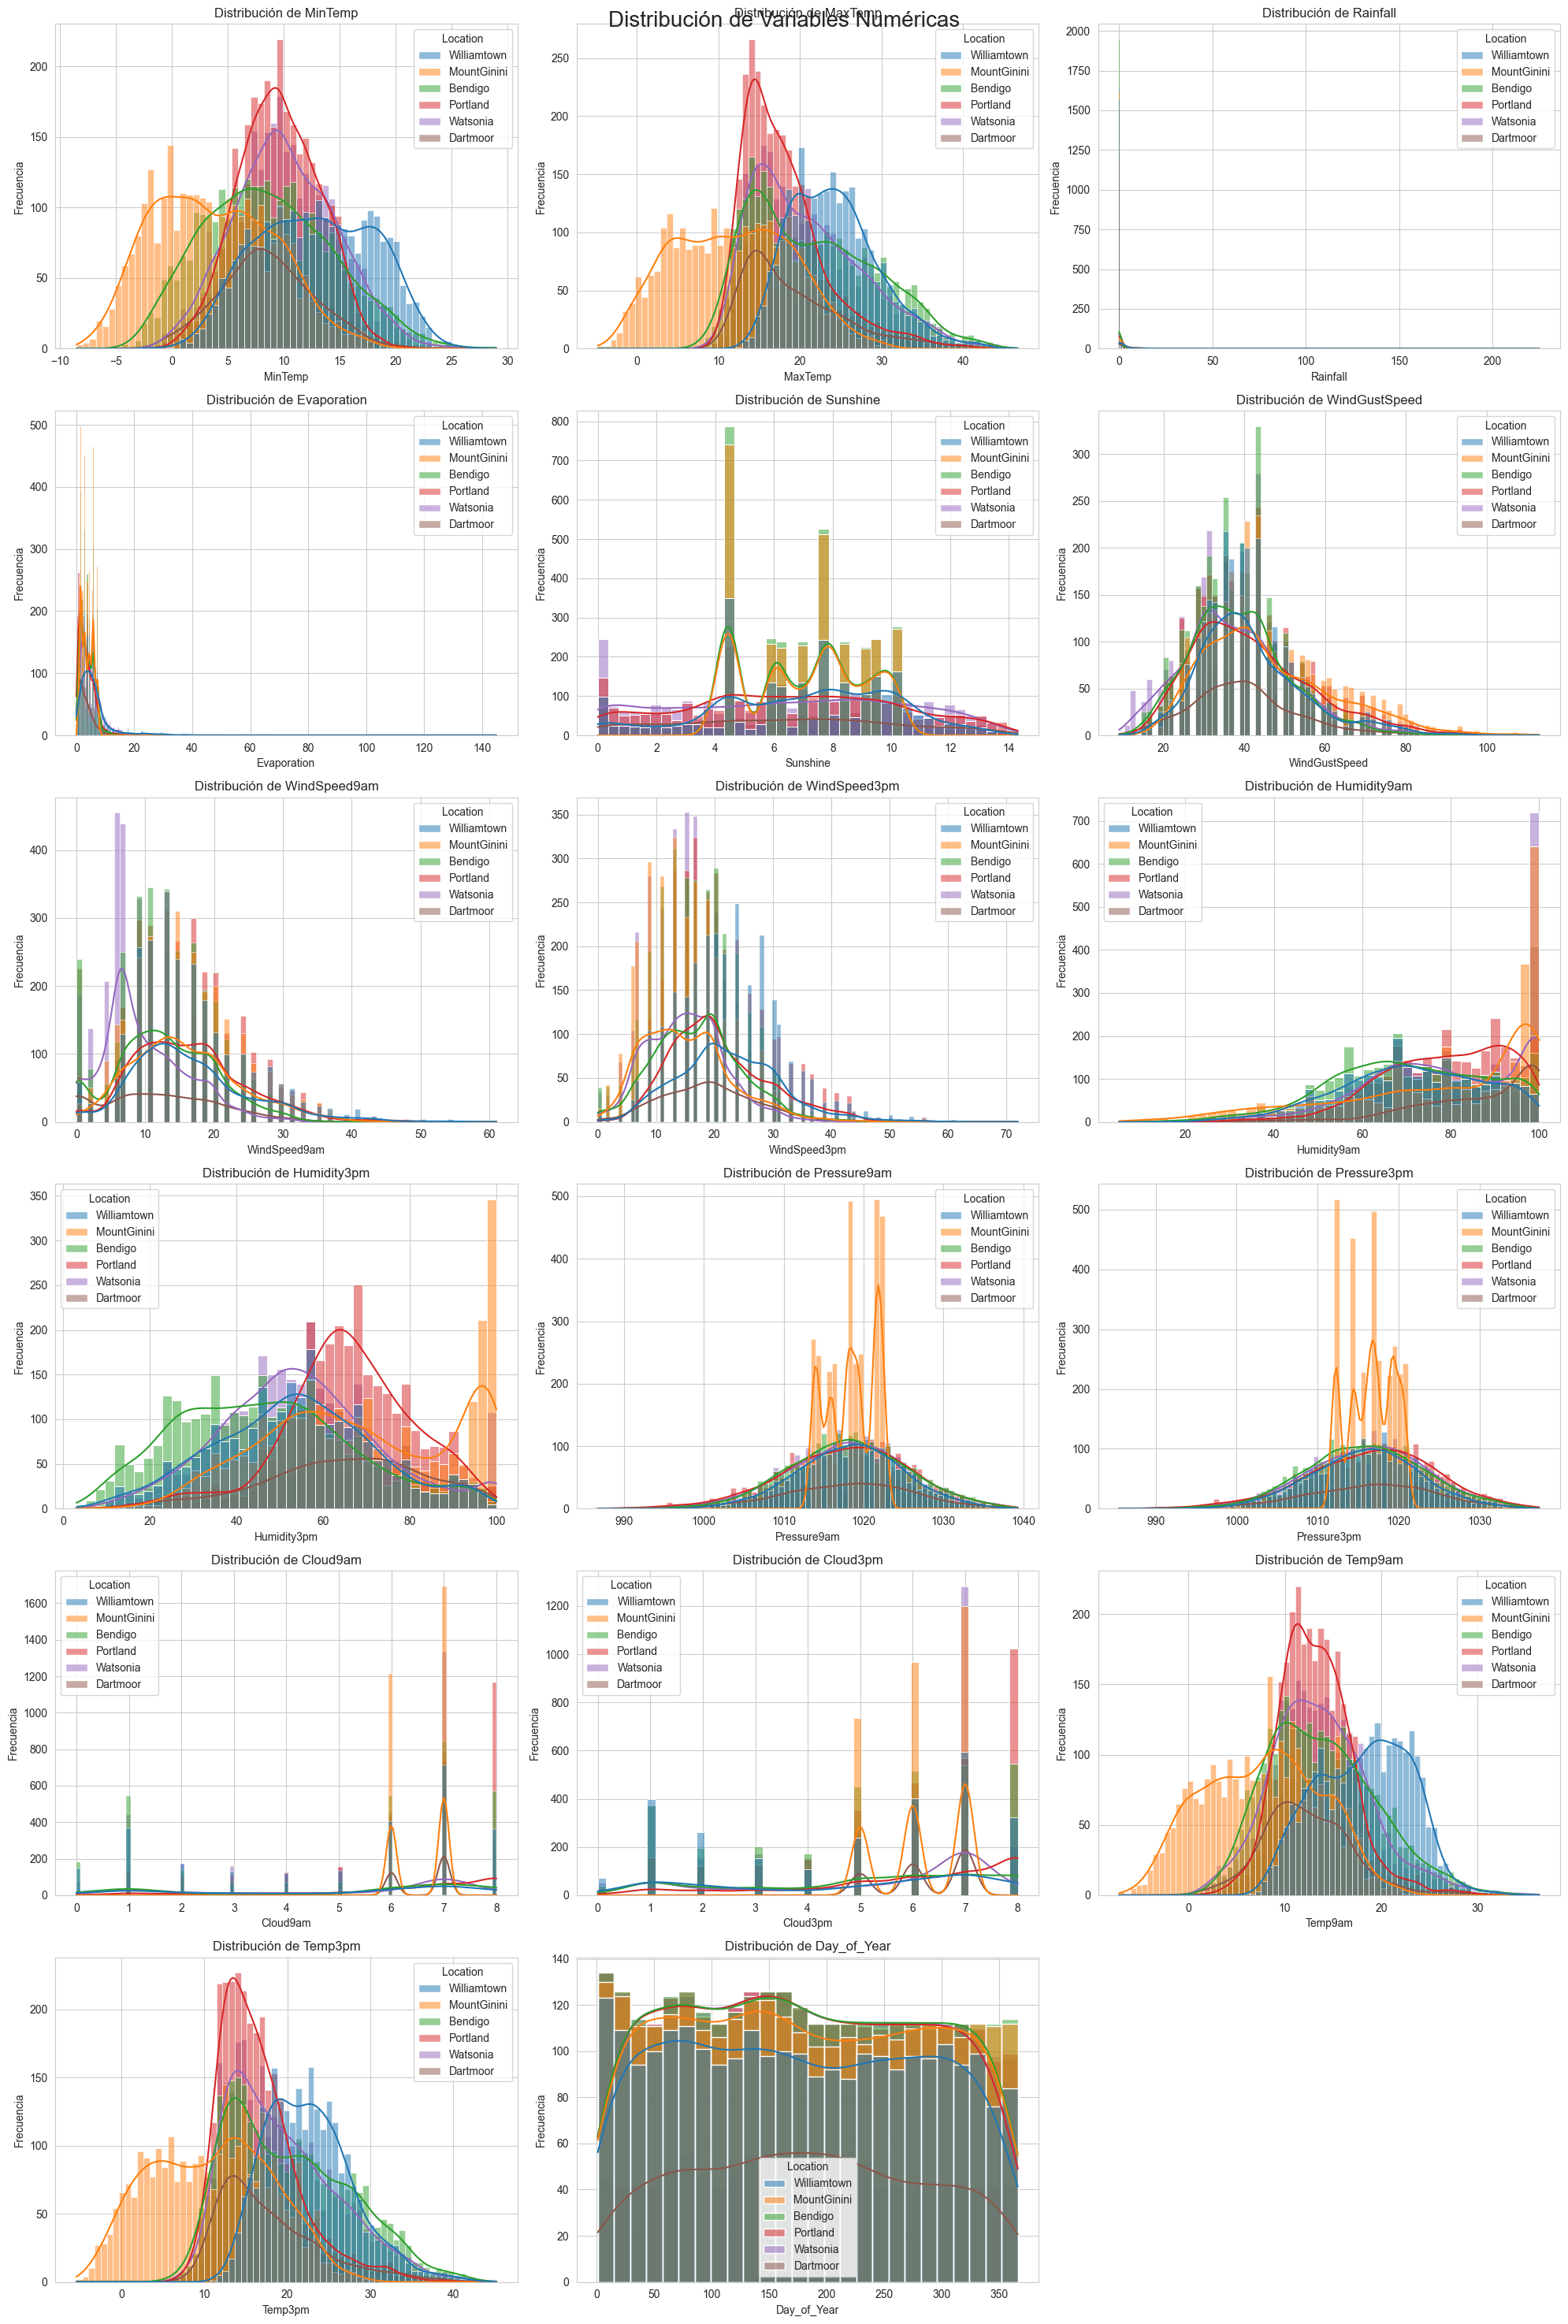

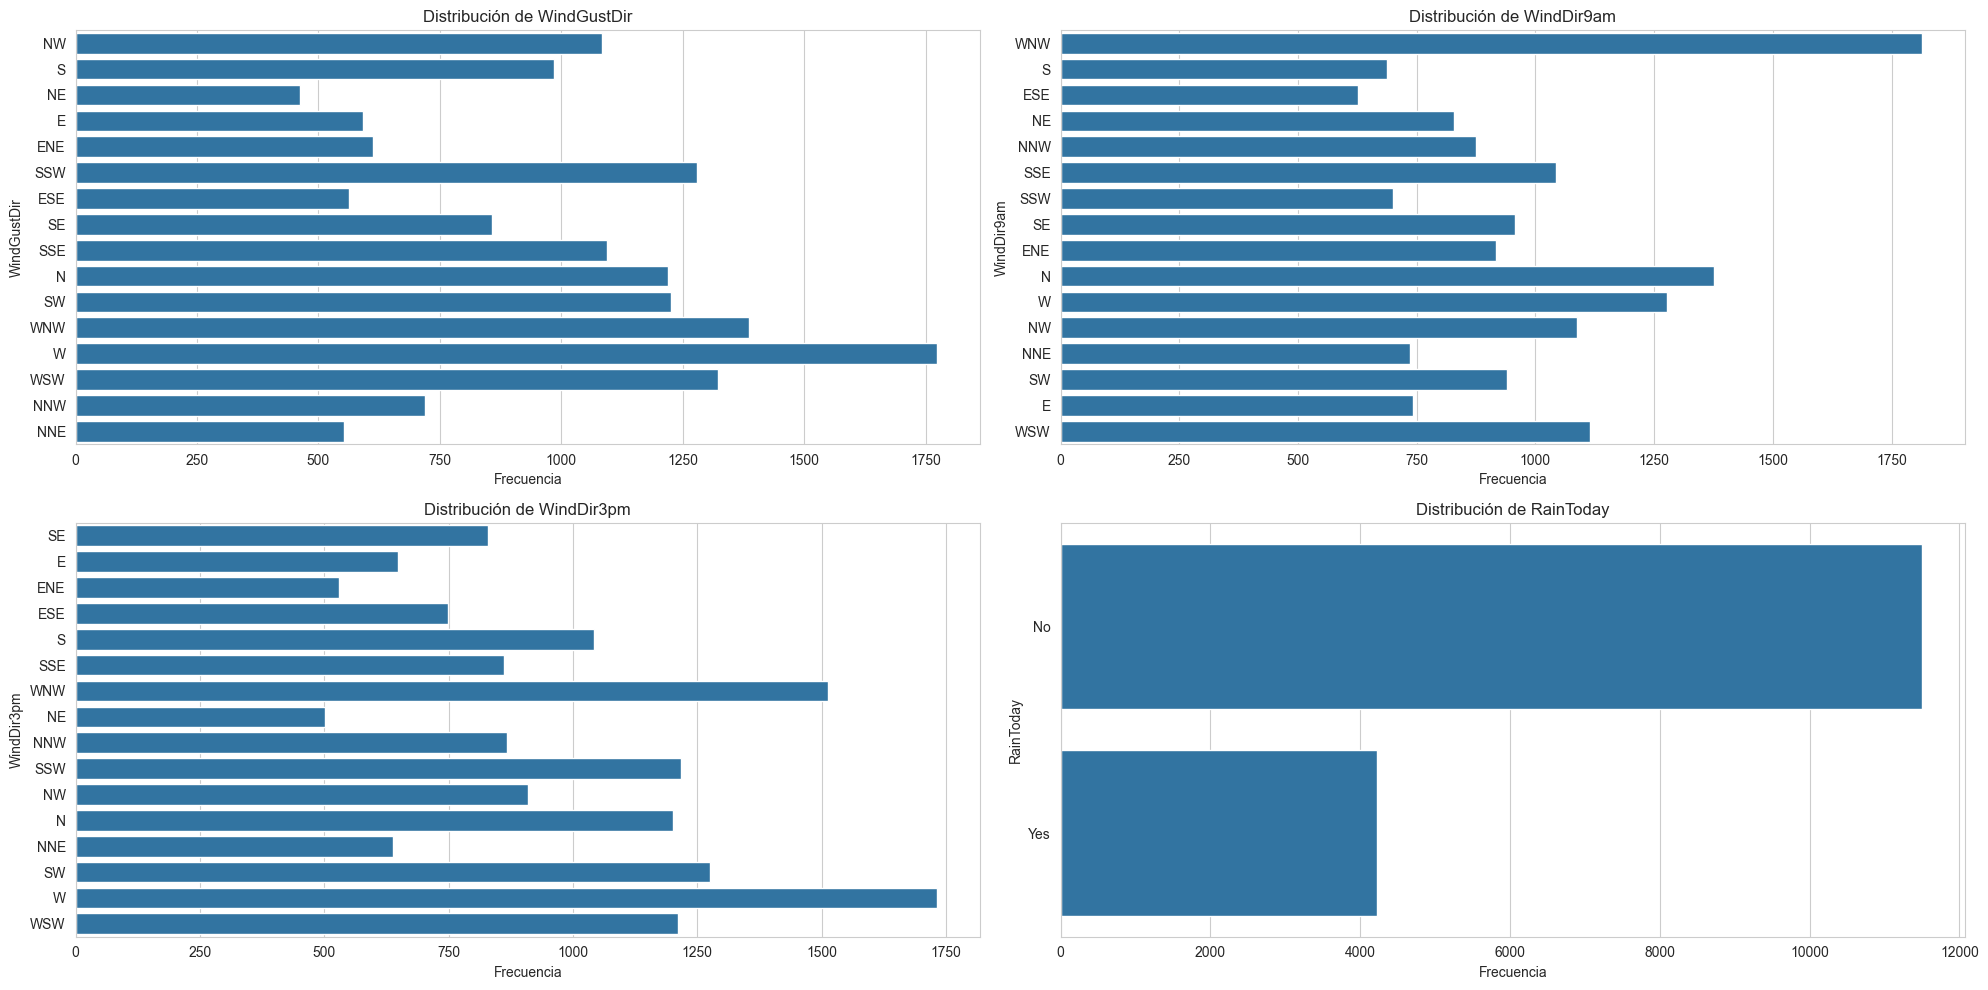

In [36]:
# Seleccionmos solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Configurmos el estilo de seaborn
sns.set_style("whitegrid")

# Calculmos el número de filas y columnas para el subplot
n_cols = 3 
n_rows = math.ceil(len(numeric_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Distribución de Variables Numéricas', fontsize=20)

# Aplanmos el array de axes si es necesario
axes = axes.flatten() if n_rows > 1 else [axes]

# Creamos un histograma para cada variable numérica
for i, column in enumerate(numeric_columns):
    sns.histplot(X_train, x=column, kde=True, ax=axes[i], hue=X_train['Location'])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].set_ylabel('Frecuencia', fontsize=10)

# Quitamos subplots vacíos
for i in range(len(numeric_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Para  las variables categóricas, excluyendo 'Date' y 'Location'
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col not in ['Date', 'Location']]

# Calculmosel número de filas y columnas para el subplot de variables categóricas
n_cols_cat = 2  # Puedes ajustar esto según prefieras
n_rows_cat = math.ceil(len(categorical_columns) / n_cols_cat)

fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(20, 5*n_rows_cat))

# Aplanmos el array de axes si es necesario
axes = axes.flatten() if n_rows_cat > 1 else [axes]

# Creamos un gráfico de barras para cada variable categórica
for i, column in enumerate(categorical_columns):
    sns.countplot(y=column, data=X_train, ax=axes[i])
    axes[i].set_title(f'Distribución de {column}', fontsize=12)
    axes[i].set_xlabel('Frecuencia', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)

# Quitamos subplots vacíos
for i in range(len(categorical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


Vemos que la variable 'Location' es importante en el modelo ya que influye en casi todas las demás variables; por lo tanto, no es una opción quitarla.

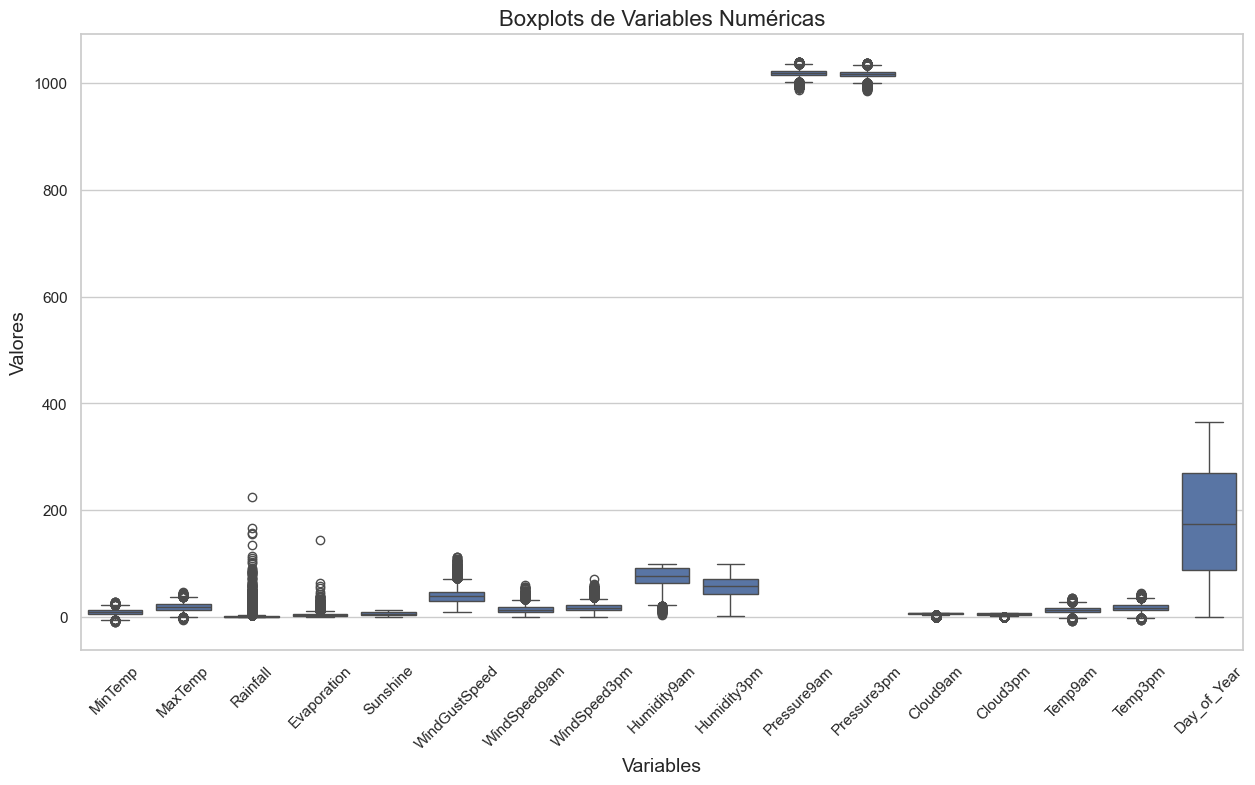

In [37]:
# Seleccionamos solo las columnas numéricas
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Transformamos el DataFrame a formato largo
X_train_melted = pd.melt(X_train, value_vars=numeric_columns)

# Configuramos el estilo de seaborn
sns.set(style="whitegrid")

# Cremos boxplots para todas las columnas numéricas en un solo gráfico
plt.figure(figsize=(15, 8))
sns.boxplot(x='variable', y='value', data=X_train_melted)
plt.title('Boxplots de Variables Numéricas', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(rotation=45)  # Rota etiquetas del eje x para mejor legibilidad
plt.show()

### Descripcion de variables ###

1. MinTemp: Al ser la temperatura mínima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, ligeramente sesgada a la izquierda. La moda parece estar alrededor de los 10-15°C. Aunque no tenemos un boxplot, es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o cálidos.

2. MaxTemp: Al ser la temperatura máxima diaria en grados Celsius, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución aproximadamente normal, posiblemente con un ligero sesgo a la derecha. La moda parece estar alrededor de los 20-25°C. Es probable que haya valores atípicos en el extremo superior, representando días excepcionalmente calurosos.

3. Rainfall: Al ser la cantidad de lluvia registrada en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución fuertemente sesgada a la derecha, con una moda muy pronunciada en o cerca de 0 mm. La distribución tiene una cola larga hacia la derecha, indicando días ocasionales de lluvia intensa. Es muy probable que haya numerosos valores atípicos en el extremo superior de la distribución.

4. Evaporation: Al ser la evaporación en las últimas 24 horas (mm), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores concentrados en el rango inferior. La moda parece estar cerca de 2-4 mm. Es probable que haya valores atípicos en el extremo superior, representando días con evaporación excepcionalmente alta.

5. Sunshine: Al ser el número de horas de sol brillante en el día, podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución que podría ser bimodal o uniforme, reflejando la variación estacional en las horas de luz diurna. La distribución probablemente abarca desde 0 hasta 12-14 horas, con picos que podrían corresponder a los patrones de invierno y verano.

6. WindGustSpeed: Al ser la velocidad de la ráfaga de viento más fuerte en las últimas 24 horas (km/h), podemos observar que es una variable cuantitativa, continua. Podemos ver que tiene una distribución sesgada a la derecha, con la mayoría de los valores en el rango bajo a medio. La moda parece estar alrededor de 30-40 km/h. Es probable que haya valores atípicos en el extremo superior, representando ráfagas de viento excepcionalmente fuertes.

7. WindSpeed9am y WindSpeed3pm: Al ser la velocidad del viento a las 9 am y 3 pm respectivamente (km/h), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones sesgadas a la derecha, similares a WindGustSpeed pero con valores generalmente más bajos. Las modas probablemente están en el rango de 10-20 km/h. Es probable que haya valores atípicos en los extremos superiores.

8. Humidity9am y Humidity3pm: Al ser el porcentaje de humedad a las 9 am y 3 pm respectivamente, podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones que podrían ser bimodales o uniformes, abarcando un rango amplio de valores. Las modas podrían estar alrededor del 60-70% y 40-50% respectivamente. Es menos probable que haya valores atípicos extremos debido a la naturaleza limitada de la escala de porcentaje.

9. Pressure9am y Pressure3pm: Al ser la presión atmosférica a las 9 am y 3 pm respectivamente (hpa), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, centradas alrededor de 1010-1020 hpa. La variación es relativamente pequeña, reflejando la estabilidad general de la presión atmosférica. Es posible que haya algunos valores atípicos en ambos extremos, representando condiciones atmosféricas inusuales.

10. Cloud9am y Cloud3pm: Al ser la fracción de cielo cubierto por nubes a las 9 am y 3 pm respectivamente (octavos), podemos observar que son variables cuantitativas discretas. Las distribuciones probablemente muestran picos en valores específicos (0, 4, 8 octavos), reflejando la naturaleza discreta de la medición. Podría haber una ligera tendencia hacia valores más altos o más bajos dependiendo del clima local.

11. Temp9am y Temp3pm: Al ser la temperatura a las 9 am y 3 pm respectivamente (°C), podemos observar que son variables cuantitativas, continuas. Ambas muestran distribuciones aproximadamente normales, con Temp3pm generalmente más alta y posiblemente con mayor varianza que Temp9am. Las modas probablemente están alrededor de 15-20°C para Temp9am y 20-25°C para Temp3pm. Es probable que haya algunos valores atípicos en ambos extremos, representando días inusualmente fríos o calurosos.

12. RainToday y RainTomorrow: Al ser variables categóricas binarias (Sí/No) que indican si llovió hoy o si lloverá mañana, podemos observar que son variables cualitativas nominales. La distribución muestra dos barras, una para 'Sí' y otra para 'No'. Es probable que la barra de 'No' sea significativamente más alta, indicando que los días sin lluvia son más comunes que los días con lluvia.

Además podemos observar como variables como MinTemp y Maxtemp cambian su comportamiento según la estación del año, corroborando que la decisión sobre el llenado de datos faltantes fue correcta

Se tomo la desicion de trabajar con los datos atipicos ya que
* Se preservan mejor la integridad de los datos, ya que los datos atipicos, en este dataset, pueden representar variaciones naturales en los datos, y si se ignoran o se eliminan puede llevar a una perdida de informacion valiosa
* Mejora la robustez del modelo, ya que al trabajar con estos mismos, puede ayudar a mejorar la robustez del modelo.
* Evita la perdida de informacion, pues al eliminar estos datos atipicos, puede llegar a afectar la capacidad del modelo de aprender patrones significativos.

## Balance del modelo ##

RainTomorrow
No     0.72396
Yes    0.27604
Name: proportion, dtype: float64


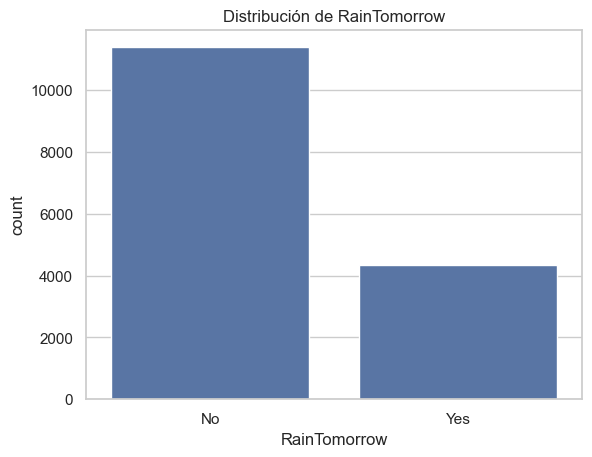

In [38]:
# Verificamos el balance de la variable objetivo (RainTomorrow)
print(pd.DataFrame(y_train)['RainTomorrow'].value_counts(normalize=True))

# Visualizamos el balance
sns.countplot(x='RainTomorrow', data=pd.DataFrame(y_train))
plt.title('Distribución de RainTomorrow')
plt.show()

Gracias al grafico, podemos ver que el dataset no esta balanceado, pues hay mas valores de que no va a llover, que de que si. Creemos que se hace esta pregunta para poder ver posibles problemas a futuro, como el impacto que tiene esto en el modelo.

Si no se aplican técnicas de balanceo, se puede generar un sesgo de predicción hacia la "No lluvia" ya que el modelo le asigna más penalidad el predecir mal esta variable dada su cantidad dentro del conjunto de entrenamiento, dejando con muy baja penalidad predecir mal el "Si lluvia" por su baja cantidad. Esto conduce a métricas engañosas ya que podría tener un accuracy muy alto sin significar que el modelo sea bueno.

## Codificacion de variables ##

Para codificar las variables, elegimos la representación en coordenadas polares sin-cos ya que de esta forma se disminuyen significativamente las columnas, manteniendo además la noción de 'antes' y 'después' en lo que respecta a días y de ubicación en lo que respecta a coordenadas cardenales.

In [39]:
def codificacion_localizacion(location: pd.Series) -> pd.DataFrame:
    location_to_coord = {
        'Williamtown': [-32.808996764, 151.838996644],
        'MountGinini': [-35.533, 148.783],
        'Bendigo': [-36.7581800, 144.2802400],
        'Portland': [-38.333332, 141.5999976],
        'Watsonia': [-37.69835, 145.08459],
        'Dartmoor': [-37.91439, 141.273],
        'Townsville': [-19.25762, 146.81788],
        'Launceston': [-41.43709, 147.13938],
        'AliceSprings': [-23.70021, 133.88061],
        'Katherine': [-14.46497, 132.26426]
    }
    
    # Mapeamos las ubicaciones a sus coordenadas
    coords = location.map(location_to_coord)
    
    # Creamos un DataFrame a partir de las coordenadas
    coords_df = pd.DataFrame(coords.tolist(), columns=['Latitude', 'Longitude'])
    
    # Retornamos la columna de latitud y longitud por separado
    latitude = coords_df['Latitude']
    longitude = coords_df['Longitude']    
    return latitude, longitude

In [40]:
def codificacion_coordenadas(column:pd.Series)-> pd.Series:
    '''
    Retorna dos columnas 'sin_cord' y 'cos_cord' que representan 
    en coordenadas polares la dirección cardinal.
    '''
    # Diccionario que asigna ángulos a cada dirección
    direction_to_angle = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }

    # Convertimos direcciones a ángulos
    angle = column.map(direction_to_angle)

    # Convertimos ángulos a radianes
    angle_rad = np.deg2rad(angle)

    # Calculamos senos y cosenos y devolver una tupla (sin, cos)

    sin_cord = np.sin(angle_rad)
    cos_cord = np.cos(angle_rad)

    return sin_cord, cos_cord


In [41]:
def codificacion(X: pd.DataFrame, y: pd.Series) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Dado dos df X e y, devuelve dos df X_encoded e y_encoded con
    sus columnas dummies codificadas por coordenadas polares

    X: conjunto x
    y: conjunto y
    '''
    x_encoded = X.copy()
    y_encoded = y.copy()

    # Codificación de la fecha en coordenadas polares según el día del año
    x_encoded['angle_day_of_year'] = (x_encoded['Day_of_Year'] / 365.0) * 2 * np.pi

    # Calculamos senos y cosenos para el día del año
    x_encoded['sin_day'] = np.sin(x_encoded['angle_day_of_year'])
    x_encoded['cos_day'] = np.cos(x_encoded['angle_day_of_year'])

    # Codificación de las direcciones de viento en coordenadas polares
    x_encoded['sin_WindGustDir'], x_encoded['cos_WindGustDir'] = codificacion_coordenadas(x_encoded['WindGustDir'])
    x_encoded['sin_WindDir9am'], x_encoded['cos_WindDir9am'] = codificacion_coordenadas(x_encoded['WindDir9am'])
    x_encoded['sin_WindDir3pm'], x_encoded['cos_WindDir3pm'] = codificacion_coordenadas(x_encoded['WindDir3pm'])

    #Codificación RainToday
    x_encoded['RainToday'] = x_encoded['RainToday'].map({'Yes': 1,  'No':0})

    #Codificación Location
    latitude, longitude = codificacion_localizacion(x_encoded['Location'])
    x_encoded['Latitude'] = latitude.values
    x_encoded['Longitude'] = longitude.values
    # Convertimos 'yes' a 1 y 'no' a 0 en la variable objetivo
    y_encoded = y_encoded.map({'Yes': 1, 'No': 0})

    # Eliminamos columnas ya codificadas
    x_encoded = x_encoded.drop(columns=['Day_of_Year', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location'])

    return x_encoded, y_encoded



In [42]:
### Codificamos los 3 conjuntos.
X_train_encoded, y_train_encoded = codificacion(X_train,y_train)
X_val_encoded, y_val_encoded = codificacion(X_val,y_val)
X_test_encoded, y_test_encoded = codificacion(X_test,y_test)

In [43]:
X_train_encoded.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'angle_day_of_year', 'sin_day',
       'cos_day', 'sin_WindGustDir', 'cos_WindGustDir', 'sin_WindDir9am',
       'cos_WindDir9am', 'sin_WindDir3pm', 'cos_WindDir3pm', 'Latitude',
       'Longitude'],
      dtype='object')

In [44]:
#Chequeamos las columnas de todos los conjuntos
X_train_encoded.shape,X_val_encoded.shape, X_test_encoded.shape

((15726, 28), (6740, 28), (5617, 28))

In [45]:
#Chequeamos la forma del conjunto y
y_train_encoded.shape,y_val_encoded.shape, y_test_encoded.shape

((15726,), (6740,), (5617,))

In [46]:
### Nos aseguramos que se hayan codificado todas las columnas de X
(X_train_encoded.isna().sum() + X_val_encoded.isna().sum()+X_test_encoded.isna().sum()).sum()

0

In [47]:
### Nos aseguramos que se hayan codificado todas las columnas de y
(y_train_encoded.isna().sum()+y_val_encoded.isna().sum()+y_test_encoded.isna().sum()).sum()

0

## Matriz de correlacion de variables ## 

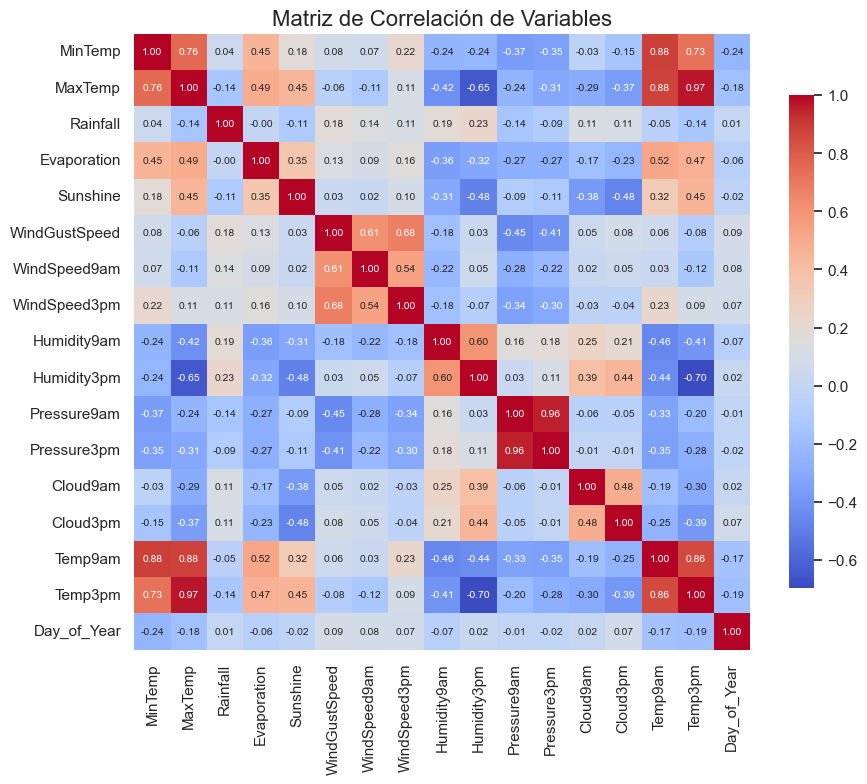

In [48]:
plt.figure(figsize=(10, 8))


sns.heatmap(X_train.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 7.5})

plt.title('Matriz de Correlación de Variables', fontsize=16)
plt.show()

Gracias a la matriz de correlacion, se pueden hacer algunas observaciones:

* MaxTemp y Temp3pm: También tienen una correlación muy alta (0.97), lo que indica que la temperatura máxima diaria tiende a estar cercana a la de las 3 pm.

* Pressure9am y Pressure3pm: La correlación es casi perfecta (0.95), lo que sugiere que la presión atmosférica no cambia mucho entre la mañana y la tarde.

* MinTemp y Temp9am: Tienen una correlación muy alta (0.88), lo que sugiere que la temperatura mínima registrada durante el día está muy ligada a la temperatura a las 9 de la mañana.

* MaxTemp y  Temp9am: Tienen una correlación muy alta (0.88), lo que sugiere que la temperatura máxima registrada durante el día también está muy ligada a la temperatura a las 9 de la mañana.

* Temp9am y Temp3pm: Hay una correlación casi perfecta (0.86) entre estas dos variables, lo que es esperable ya que las temperaturas en diferentes momentos del día suelen estar relacionadas.

* MinTemp y MaxTemp: Hay una fuerte correlación positiva (0.75), lo que indica que si la temperatura mínima sube, es probable que la temperatura máxima también lo haga.

In [49]:
#Creamos la matriz de correlacion
correlation_matrix = X_train.select_dtypes(include=['number']).corr()

# Aplanamos la matriz de correlación y reseteamos los índices
correlation_pairs = correlation_matrix.unstack().reset_index()

# Renombramos las columnas
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Eliminamos las correlaciones duplicadas (diagonal y columnas)
correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]

# Ordenamos por la mayor correlación positiva
correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

# Eliminamos duplicados y valores nulos
correlation_pairs.drop_duplicates(subset=['Correlation'], inplace=True)
correlation_pairs.dropna(inplace=True)

# Reseteamos el índice
correlation_pairs.reset_index(drop=True, inplace=True)

# Mostramos las 10 pares de variables con mayor correlación positiva y las 10 pares de variables con mayor correlación negativa
print(correlation_pairs.head(10), '\n', correlation_pairs.tail(10))

     Variable 1     Variable 2  Correlation
0       MaxTemp        Temp3pm     0.972721
1   Pressure3pm    Pressure9am     0.956598
2       Temp9am        MinTemp     0.883017
3       Temp9am        MaxTemp     0.880189
4       Temp9am        Temp3pm     0.859462
5       MaxTemp        MinTemp     0.756201
6       Temp3pm        MinTemp     0.727110
7  WindSpeed3pm  WindGustSpeed     0.677026
8  WindSpeed9am  WindGustSpeed     0.614888
9   Humidity3pm    Humidity9am     0.598987 
         Variable 1     Variable 2  Correlation
126        Temp3pm    Humidity9am    -0.405035
127  WindGustSpeed    Pressure3pm    -0.410993
128        MaxTemp    Humidity9am    -0.422752
129    Humidity3pm        Temp9am    -0.438490
130    Pressure9am  WindGustSpeed    -0.447772
131        Temp9am    Humidity9am    -0.462118
132       Cloud3pm       Sunshine    -0.475511
133       Sunshine    Humidity3pm    -0.480576
134    Humidity3pm        MaxTemp    -0.649800
135    Humidity3pm        Temp3pm    -0.6973

## Estandarizacion y escalado de datos ##

Gracias a los boxplots hechos anteriormente, podemos ver una cantidad de valores atipicos grande, entonces lo que mas nos conviene es usar un escalado robusto

# Punto 2

Implementar la solución del problema de clasificación con regresión logística.

## Weighted vs Balanced

In [50]:
logist_class_w = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_w.fit(X_train_encoded,y_train_encoded)
logist_class_b = make_pipeline(RobustScaler(), LogisticRegression(random_state=42, class_weight='balanced'))
logist_class_b.fit(X_train_encoded,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

### Matriz de Confusión Modelos W y B

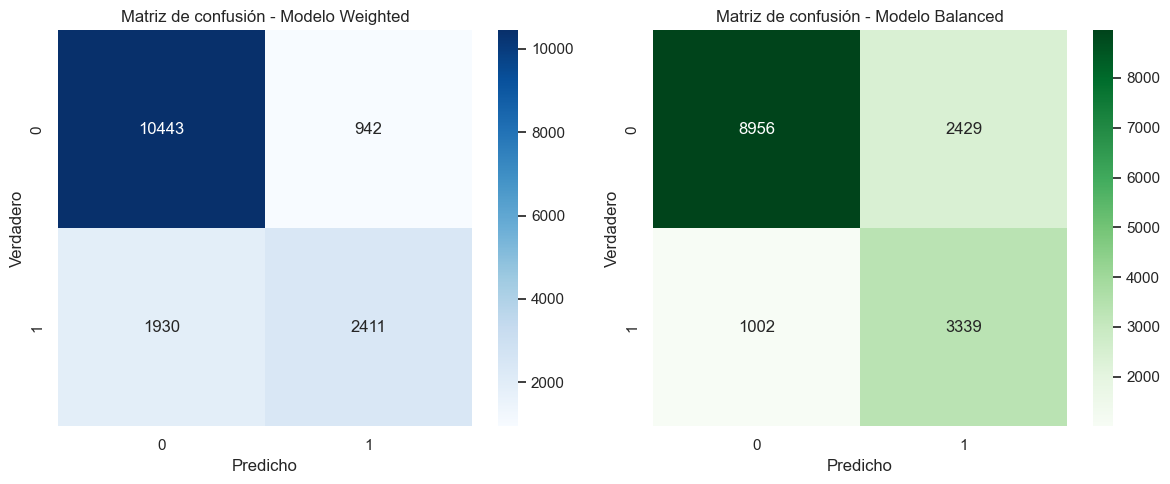

In [51]:
# Predecir las etiquetas en el conjunto de prueba o validación (usa el conjunto que prefieras)
y_train_pred_w = logist_class_w.predict(X_train_encoded)
y_val_pred_w = logist_class_w.predict(X_val_encoded)
y_test_pred_w = logist_class_w.predict(X_test_encoded)
y_train_pred_b = logist_class_b.predict(X_train_encoded)
y_val_pred_b = logist_class_b.predict(X_val_encoded)
y_test_pred_b = logist_class_b.predict(X_test_encoded)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train_encoded, y_train_pred_w)
cmb = confusion_matrix(y_train_encoded, y_train_pred_b)

# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap para la primera matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Weighted")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")

# Heatmap para la segunda matriz de confusión
sns.heatmap(cmb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Balanced")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [52]:
y_train_encoded.value_counts()

RainTomorrow
0    11385
1     4341
Name: count, dtype: int64

Definiendo clase Positiva a "Lluvia"

Modelo Weighted:
- Falsos Positivos: Hubo 942 días en los que se predijo que no iba a llover (0) y llovió (1).
- Falsos Negativos: Hubo 1.930 días en los que se predijo que iba a llover (1) y no llovió (0).

Modelo Balanced:
- Falsos Positivos: Hubo 2.429 días en los que se predijo que no iba a llover (0) y llovió (1)
- Falsos Negativos: Hubo 1.002 días en los que se predijo que iba a llover (1) y no llovió (0)

En el primer modelo (Weighted), tiene sentido que el dataset esté desbalanceado, con una mayor proporción de días en los que "No llueve" (0). Como se priorizó predecir correctamente los días en los que no llueve, se obtuvo un número alto de predicciones correctas para esta clase (11,282), con solo 750 días mal predichos (falsos positivos). Sin embargo, la clase "Llueve" (1) tuvo un desempeño inferior, con solo 1,930 días correctamente predichos y 1,770 días mal predichos (falsos negativos), lo que significa que la mitad de los días en los que llovió no fueron correctamente identificados.

En el segundo modelo (Balanced), al aplicar una penalización mayor a la clase con menos datos ("Llueve"), se logra disminuir significativamente la tasa de falsos negativos, reduciéndolos a 841. Sin embargo, el número de falsos positivos aumenta considerablemente, casi triplicándose a 2,455. Esto refleja que se ha logrado balancear las detecciones de ambas clases, pero a costa de aumentar los errores en los días que no llueve.

#### Vemos la diferencia en las metricas

In [53]:
metricas_reg_logistica = metricas(
    {
        'Regresion Logistica Weighted':[
            [X_train_encoded,X_val_encoded,X_test_encoded],
            (y_train_encoded, y_train_pred_w),
            (y_val_encoded, y_val_pred_w),
            (y_test_encoded, y_test_pred_w)
        ]
    }, model = logist_class_w
)

In [54]:
metricas_reg_logistica

Nombre Modelo  Accuracy Train  \
Regresion Logistica Weighted  Regresion Logistica Weighted        0.817373   

                              Recall 2 clases Train  Precision Llueve Train  \
Regresion Logistica Weighted               0.663959                0.719058   

                              Recall Llueve Train  F1-Score Llueve Train  \
Regresion Logistica Weighted             0.555402               0.626722   

                              AUC-ROC Llueve Train  Precision No Llueve Train  \
Regresion Logistica Weighted              0.860877                   0.844015   

                              Recall No Llueve Train  \
Regresion Logistica Weighted                 0.91726   

                              F1-Score No Llueve Train  ...  Accuracy Test  \
Regresion Logistica Weighted                  0.879114  ...       0.557059   

                              Recall 2 clases Test  Precision Llueve Test  \
Regresion Logistica Weighted                0.6913               0.191905   

                              Recall Llueve Test  F1-Score Llueve Test  \
Regresion Logistica Weighted            0.761773              0.306577   

                              AUC-ROC Llueve Test  Precision No Llueve Test  \
Regresion Logistica Weighted             0.729078                  0.937477   

                              Recall No Llueve Test  F1-Score No Llueve Test  \
Regresion Logistica Weighted               0.526864                 0.674601   

                              AUC-ROC No Llueve Test  
Regresion Logistica Weighted                0.270922  

[1 rows x 31 columns]

**Accuracy**

El accuracy general del modelo es relativamente alto (81.73%). Sin embargo, dado que las clases están desbalanceadas, esta métrica por sí sola no es suficiente para evaluar el rendimiento del modelo en detalle ya que se trata de un modelo desbalanceado.

**Precision**

- Para la clase "Llueve", la precisión es del 71.9%, lo que significa que, de todas las predicciones positivas (cuando se predijo que iba a llover), el 71.9% fueron realmente positivas. Esto indica que el modelo genera algunos falsos positivos.
- Para la clase "No Llueve", la precisión es alta, con un 84.4%, lo que sugiere que el modelo es más confiable al predecir los días en los que no llueve.

**Recall**

- El recall para "Llueve" es del 55.54%, lo que significa que el modelo solo identifica correctamente el 55.54% de los días en los que realmente llovió. Esto es preocupante porque indica que el modelo pierde una cantidad significativa de instancias de lluvia, lo que puede ser crítico en situaciones donde es importante predecir los días de lluvia.
- En contraste, el recall para "No Llueve" es muy alto, 91.72%, lo que sugiere que el modelo es efectivo para identificar los días en los que no llueve, aunque esto puede estar ocurriendo a expensas de la clase "Llueve".

**F1 Score**

- El F1 Score para la clase "Llueve" es de 62.67%, lo que refleja un rendimiento moderado del modelo en esta clase, equilibrando la precisión y el recall.
- Para la clase "No Llueve", el F1 Score es significativamente más alto, 87.91%, lo que muestra un mejor rendimiento del modelo para identificar correctamente los días sin lluvia.

**AUC-ROC**

El AUC-ROC es de 0.860877, lo que indica que el modelo tiene una capacidad razonablemente alta para diferenciar entre días de lluvia y días sin lluvia.

**Recall 2 clases**

Este recall da 0.66, lo que da cuenta de que el modelo no está funcionando bien para predecir la clase llueve con más importancia sin dejar de ver la clase no llueve.

**Conclusión sobre el desbalance de clases**

El modelo tiene un buen rendimiento para la clase "No Llueve", pero sufre considerablemente con la clase "Llueve", como se refleja en el menor recall y F1 score. Esto es común en modelos que no están ajustados para manejar datos desbalanceados, y puede llevar a decisiones incorrectas en aplicaciones donde es crucial identificar los días de lluvia.

In [55]:
metricas_reg_logistica = pd.concat([metricas_reg_logistica,
    metricas(
    {
        'Regresion Logistica Balanced':[
            [X_train_encoded,X_val_encoded,X_test_encoded],
            (y_train_encoded, y_train_pred_b),
            (y_val_encoded, y_val_pred_b),
            (y_test_encoded, y_test_pred_b)
        ]
    }, model = logist_class_b
)])

In [56]:
metricas_reg_logistica

Nombre Modelo  Accuracy Train  \
Regresion Logistica Weighted  Regresion Logistica Weighted        0.817373   
Regresion Logistica Balanced  Regresion Logistica Balanced        0.781826   

                              Recall 2 clases Train  Precision Llueve Train  \
Regresion Logistica Weighted               0.663959                0.719058   
Regresion Logistica Balanced               0.774419                0.578883   

                              Recall Llueve Train  F1-Score Llueve Train  \
Regresion Logistica Weighted             0.555402               0.626722   
Regresion Logistica Balanced             0.769178               0.660599   

                              AUC-ROC Llueve Train  Precision No Llueve Train  \
Regresion Logistica Weighted              0.860877                   0.844015   
Regresion Logistica Balanced              0.861105                   0.899377   

                              Recall No Llueve Train  \
Regresion Logistica Weighted                0.917260   
Regresion Logistica Balanced                0.786649   

                              F1-Score No Llueve Train  ...  Accuracy Test  \
Regresion Logistica Weighted                  0.879114  ...       0.557059   
Regresion Logistica Balanced                  0.839245  ...       0.431013   

                              Recall 2 clases Test  Precision Llueve Test  \
Regresion Logistica Weighted              0.691300               0.191905   
Regresion Logistica Balanced              0.698771               0.164406   

                              Recall Llueve Test  F1-Score Llueve Test  \
Regresion Logistica Weighted            0.761773              0.306577   
Regresion Logistica Balanced            0.839335              0.274955   

                              AUC-ROC Llueve Test  Precision No Llueve Test  \
Regresion Logistica Weighted             0.729078                  0.937477   
Regresion Logistica Balanced             0.729549                  0.939927   

                              Recall No Llueve Test  F1-Score No Llueve Test  \
Regresion Logistica Weighted               0.526864                 0.674601   
Regresion Logistica Balanced               0.370787                 0.531790   

                              AUC-ROC No Llueve Test  
Regresion Logistica Weighted                0.270922  
Regresion Logistica Balanced                0.270451  

[2 rows x 31 columns]

**Accuracy**

El accuracy es 0.7818, lo cual, aunque es menor que el del modelo no balanceado, al tener penalidades balanceadas es un valor más "realista". Esto significa que el modelo está equilibrando mejor ambas clases.
Precision:

**Precisión**
- Para la clase "Llueve", la precisión es de 57.88%, lo que significa que un poco más de la mitad de las predicciones positivas (cuando el modelo predice lluvia) son correctas. Esta es una reducción significativa en comparación con el modelo no balanceado, lo que indica que el modelo está dispuesto a aceptar más falsos positivos para mejorar la capacidad de capturar los días lluviosos.
- Para la clase "No Llueve", la precisión sigue siendo alta, en 89.93%, lo que indica que el modelo sigue siendo muy confiable cuando predice que no va a llover.

**Recall**

- El recall para la clase "Llueve" es 76.91%, lo que significa que el modelo identifica correctamente la mayoría de los días en los que realmente llueve, mejorando considerablemente respecto al modelo no balanceado.
- Para la clase "No Llueve", el recall es 78.66%, menor que el del modelo no balanceado, pero sigue siendo bueno y muestra que el modelo sigue capturando adecuadamente la mayoría de los días sin lluvia.

**F1 Score**

- El F1 Score para "Llueve" es de 66.05%, lo que refleja un rendimiento moderado, equilibrando precisión y recall. Este valor es más alto que en el modelo no balanceado, lo que indica una mejora general en la capacidad del modelo para manejar la clase minoritaria ("Llueve").
- Para "No Llueve", el F1 Score es 83.92%, lo que sigue reflejando un excelente rendimiento para la clase mayoritaria.


**AUC-ROC**

El modelo tiene una AUC-ROC de 0.8611, similar al anterior.

**Recall 2 clases**

Vemos una mejora considerable en este recall a raiz de la mejora en el recall de la clase 1, el cual tiene más importancia, pero aún asi vemos como el recall de la clase 0 no sufre una desmejoría muy pronunciada. Se ve una tendencia a desmejorar con el conjunto de test.

##### Mejora en el Recall

El modelo balanceado muestra una mejora significativa en el recall para la clase "Llueve" en comparación con el modelo no balanceado. Esto significa que el modelo es más efectivo en identificar instancias de lluvia, lo cual es crítico en situaciones donde es importante no perder casos positivos (como predicciones de eventos climáticos adversos).
Esto también se refleja en una mejoría para la métrica "recall de 2 clases".

##### Compromiso entre Clases

La precisión de la clase "Llueve" ha disminuido en comparación con el modelo no balanceado, lo que indica que el modelo está dispuesto a aceptar más falsos positivos con el fin de mejorar su capacidad para identificar los días lluviosos. Este es un trade-off común en modelos balanceados y puede ser aceptable dependiendo del contexto del problema.

### Curva ROC modelos W y B

Trazar curvas ROC para cada modelo. Comenten cuáles serían los umbrales adecuados a utilizar; ¿cómo podrían calcular el mejor umbral? ¿Es 0.5 el mejor?

In [57]:
#Probabilidades de predicción modelo w
y_train_probs_w = logist_class_w.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_w, tpr_w, thresholds_w = roc_curve(y_train_encoded, y_train_probs_w)

roc_auc_w = auc(fpr_w, tpr_w)

#Probabilidades de predicción modelo b
y_train_probs_b = logist_class_b.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC
fpr_b, tpr_b, thresholds_b = roc_curve(y_train_encoded, y_train_probs_b)

roc_auc_b = auc(fpr_b, tpr_b)

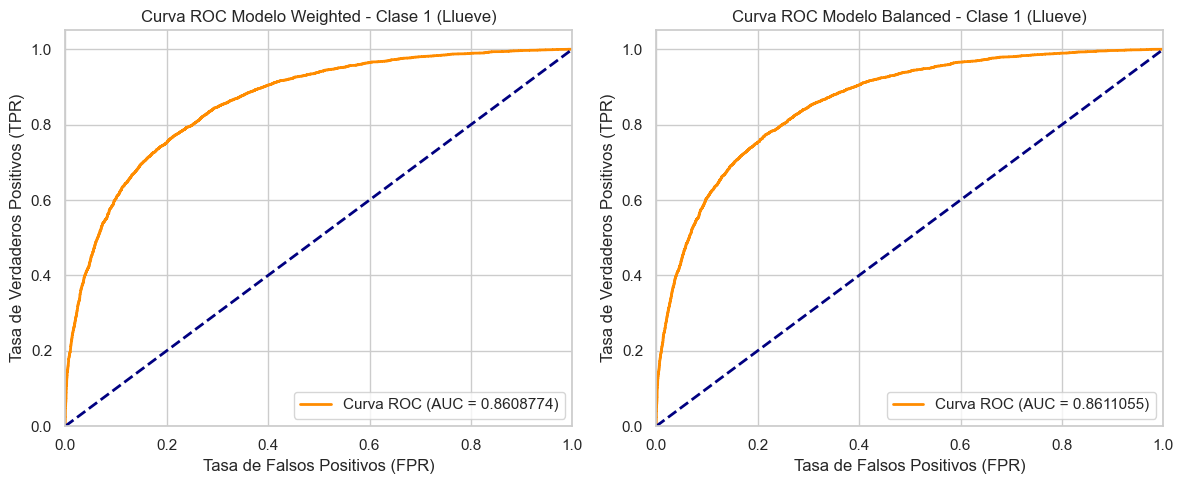

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva ROC AUC para modelo Weighted (Clase 1: Llueve)
axes[0].plot(fpr_w, tpr_w, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc_w)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC Modelo Weighted - Clase 1 (Llueve)')
axes[0].legend(loc="lower right")

# Curva ROC AUC para modelo Balanced (Clase 1: Llueve)
axes[1].plot(fpr_b, tpr_b, color='darkorange', lw=2, label='Curva ROC (AUC = %0.7f)' % roc_auc_b)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC Modelo Balanced - Clase 1 (Llueve)')
axes[1].legend(loc="lower right")

# Ajustamos el espaciado entre gráficos
plt.tight_layout()
plt.show()




##### Modelo Weighted.
- Clase 1 (Llueve):
    El AUC es 0.8608, lo que sugiere que el modelo ponderado tiene un buen rendimiento al predecir la clase "Llueve". La curva ROC está alejada de la diagonal, lo que indica que el modelo tiene una buena capacidad de distinguir entre "Llueve" y "No Llueve", con una baja tasa de falsos positivos y una alta tasa de verdaderos positivos.

##### Modelo Balanced
- Clase 0 (No Llueve):
    El AUC es 0.8611, casi idéntico al del modelo ponderado. Esto indica que el balanceo de las clases no ha mejorado el rendimiento del modelo en la predicción signidicativamente.


##### Conclusión general
El modelo tiene un rendimiento similar para predecir la clase "Llueve", tanto en la versión ponderada como balanceada, con un AUC alrededor de 0.86. 





#### Auc
El AUC (Área Bajo la Curva) es de 0.86 aproximada para ambas, lo cual es una buena señal ya que esta cerca de 1 (es decir, cerca de tener un buen poder de discriminación entre clases).
El mejor umbral se puede calcular como aquel punto en la curva ROC que tenga la menor distancia euclidiana al punto (1,0). 
0.5 generalmente suele ser un buen umbral para modelos balanceados, como este no es el caso, no sería el mejor umbral.

### Fitting Modelos W y B

El fitting no es el mejor, ya que hay una gran diferencia entre los verdaderos positivos de No Lluvia y los verdaderos negativos de No Lluvia. Esto puede deberse al mal balanceo de clases, a pesar de proponer el modelo balanced.

## Modelo Balanceado con Oversampling

In [59]:
from imblearn.over_sampling import SMOTE

# Inicializa SMOTE con un random_state para reproducibilidad
oversampler = SMOTE(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train_encoded, y_train_encoded)
X_val_resampled, y_val_resampled = oversampler.fit_resample(X_val_encoded,y_val_encoded )


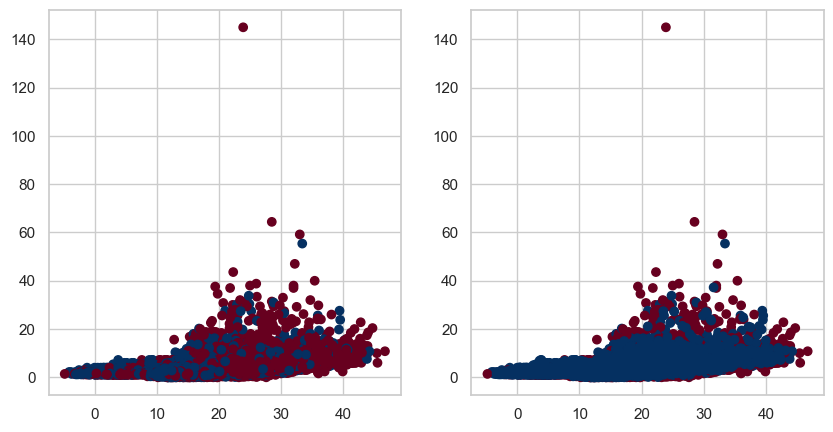

In [60]:
##Vemos la diferencia entre el original y el oversampled para dos columnas
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].scatter(X_train_encoded['MaxTemp'], X_train_encoded['Evaporation'], c=y_train_encoded, cmap=plt.cm.RdBu)
ax[1].scatter(X_resampled['MaxTemp'], X_resampled['Evaporation'], c=y_resampled, cmap=plt.cm.RdBu)
plt.show()

### Modelo Logistic oversampled

In [61]:
logist_class_oversampled = make_pipeline(RobustScaler(), LogisticRegression(random_state = 9))

In [62]:
logist_class_oversampled.fit(X_resampled,y_resampled)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=9))])

In [63]:
y_train_pred_ov = logist_class_oversampled.predict(X_resampled)
y_val_pred_ov = logist_class_oversampled.predict(X_val_resampled)
y_test_pred_ov = logist_class_oversampled.predict(X_test_encoded)

### Matriz de confusión modelo oversampled

In [64]:
cm_ov = confusion_matrix(y_resampled, y_train_pred_ov)

### Heatmap para la segunda matriz de confusión

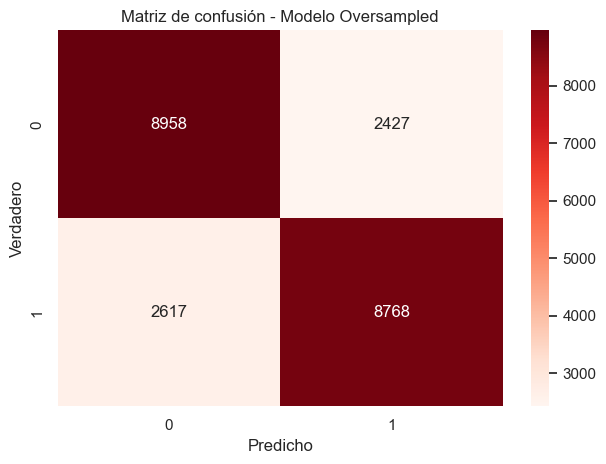

In [65]:
sns.heatmap(cm_ov, annot=True, fmt="d", cmap="Reds")
plt.title("Matriz de confusión - Modelo Oversampled")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Se ve que el modelo tiene una cantidad de falsos negativos similar al modelo balanced, sin embargo, hay que tener en cuenta los valores de las métricas ya que al hacer oversampling se estan agregando datos.
- Falsos Positivos: Hubo 2.425 días en los que se predijo que no iba a llover (0) y llovió (1). 
- Falsos Negativos: Hubo 2.621 días en los que se predijo que iba a llover (1) y no llovió (0). 


### Métricas modelo oversampled

In [66]:
metricas_reg_logistica = pd.concat([metricas_reg_logistica,
    metricas(
    {
        'Regresion Logistica Oversampled':[
            [X_resampled,   X_val_resampled,X_test_encoded],
            (y_resampled, y_train_pred_ov),
            (y_val_resampled, y_val_pred_ov),
            (y_test_encoded, y_test_pred_ov)
        ]
    }, model = logist_class_oversampled
)])

In [67]:
metricas_reg_logistica

Nombre Modelo  \
Regresion Logistica Weighted        Regresion Logistica Weighted   
Regresion Logistica Balanced        Regresion Logistica Balanced   
Regresion Logistica Oversampled  Regresion Logistica Oversampled   

                                 Accuracy Train  Recall 2 clases Train  \
Regresion Logistica Weighted           0.817373               0.663959   
Regresion Logistica Balanced           0.781826               0.774419   
Regresion Logistica Oversampled        0.778480               0.775143   

                                 Precision Llueve Train  Recall Llueve Train  \
Regresion Logistica Weighted                   0.719058             0.555402   
Regresion Logistica Balanced                   0.578883             0.769178   
Regresion Logistica Oversampled                0.783207             0.770136   

                                 F1-Score Llueve Train  AUC-ROC Llueve Train  \
Regresion Logistica Weighted                  0.626722              0.860877   
Regresion Logistica Balanced                  0.660599              0.861105   
Regresion Logistica Oversampled               0.776616              0.864909   

                                 Precision No Llueve Train  \
Regresion Logistica Weighted                      0.844015   
Regresion Logistica Balanced                      0.899377   
Regresion Logistica Oversampled                   0.773909   

                                 Recall No Llueve Train  \
Regresion Logistica Weighted                   0.917260   
Regresion Logistica Balanced                   0.786649   
Regresion Logistica Oversampled                0.786825   

                                 F1-Score No Llueve Train  ...  Accuracy Test  \
Regresion Logistica Weighted                     0.879114  ...       0.557059   
Regresion Logistica Balanced                     0.839245  ...       0.431013   
Regresion Logistica Oversampled                  0.780314  ...       0.558661   

                                 Recall 2 clases Test  Precision Llueve Test  \
Regresion Logistica Weighted                 0.691300               0.191905   
Regresion Logistica Balanced                 0.698771               0.164406   
Regresion Logistica Oversampled              0.754521               0.206678   

                                 Recall Llueve Test  F1-Score Llueve Test  \
Regresion Logistica Weighted               0.761773              0.306577   
Regresion Logistica Balanced               0.839335              0.274955   
Regresion Logistica Oversampled            0.857341              0.333064   

                                 AUC-ROC Llueve Test  \
Regresion Logistica Weighted                0.729078   
Regresion Logistica Balanced                0.729549   
Regresion Logistica Oversampled             0.777855   

                                 Precision No Llueve Test  \
Regresion Logistica Weighted                     0.937477   
Regresion Logistica Balanced                     0.939927   
Regresion Logistica Oversampled                  0.960717   

                                 Recall No Llueve Test  \
Regresion Logistica Weighted                  0.526864   
Regresion Logistica Balanced                  0.370787   
Regresion Logistica Oversampled               0.514607   

                                 F1-Score No Llueve Test  \
Regresion Logistica Weighted                    0.674601   
Regresion Logistica Balanced                    0.531790   
Regresion Logistica Oversampled                 0.670214   

                                 AUC-ROC No Llueve Test  
Regresion Logistica Weighted                   0.270922  
Regresion Logistica Balanced                   0.270451  
Regresion Logistica Oversampled                0.222145  

[3 rows x 31 columns]

## Comparación modelo Weighted, Balanced y Oversampled

In [68]:
metricas_reg_logistica

Nombre Modelo  \
Regresion Logistica Weighted        Regresion Logistica Weighted   
Regresion Logistica Balanced        Regresion Logistica Balanced   
Regresion Logistica Oversampled  Regresion Logistica Oversampled   

                                 Accuracy Train  Recall 2 clases Train  \
Regresion Logistica Weighted           0.817373               0.663959   
Regresion Logistica Balanced           0.781826               0.774419   
Regresion Logistica Oversampled        0.778480               0.775143   

                                 Precision Llueve Train  Recall Llueve Train  \
Regresion Logistica Weighted                   0.719058             0.555402   
Regresion Logistica Balanced                   0.578883             0.769178   
Regresion Logistica Oversampled                0.783207             0.770136   

                                 F1-Score Llueve Train  AUC-ROC Llueve Train  \
Regresion Logistica Weighted                  0.626722              0.860877   
Regresion Logistica Balanced                  0.660599              0.861105   
Regresion Logistica Oversampled               0.776616              0.864909   

                                 Precision No Llueve Train  \
Regresion Logistica Weighted                      0.844015   
Regresion Logistica Balanced                      0.899377   
Regresion Logistica Oversampled                   0.773909   

                                 Recall No Llueve Train  \
Regresion Logistica Weighted                   0.917260   
Regresion Logistica Balanced                   0.786649   
Regresion Logistica Oversampled                0.786825   

                                 F1-Score No Llueve Train  ...  Accuracy Test  \
Regresion Logistica Weighted                     0.879114  ...       0.557059   
Regresion Logistica Balanced                     0.839245  ...       0.431013   
Regresion Logistica Oversampled                  0.780314  ...       0.558661   

                                 Recall 2 clases Test  Precision Llueve Test  \
Regresion Logistica Weighted                 0.691300               0.191905   
Regresion Logistica Balanced                 0.698771               0.164406   
Regresion Logistica Oversampled              0.754521               0.206678   

                                 Recall Llueve Test  F1-Score Llueve Test  \
Regresion Logistica Weighted               0.761773              0.306577   
Regresion Logistica Balanced               0.839335              0.274955   
Regresion Logistica Oversampled            0.857341              0.333064   

                                 AUC-ROC Llueve Test  \
Regresion Logistica Weighted                0.729078   
Regresion Logistica Balanced                0.729549   
Regresion Logistica Oversampled             0.777855   

                                 Precision No Llueve Test  \
Regresion Logistica Weighted                     0.937477   
Regresion Logistica Balanced                     0.939927   
Regresion Logistica Oversampled                  0.960717   

                                 Recall No Llueve Test  \
Regresion Logistica Weighted                  0.526864   
Regresion Logistica Balanced                  0.370787   
Regresion Logistica Oversampled               0.514607   

                                 F1-Score No Llueve Test  \
Regresion Logistica Weighted                    0.674601   
Regresion Logistica Balanced                    0.531790   
Regresion Logistica Oversampled                 0.670214   

                                 AUC-ROC No Llueve Test  
Regresion Logistica Weighted                   0.270922  
Regresion Logistica Balanced                   0.270451  
Regresion Logistica Oversampled                0.222145  

[3 rows x 31 columns]

Se puede ver que entre los 3 modelos, aquel que tiene una mayor consistencia para ambas clases es el oversampled; se ve que tiene un MCC de 0.5568 lo que indica que teien un rendimiento global más consistente entre clases, como así tambien obtiene el mejor resultado en Cohen's Kappa (0.5567), indicando mejor acuerdo entre el modelo y la etiqueta verdadera comparado con los otros dos modelos.

Conclusión General:
- Modelo Oversampled: Tiene un buen balance entre precisión y recall, con un MCC y Kappa ligeramente superiores. Si se busca un modelo que tenga un desempeño estable entre ambas clases, este modelo parece una buena opción.
- Modelo Weighted: Es excelente para predecir "No Llueve" (alta precisión, recall y F1 score para esa clase), pero sufre bastante en la predicción de "Llueve", con un recall bajo (55.54%).
- Modelo Balanced: Mantiene un equilibrio intermedio, destacando en precisión para "No Llueve" (89.93%) y con un recall mejorado para "Llueve" (76.91%), pero su precisión para "Llueve" es más baja (57.88%).


Cada modelo tiene sus fortalezas según la clase en la que se quiera enfocar. El modelo oversampled parece el más balanceado, pero el weighted puede ser útil si la clase "No Llueve" es más importante para el objetivo.

En el contexto de nuestro problema, donde le damos más importancia a los errores en la clase lluvia, pero sin desatender al recall de la clase no lluvia, los modelos balanceados tienen un mejor rendimiento; esto se refleja en la métrica recall 2 clases, la cual tiene justamente en cuenta esto. Ambos modelos tienen un número casi idéntico en esta métrica (0.77 aproximado) en el conjunto de train;
sin embargo, en el conjunto de test, el modelo con oversampled funciona altamente mejor y manteniendo la generalización que se observa en train con una métrica para test de 0.75.

### Curva ROC - AUC para modelo oversampled

In [69]:
#Probabilidades de predicción modelo oversampled
y_train_probs_ov = logist_class_oversampled.predict_proba(X_train_encoded)[:,1]

#Calculo ROC y AUC para clase No Llueve
fpr_ov, tpr_ov, thresholds_ov = roc_curve(y_train_encoded, y_train_probs_ov)

roc_auc_ov = auc(fpr_ov, tpr_ov)

# Curva ROC AUC para la clase Llueve
fpr_ov_no_llueve, tpr_ov_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_ov)
roc_auc_no_ov_llueve = auc(fpr_ov_no_llueve, tpr_ov_llueve)

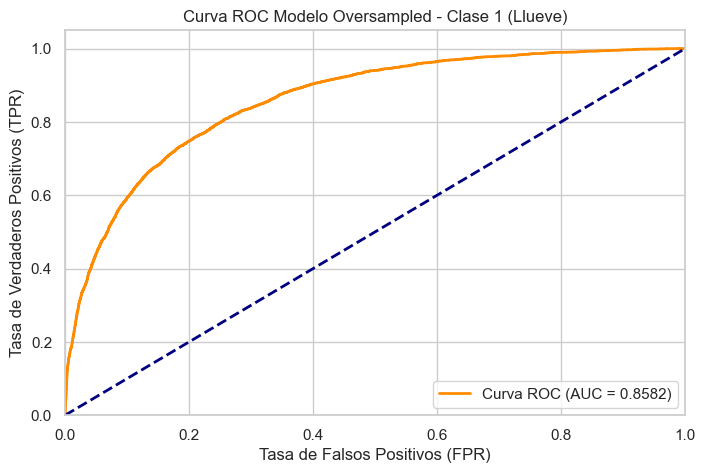

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))
# Curva ROC AUC para modelo Oversampled (Clase 1: Llueve)
axes.plot(fpr_ov, tpr_ov, color='darkorange', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc_ov)
axes.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal (clasificador aleatorio)
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('Tasa de Falsos Positivos (FPR)')
axes.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes.set_title('Curva ROC Modelo Oversampled - Clase 1 (Llueve)')
axes.legend(loc="lower right")


Los tres modelos tienen AUCs casi idénticas para ambas clases. Lo que sugiere que los tres modelos tienen similar capacidad para discriminar entre las clases.

### Métrica elegida para evaluar.

Se elige la métrica 'Recall 2 clases'.
Esta métrica se compone por:
- Recall clase 1: es decir, recall para Llueve.
- Recall clase 0: es decir, recall para no llueve.
- Alpha: importancia que se le da al recall clase 1.

Usamos la función "Recall 2 clases", la cual realiza la siguiente operación y la devuelve como métrica:

recall_2_clases = alpha * recall clase 1 + (1-alpha) * recall_clase_0

Si se elige un alpha 0.5, tendrá el mismo peso cada recall.

En particular, elegimos un alpha 0.7

La utilización de esta métrica se debe a que nos interesa que el recall de la clase 1 sea elevado, pero sin perder mucha eficiencia en el recall de la clase 0.

### Fitting modelo oversampled

In [71]:
metricas_reg_logistica

Nombre Modelo  \
Regresion Logistica Weighted        Regresion Logistica Weighted   
Regresion Logistica Balanced        Regresion Logistica Balanced   
Regresion Logistica Oversampled  Regresion Logistica Oversampled   

                                 Accuracy Train  Recall 2 clases Train  \
Regresion Logistica Weighted           0.817373               0.663959   
Regresion Logistica Balanced           0.781826               0.774419   
Regresion Logistica Oversampled        0.778480               0.775143   

                                 Precision Llueve Train  Recall Llueve Train  \
Regresion Logistica Weighted                   0.719058             0.555402   
Regresion Logistica Balanced                   0.578883             0.769178   
Regresion Logistica Oversampled                0.783207             0.770136   

                                 F1-Score Llueve Train  AUC-ROC Llueve Train  \
Regresion Logistica Weighted                  0.626722              0.860877   
Regresion Logistica Balanced                  0.660599              0.861105   
Regresion Logistica Oversampled               0.776616              0.864909   

                                 Precision No Llueve Train  \
Regresion Logistica Weighted                      0.844015   
Regresion Logistica Balanced                      0.899377   
Regresion Logistica Oversampled                   0.773909   

                                 Recall No Llueve Train  \
Regresion Logistica Weighted                   0.917260   
Regresion Logistica Balanced                   0.786649   
Regresion Logistica Oversampled                0.786825   

                                 F1-Score No Llueve Train  ...  Accuracy Test  \
Regresion Logistica Weighted                     0.879114  ...       0.557059   
Regresion Logistica Balanced                     0.839245  ...       0.431013   
Regresion Logistica Oversampled                  0.780314  ...       0.558661   

                                 Recall 2 clases Test  Precision Llueve Test  \
Regresion Logistica Weighted                 0.691300               0.191905   
Regresion Logistica Balanced                 0.698771               0.164406   
Regresion Logistica Oversampled              0.754521               0.206678   

                                 Recall Llueve Test  F1-Score Llueve Test  \
Regresion Logistica Weighted               0.761773              0.306577   
Regresion Logistica Balanced               0.839335              0.274955   
Regresion Logistica Oversampled            0.857341              0.333064   

                                 AUC-ROC Llueve Test  \
Regresion Logistica Weighted                0.729078   
Regresion Logistica Balanced                0.729549   
Regresion Logistica Oversampled             0.777855   

                                 Precision No Llueve Test  \
Regresion Logistica Weighted                     0.937477   
Regresion Logistica Balanced                     0.939927   
Regresion Logistica Oversampled                  0.960717   

                                 Recall No Llueve Test  \
Regresion Logistica Weighted                  0.526864   
Regresion Logistica Balanced                  0.370787   
Regresion Logistica Oversampled               0.514607   

                                 F1-Score No Llueve Test  \
Regresion Logistica Weighted                    0.674601   
Regresion Logistica Balanced                    0.531790   
Regresion Logistica Oversampled                 0.670214   

                                 AUC-ROC No Llueve Test  
Regresion Logistica Weighted                   0.270922  
Regresion Logistica Balanced                   0.270451  
Regresion Logistica Oversampled                0.222145  

[3 rows x 31 columns]

En particular, el fitting de este modelo es aceptable, obteniendo un recall_2_clases de 0.77 para train y de 0.75 para test.

# Punto 3

### Modelo Base 1: regresión lineal

In [72]:
X_train_regresion = X_train_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_val_regresion = X_val_encoded[['MaxTemp', 'Temp3pm','Temp9am']]
X_test_regresion = X_test_encoded[['MaxTemp', 'Temp3pm', 'Temp9am']]

In [73]:
model_linear_R = make_pipeline(RobustScaler(),LinearRegression())
model_linear_R.fit(X_train_regresion, y_train_encoded)

# Paso 2: Validar el modelo con el conjunto de validación

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [74]:
## Predicciones
y_train_pred_lr = model_linear_R.predict(X_train_regresion)
y_val_pred_lr = model_linear_R.predict(X_val_regresion)
y_test_pred_lr = model_linear_R.predict(X_test_regresion)

In [75]:

mse_train_lr = mean_squared_error(y_train_encoded, y_train_pred_lr)
r2_train_lr = r2_score(y_train_encoded, y_train_pred_lr)


mse_val = mean_squared_error(y_val_encoded, y_val_pred_lr)
r2_val = r2_score(y_val_encoded, y_val_pred_lr)

mse_test = mean_squared_error(y_test_encoded, y_test_pred_lr)
r2_test = r2_score(y_test_encoded, y_test_pred_lr)


# Convertir las predicciones continuas a etiquetas binarias con un umbral de 0.5
y_train_pred_discreto= [1 if pred >= 0.5 else 0 for pred in y_train_pred_lr]
y_val_pred_discreto= [1 if pred >= 0.5 else 0 for pred in y_val_pred_lr]
y_test_pred_discreto = [1 if pred >= 0.5 else 0 for pred in y_test_pred_lr]

In [76]:
metricas_modelos_base = metricas(
    {
        'Modelo Base Regresión Lineal':[
            [X_train_regresion, X_val_regresion,X_test_regresion],
            (y_train_encoded,y_train_pred_discreto),
            (y_val_encoded, y_val_pred_discreto),
            (y_test_encoded, y_test_pred_discreto)
        ]
    }, None  
)

In [77]:
metricas_modelos_base

Nombre Modelo  Accuracy Train  \
Modelo Base Regresión Lineal  Modelo Base Regresión Lineal        0.728094   

                              Recall 2 clases Train  Precision Llueve Train  \
Modelo Base Regresión Lineal               0.334494                0.577197   

                              Recall Llueve Train  F1-Score Llueve Train  \
Modelo Base Regresión Lineal             0.055978               0.102058   

                              Precision No Llueve Train  \
Modelo Base Regresión Lineal                   0.732244   

                              Recall No Llueve Train  \
Modelo Base Regresión Lineal                0.984365   

                              F1-Score No Llueve Train  Accuracy Val  ...  \
Modelo Base Regresión Lineal                   0.83979      0.784125  ...   

                              Recall No Llueve Val  F1-Score No Llueve Val  \
Modelo Base Regresión Lineal              0.999046                0.877987   

                              Accuracy Test  Recall 2 clases Test  \
Modelo Base Regresión Lineal       0.801495               0.38672   

                              Precision Llueve Test  Recall Llueve Test  \
Modelo Base Regresión Lineal               0.191523            0.168975   

                              F1-Score Llueve Test  Precision No Llueve Test  \
Modelo Base Regresión Lineal              0.179544                  0.879518   

                              Recall No Llueve Test  F1-Score No Llueve Test  
Modelo Base Regresión Lineal               0.894791                 0.887089  

[1 rows x 25 columns]

### Modelo Base 1: Regresión Logística.

In [78]:
logist_class_regresion = make_pipeline(RobustScaler(), LogisticRegression(random_state=42))
logist_class_regresion.fit(X_train_regresion,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [79]:
# Predecimos las etiquetas en el conjunto de validacion
y_train_pred_regresion = logist_class_regresion.predict(X_train_regresion)
y_val_pred_regresion = logist_class_regresion.predict(X_val_regresion)
y_test_pred_regresion = logist_class_regresion.predict(X_test_regresion)

In [80]:
metricas_modelos_base = pd.concat([metricas_modelos_base, metricas(
    {
        'Modelo Base Regresión Logistica':[
            [X_train_regresion, X_val_regresion,X_test_regresion],
            (y_train_encoded,y_train_pred_regresion),
            (y_val_encoded, y_val_pred_regresion),
            (y_test_encoded, y_test_pred_regresion)
        ]
    }, logist_class_regresion  
)])

In [81]:
metricas_modelos_base

Nombre Modelo  \
Modelo Base Regresión Lineal        Modelo Base Regresión Lineal   
Modelo Base Regresión Logistica  Modelo Base Regresión Logistica   

                                 Accuracy Train  Recall 2 clases Train  \
Modelo Base Regresión Lineal           0.728094               0.334494   
Modelo Base Regresión Logistica        0.742338               0.389636   

                                 Precision Llueve Train  Recall Llueve Train  \
Modelo Base Regresión Lineal                   0.577197             0.055978   
Modelo Base Regresión Logistica                0.655879             0.140060   

                                 F1-Score Llueve Train  \
Modelo Base Regresión Lineal                  0.102058   
Modelo Base Regresión Logistica               0.230828   

                                 Precision No Llueve Train  \
Modelo Base Regresión Lineal                      0.732244   
Modelo Base Regresión Logistica                   0.747753   

                                 Recall No Llueve Train  \
Modelo Base Regresión Lineal                   0.984365   
Modelo Base Regresión Logistica                0.971981   

                                 F1-Score No Llueve Train  Accuracy Val  ...  \
Modelo Base Regresión Lineal                     0.839790      0.784125  ...   
Modelo Base Regresión Logistica                  0.845249      0.794214  ...   

                                 F1-Score Llueve Test  \
Modelo Base Regresión Lineal                 0.179544   
Modelo Base Regresión Logistica              0.234386   

                                 Precision No Llueve Test  \
Modelo Base Regresión Lineal                     0.879518   
Modelo Base Regresión Logistica                  0.887057   

                                 Recall No Llueve Test  \
Modelo Base Regresión Lineal                  0.894791   
Modelo Base Regresión Logistica               0.890501   

                                 F1-Score No Llueve Test  \
Modelo Base Regresión Lineal                    0.887089   
Modelo Base Regresión Logistica                 0.888776   

                                 AUC-ROC Llueve Train  \
Modelo Base Regresión Lineal                      NaN   
Modelo Base Regresión Logistica              0.720465   

                                 AUC-ROC No Llueve Train  AUC-ROC Llueve Val  \
Modelo Base Regresión Lineal                         NaN                 NaN   
Modelo Base Regresión Logistica                 0.279535            0.672535   

                                 AUC-ROC No Llueve Val  AUC-ROC Llueve Test  \
Modelo Base Regresión Lineal                       NaN                  NaN   
Modelo Base Regresión Logistica               0.327465             0.725354   

                                 AUC-ROC No Llueve Test  
Modelo Base Regresión Lineal                        NaN  
Modelo Base Regresión Logistica                0.274646  

[2 rows x 31 columns]

### Modelo base 2: moda

In [82]:
#Hacemos la moda a nivel global ya que por mes, la moda en todos es 'NO'
moda = y_train_encoded.mode()[0]
y_pred_moda = [moda] * len(y_train_encoded)
y_val_pred_moda = [moda] * y_val_encoded
y_test_pred_moda = [moda] * y_test_encoded

In [83]:
metricas_modelos_base = pd.concat([metricas_modelos_base, metricas(
    {
        'Modelo Base Moda':[
            [X_train_regresion, X_val_regresion,X_test_regresion],
            (y_train_encoded,y_pred_moda),
            (y_val_encoded, y_val_pred_moda),
            (y_test_encoded, y_test_pred_moda)
        ]
    }, None  
)])

In [84]:
metricas_modelos_base

Nombre Modelo  \
Modelo Base Regresión Lineal        Modelo Base Regresión Lineal   
Modelo Base Regresión Logistica  Modelo Base Regresión Logistica   
Modelo Base Moda                                Modelo Base Moda   

                                 Accuracy Train  Recall 2 clases Train  \
Modelo Base Regresión Lineal           0.728094               0.334494   
Modelo Base Regresión Logistica        0.742338               0.389636   
Modelo Base Moda                       0.723960               0.300000   

                                 Precision Llueve Train  Recall Llueve Train  \
Modelo Base Regresión Lineal                   0.577197             0.055978   
Modelo Base Regresión Logistica                0.655879             0.140060   
Modelo Base Moda                               0.000000             0.000000   

                                 F1-Score Llueve Train  \
Modelo Base Regresión Lineal                  0.102058   
Modelo Base Regresión Logistica               0.230828   
Modelo Base Moda                              0.000000   

                                 Precision No Llueve Train  \
Modelo Base Regresión Lineal                      0.732244   
Modelo Base Regresión Logistica                   0.747753   
Modelo Base Moda                                  0.723960   

                                 Recall No Llueve Train  \
Modelo Base Regresión Lineal                   0.984365   
Modelo Base Regresión Logistica                0.971981   
Modelo Base Moda                               1.000000   

                                 F1-Score No Llueve Train  Accuracy Val  ...  \
Modelo Base Regresión Lineal                     0.839790      0.784125  ...   
Modelo Base Regresión Logistica                  0.845249      0.794214  ...   
Modelo Base Moda                                 0.839880      0.777448  ...   

                                 F1-Score Llueve Test  \
Modelo Base Regresión Lineal                 0.179544   
Modelo Base Regresión Logistica              0.234386   
Modelo Base Moda                             0.000000   

                                 Precision No Llueve Test  \
Modelo Base Regresión Lineal                     0.879518   
Modelo Base Regresión Logistica                  0.887057   
Modelo Base Moda                                 0.871462   

                                 Recall No Llueve Test  \
Modelo Base Regresión Lineal                  0.894791   
Modelo Base Regresión Logistica               0.890501   
Modelo Base Moda                              1.000000   

                                 F1-Score No Llueve Test  \
Modelo Base Regresión Lineal                    0.887089   
Modelo Base Regresión Logistica                 0.888776   
Modelo Base Moda                                0.931317   

                                 AUC-ROC Llueve Train  \
Modelo Base Regresión Lineal                      NaN   
Modelo Base Regresión Logistica              0.720465   
Modelo Base Moda                                  NaN   

                                 AUC-ROC No Llueve Train  AUC-ROC Llueve Val  \
Modelo Base Regresión Lineal                         NaN                 NaN   
Modelo Base Regresión Logistica                 0.279535            0.672535   
Modelo Base Moda                                     NaN                 NaN   

                                 AUC-ROC No Llueve Val  AUC-ROC Llueve Test  \
Modelo Base Regresión Lineal                       NaN                  NaN   
Modelo Base Regresión Logistica               0.327465             0.725354   
Modelo Base Moda                                   NaN                  NaN   

                                 AUC-ROC No Llueve Test  
Modelo Base Regresión Lineal                        NaN  
Modelo Base Regresión Logistica                0.274646  
Modelo Base Moda                                    NaN  

[3 rows x 31 columns]

In [85]:
metricas_modelos_base['Recall 2 clases Test']

Modelo Base Regresión Lineal       0.386720
Modelo Base Regresión Logistica    0.429062
Modelo Base Moda                   0.300000
Name: Recall 2 clases Test, dtype: float64

### Modelo base 3: random

In [86]:
np.random.seed(42)
y_pred_random = np.random.choice(y_train_encoded.unique(), size=len(y_train_encoded))
y_pred_val_random = np.random.choice(y_train_encoded.unique(), size=len(y_val_encoded))
y_pred_test_random = np.random.choice(y_train_encoded.unique(), size=len(y_test_encoded))

In [87]:
metricas_modelos_base = pd.concat([metricas_modelos_base, metricas(
    {
        'Modelo Base Random':[
            [X_train_regresion, X_val_regresion,X_test_regresion],
            (y_train_encoded,y_pred_random),
            (y_val_encoded, y_pred_val_random),
            (y_test_encoded, y_pred_test_random)
        ]
    }, None  
)])

In [88]:
metricas_modelos_base

Nombre Modelo  \
Modelo Base Regresión Lineal        Modelo Base Regresión Lineal   
Modelo Base Regresión Logistica  Modelo Base Regresión Logistica   
Modelo Base Moda                                Modelo Base Moda   
Modelo Base Random                            Modelo Base Random   

                                 Accuracy Train  Recall 2 clases Train  \
Modelo Base Regresión Lineal           0.728094               0.334494   
Modelo Base Regresión Logistica        0.742338               0.389636   
Modelo Base Moda                       0.723960               0.300000   
Modelo Base Random                     0.496248               0.491633   

                                 Precision Llueve Train  Recall Llueve Train  \
Modelo Base Regresión Lineal                   0.577197             0.055978   
Modelo Base Regresión Logistica                0.655879             0.140060   
Modelo Base Moda                               0.000000             0.000000   
Modelo Base Random                             0.271065             0.488367   

                                 F1-Score Llueve Train  \
Modelo Base Regresión Lineal                  0.102058   
Modelo Base Regresión Logistica               0.230828   
Modelo Base Moda                              0.000000   
Modelo Base Random                            0.348627   

                                 Precision No Llueve Train  \
Modelo Base Regresión Lineal                      0.732244   
Modelo Base Regresión Logistica                   0.747753   
Modelo Base Moda                                  0.723960   
Modelo Base Random                                0.719039   

                                 Recall No Llueve Train  \
Modelo Base Regresión Lineal                   0.984365   
Modelo Base Regresión Logistica                0.971981   
Modelo Base Moda                               1.000000   
Modelo Base Random                             0.499253   

                                 F1-Score No Llueve Train  Accuracy Val  ...  \
Modelo Base Regresión Lineal                     0.839790      0.784125  ...   
Modelo Base Regresión Logistica                  0.845249      0.794214  ...   
Modelo Base Moda                                 0.839880      0.777448  ...   
Modelo Base Random                               0.589321      0.501929  ...   

                                 F1-Score Llueve Test  \
Modelo Base Regresión Lineal                 0.179544   
Modelo Base Regresión Logistica              0.234386   
Modelo Base Moda                             0.000000   
Modelo Base Random                           0.200057   

                                 Precision No Llueve Test  \
Modelo Base Regresión Lineal                     0.879518   
Modelo Base Regresión Logistica                  0.887057   
Modelo Base Moda                                 0.871462   
Modelo Base Random                               0.868794   

                                 Recall No Llueve Test  \
Modelo Base Regresión Lineal                  0.894791   
Modelo Base Regresión Logistica               0.890501   
Modelo Base Moda                              1.000000   
Modelo Base Random                            0.500511   

                                 F1-Score No Llueve Test  \
Modelo Base Regresión Lineal                    0.887089   
Modelo Base Regresión Logistica                 0.888776   
Modelo Base Moda                                0.931317   
Modelo Base Random                              0.635126   

                                 AUC-ROC Llueve Train  \
Modelo Base Regresión Lineal                      NaN   
Modelo Base Regresión Logistica              0.720465   
Modelo Base Moda                                  NaN   
Modelo Base Random                                NaN   

                                 AUC-ROC No Llueve Train  AUC-ROC Llueve Val  \
Modelo Base Regresión Lineal                         NaN                 NaN   
Modelo Ba

## Comparación modelo Base Regresion, Random y Moda

In [89]:
metricas_modelos_base['Recall 2 clases Train']

Modelo Base Regresión Lineal       0.334494
Modelo Base Regresión Logistica    0.389636
Modelo Base Moda                   0.300000
Modelo Base Random                 0.491633
Name: Recall 2 clases Train, dtype: float64

In [90]:
metricas_modelos_base['Recall 2 clases Val']

Modelo Base Regresión Lineal       0.323047
Modelo Base Regresión Logistica    0.360512
Modelo Base Moda                   0.300000
Modelo Base Random                 0.515893
Name: Recall 2 clases Val, dtype: float64

In [91]:
metricas_modelos_base['Recall 2 clases Test']

Modelo Base Regresión Lineal       0.386720
Modelo Base Regresión Logistica    0.429062
Modelo Base Moda                   0.300000
Modelo Base Random                 0.491427
Name: Recall 2 clases Test, dtype: float64

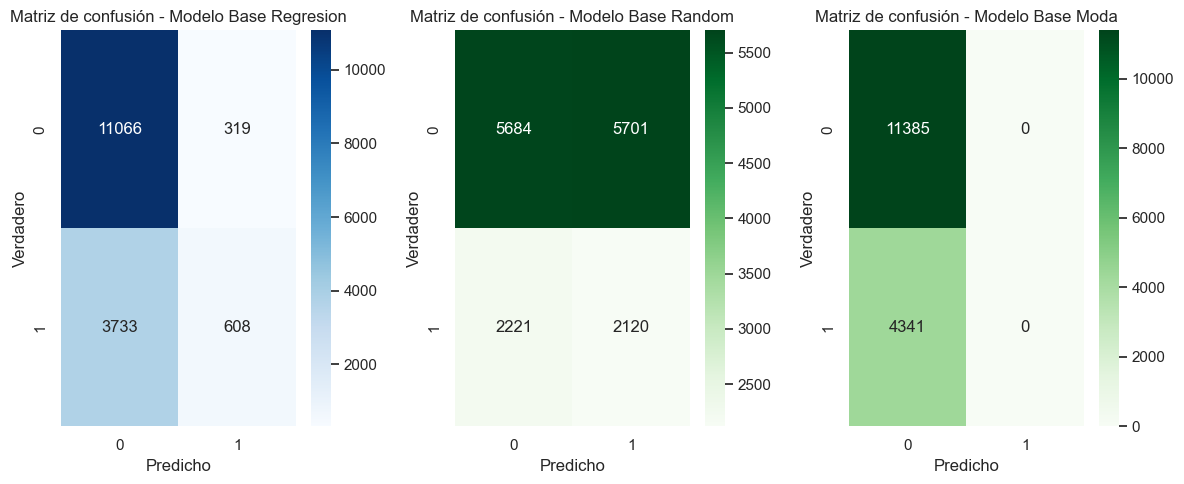

In [92]:
cm_regresion = confusion_matrix(y_train_encoded, y_train_pred_regresion)
randomm = confusion_matrix(y_train_encoded, y_pred_random)
moda = confusion_matrix(y_train_encoded, y_pred_moda)


# Crear subplots para mostrar ambas matrices en una sola fila
fig, axes = plt.subplots(1, 3, figsize=(12, 5))


# Heatmap para la primera matriz de confusión
sns.heatmap(cm_regresion, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de confusión - Modelo Base Regresion")
axes[0].set_xlabel("Predicho")
axes[0].set_ylabel("Verdadero")


# Heatmap para la segunda matriz de confusión
sns.heatmap(randomm, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de confusión - Modelo Base Random")
axes[1].set_xlabel("Predicho")
axes[1].set_ylabel("Verdadero")

# Heatmap para la tercera matriz de confusión
sns.heatmap(moda, annot=True, fmt="d", cmap="Greens", ax=axes[2])
axes[2].set_title("Matriz de confusión - Modelo Base Moda")
axes[2].set_xlabel("Predicho")
axes[2].set_ylabel("Verdadero")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

1. Modelo Base Regresión:
Falsos Positivos: Hubo 319 casos en los que se predijo que iba a llover (1) y no llovió (0). 
Falsos Negativos: Hubo 3733 casos en los que se predijo que no iba a llover (0) y llovió (1).

2. Modelo Base Random:
Falsos Positivos: Hubo 5701 casos en los que se predijo que iba a llover (1) y no llovió (0). 
Falsos Negativos: Hubo 2221 casos en los que se predijo que no iba a llover (0) y llovió (1). 

3. Modelo Base Moda:
Falsos Positivos: Hubo 0 casos en los que se predijo que iba a llover (1) y no llovió (0). 
Falsos Negativos: Hubo 4341 casos en los que se predijo que no iba a llover (0) y llovió (1). 



### Modelo Base por Regresion:
* Accuracy:0.742 para las dos clases, lo que indica un rendimiento mejor que un modelo aleatorio. El modelo es capaz de predecir correctamente el 77% de las instancias en total.

* Precision:0.748 para "No Llueve": El modelo predice correctamente que no llueve el 74.8% de las veces que hace esta predicción. 0.656 para "Llueve": predice correctamente que lloverá el 65.6% de las veces.

* Recall:0.972 para "No Llueve": Detecta correctamente el 97.2% de los casos en los que realmente no llueve. 0.140 para "Llueve": Solo identifica correctamente el 14% de los días en los que realmente llueve, lo que sugiere que el modelo tiene grandes problemas para detectar esta clase.

* F1 Score: 0.845 para "No Llueve": El equilibrio entre precisión y recall para la clase "No Llueve" es bastante bueno. 0.231 para "Llueve": El F1 Score para la clase "Llueve" es extremadamente bajo, lo que confirma la falta de detección de los días de lluvia.

* Recall 2 calses: 0.39. Da cuenta de el pobre rendimiento del modelo a la hora de cumplir el objetivo planteado para el mismo. Esto se debe al bajo recall de la clase Llueve, el cual se le da más importancia a la hora de calcular esta métrica.


### Modelo Base Aleatorio:
* Accuracy: 49.6% de precisión para las dos clases, lo que significa que es apenas mejor que el azar.

* Precision: 0.719 "No Llueve" 0.271 "Llueve". Esto significa que el modelo predice bien el 76.4% de las veces correctamente cuando llueve y un 23.4% cuando no llueve.

* Recall: 0.499 "No Llueve", 0.488 "Llueve". Esto indica que el modelo está capturando el 50.2% de los verdaderos positivos para "No Llueve" y el 49.6% para "Llueve".

* F1 Score: El F1 Score de 0.589 para "No Llueve" y 0.349 para "Llueve" muestra un equilibrio entre precisión y recall, siendo más alto para "No Llueve".

* AUC Roc: 0.494 para las dos clases, lo que muestra que el modelo tiene un muy parecido al azar.

* Recall 2 calses: 0.49. Da cuenta de el pobre rendimiento del modelo a la hora de cumplir el objetivo planteado para el mismo; sin embargo, es mejor que los otros modelos.


### Modelo Base por Moda:
* Accuracy: 0.724 para las dos clases,  El modelo es capaz de predecir correctamente el 76.4% de las instancias en total.

* Precision: 0.724 para "No Llueve" y 0.000 para "Llueve". Esto significa que el modelo predice bien el 76.4% de las veces correctamente cuando llueve y 0% cuando no llueve.

* Recall: 1.000 "No Llueve", 0.000 "Llueve", detecta todos los "No Llueve", pero ningún "Llueve".  Esto indica que el modelo está capturando el 100% de los verdaderos positivos para "No Llueve" y el 0% para "Llueve".

* F1 Score: 0.840 "No Llueve", 0.000 "Llueve", lo que significa que falta de detección para "Llueve".  Indica un buen rendimiento del modelo en la clase "No llueve", reflejando un buen equilibrio entre precisión y recall. Mientras que no detecta en absoluto a cuando "Llueve".

* Recall 2 calses: 0.30. Da cuenta de el pobre rendimiento del modelo a la hora de cumplir el objetivo planteado para el mismo.


### Desempeño del Modelo:

El modelo de regresion tiene un buen desempeño para predecir la clase "No Llueve", con alta precisión, recall y F1 Score, pero es casi incapaz de predecir correctamente los días de "Llueve". Las métricas de precisión, recall y F1 para "Llueve" son todas extremadamente bajas, lo que sugiere que el modelo necesita ser ajustado o mejorado para manejar mejor esta clase minoritaria.

En modelo basado en la moda (que predice siempre "No Llueve"), este modelo también tiene problemas con la detección de los días de lluvia. Aunque tiene un buen rendimiento para la clase mayoritaria, "No Llueve", no predice correctamente ninguno de los días de lluvia.

Y por ultimo podemos notar que el modelo aleatorio tiene un mejor rendimiento para recall_2_clases en comparación a los otros modelos, por lo que se elegiría este como modelo base, en especial para test y val.

### Curvas ROC de los Modelos Base

In [93]:
# Predecir probabilidades usando el pipeline y el conjunto de datos entrenado con la regresion lineal
y_train_probs_regresion = logist_class_regresion.predict_proba(X_train_regresion)[:, 1]

# Calcular la curva ROC y AUC para la clase Llueve
fpr_regresion, tpr_regresion, thresholds_regresion = roc_curve(y_train_encoded, y_train_probs_regresion)
roc_auc_regresion = auc(fpr_regresion, tpr_regresion)

# Curva ROC AUC para la clase No Llueve
fpr_regresion_no_llueve, tpr_regresion_llueve, _ = roc_curve(y_train_encoded, 1 - y_train_probs_regresion)
roc_auc_regresion_no_llueve = auc(fpr_regresion_no_llueve, tpr_regresion_llueve)



In [94]:
# Calcular la curva ROC y AUC para la clase Llueve (basado en predicciones aleatorias)
fpr_random_llueve, tpr_random_llueve, _ = roc_curve(y_train_encoded, y_pred_random)
roc_auc_random_llueve = auc(fpr_random_llueve, tpr_random_llueve)

# Calcular la curva ROC y AUC para la clase No Llueve (invirtiendo las predicciones)
fpr_random_no_llueve, tpr_random_no_llueve, _ = roc_curve(y_train_encoded, 1 - y_pred_random)
roc_auc_random_no_llueve = auc(fpr_random_no_llueve, tpr_random_no_llueve)

In [95]:
# Calcular la curva ROC y AUC para la clase Llueve (usando 1 - y_pred_moda para obtener la otra clase)
fpr_moda_llueve, tpr_moda_llueve, _ = roc_curve(y_train_encoded, y_pred_moda)
roc_auc_moda_llueve = auc(fpr_moda_llueve, tpr_moda_llueve)

# Curva ROC AUC para la clase No Llueve (usando la predicción inversa 1 - moda)
fpr_moda_no_llueve, tpr_moda_no_llueve, _ = roc_curve(y_train_encoded, 1 - np.array(y_pred_moda))
roc_auc_moda_no_llueve = auc(fpr_moda_no_llueve, tpr_moda_no_llueve)


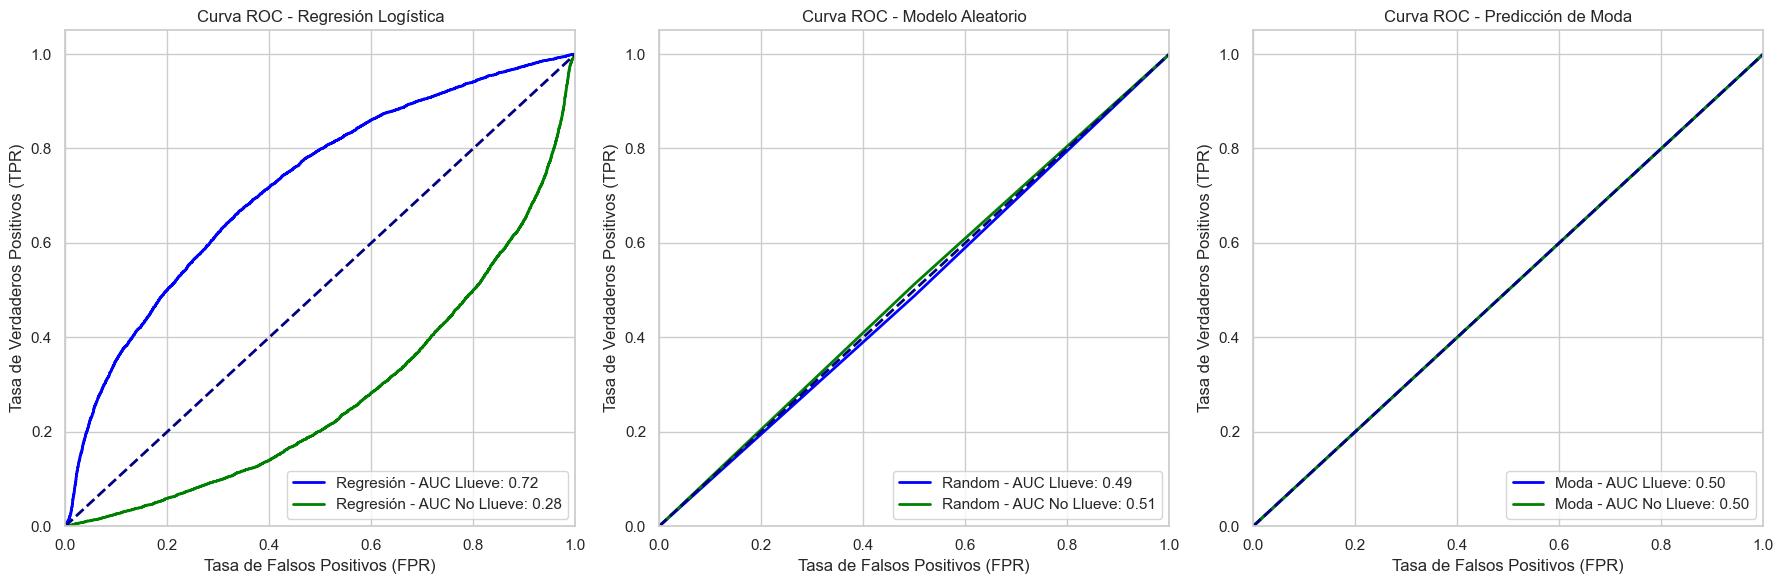

In [96]:
# Graficar las curvas ROC para los tres modelos (moda, random, regresión)
plt.figure(figsize=(18, 6))

# Subplot 1: Curva ROC para el modelo de regresión logística
plt.subplot(1, 3, 1)
plt.plot(fpr_regresion, tpr_regresion, color='blue', lw=2, label=f'Regresión - AUC Llueve: {roc_auc_regresion:.2f}')
plt.plot(fpr_regresion_no_llueve, tpr_regresion_llueve, color='green', lw=2, label=f'Regresión - AUC No Llueve: {roc_auc_regresion_no_llueve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc="lower right")

# Subplot 2: Curva ROC para el modelo aleatorio
plt.subplot(1, 3, 2)
plt.plot(fpr_random_llueve, tpr_random_llueve, color='blue', lw=2, label=f'Random - AUC Llueve: {roc_auc_random_llueve:.2f}')
plt.plot(fpr_random_no_llueve, tpr_random_no_llueve, color='green', lw=2, label=f'Random - AUC No Llueve: {roc_auc_random_no_llueve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Aleatorio')
plt.legend(loc="lower right")

# Subplot 3: Curva ROC para el modelo basado en la moda
plt.subplot(1, 3, 3)
plt.plot(fpr_moda_llueve, tpr_moda_llueve, color='blue', lw=2, label=f'Moda - AUC Llueve: {roc_auc_moda_llueve:.2f}')
plt.plot(fpr_moda_no_llueve, tpr_moda_no_llueve, color='green', lw=2, label=f'Moda - AUC No Llueve: {roc_auc_moda_no_llueve:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Predicción de Moda')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


#### Umbrales para los modelos bases

El umbral estándar de 0.5 en los modelos de clasificación binaria, como la regresión logística, no siempre es el más adecuado. Este valor puede ser ajustado según sean nuestras prioridades del modelo.

Para este caso es recomendable ajustar el umbral para optimizar alguna de estas métricas como el F1-Score, precisión, o recall, según nuestro objetivo del modelo. Esto puede hacerse utilizando la curva ROC/AUC, que nos permite equilibrar entre la tasa de verdaderos positivos y falsos positivos.

En los modelos de predicción de moda y aleatorio, el ajuste de umbral no es aplicable, ya que no generan probabilidades para ajustadar.

En resumen, el umbral de 0.5 es solo un punto de partida para las clasificaciones binarias y no necesariamente el mejor para todos los problemas.

### Fitting Modelos Base Regresion Lineal, Aleatorio y Moda

* El modelo Base de Regresión lineal tiene una AUC 'Llueve'(1) de 0.72 por lo que indica que el modelo tiene la capacidad de diferenciar entre dias de 'Llueve'(1) y dias que 'No llueve'(0). Y tiene una AUC 'No llueve'(0) de 0.28, lo que demuestra que el modelo tiene problemas para detectar esta clase.

* El modelo basado en la aleatoriedad, como era de esperarde devuelve una AUC de casi 0.50 para ambas clases. Lo que significa que este modelo no tiene ningun poder predictivo y no sabe diferenciar entre las dos clases.

* El modelo basado en la moda predice unicamente la clase mayoritaria('No llueve'). Esto muestra la AUC de 0.50 para ambas clases lo que significa que este modelo no tiene ningun poder predictivo y no sabe diferenciar entre las dos clases.


# Punto 4

### Optimización de parámetros

En la regresión logística, varios hiperparámetros pueden ser optimizados para mejorar el rendimiento del modelo. Aquí hay algunos de los más comunes:

- C (inversa de la regularización): Este hiperparámetro controla la regularización en el modelo. Un valor más pequeño de 𝐶 implica más regularización (menos complejidad del modelo), mientras que un valor más grande significa menos regularización.
- penalty (tipo de regularización): Puede ser 'l1' (Lasso), 'l2' (Ridge) o 'elasticnet' (combinación de L1 y L2). La regularización ayuda a prevenir el sobreajuste al penalizar coeficientes grandes.
- max_iter (número máximo de iteraciones): Establece el número máximo de iteraciones para el algoritmo de optimización. Aumentar este número puede ayudar si el modelo no converge.
- class_weight: Permite ajustar el peso de las clases en problemas de clasificación desbalanceada. Puede ser 'balanced' o un diccionario que especifique pesos para cada clase.

In [97]:
# Definir el espacio de hiperparámetros
param_random = {
    'C': np.logspace(-5, 5, num=100),  # Valores de C en escala logarítmica
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': range(100, 2000),  # 1000 es el valor máximo incluido
    'class_weight': ['balanced', None]
}

In [98]:
# Definir el espacio de hiperparámetros
param_grid = {
    'C': np.logspace(-5, 5, num=100),  # Valores de C en escala logarítmica
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': range(500, 1001),  # 1000 es el valor máximo incluido
    'class_weight': ['balanced', None]
}

### K-folds

In [99]:
# Definir el modelo
modelo = LogisticRegression()
scaler_robust = RobustScaler()
X_val_encoded_sc = scaler_robust.fit_transform(X_val_encoded,y_val_encoded)
X_test_encoded_sc = scaler_robust.transform(X_test_encoded)
# Configurar la validación cruzada k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [100]:
X_val_encoded_sc = scaler_robust.fit_transform(X_val_encoded,y_val_encoded)
X_test_encoded_sc = scaler_robust.transform(X_test_encoded)

### GridSearch

In [101]:
from sklearn.metrics import make_scorer, f1_score, recall_score

In [102]:
# #Utilizamos GridSearchCV para encontrar la mejor combinación de hiperparámetros
# grid_search = GridSearchCV(
#     estimator=modelo,
#     param_grid=param_grid,
#     scoring=make_scorer(recall_score, average='binary'),  # Usamos F1-score para balancear precisión y sensibilidad
#     cv=kf,  # Validación cruzada con 5 folds
#     n_jobs= -1
# )

# # Reducimos el tamaño del conjunto de datos para la búsqueda de hiperparámetros (por ejemplo, usamos solo el 30% de los datos)
# X_sample =X_train_encoded.sample(frac=0.3, random_state=42)
# y_sample = y_train_encoded.loc[X_sample.index]

# # Ajustar el modelo con la muestra reducida
# grid_search.fit(X_sample, y_sample)


# # Obtener los mejores hiperparámetros
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Mejores hiperparámetros encontrados:", best_params)


In [103]:
# trials_grid = grid_search.cv_results_
# plot_params_trials(trials_grid, 'Grid')

Se decidio reducir el conjunto de datos, porque si no la ejecucion no terminaba nunca. Lo maximo que llegue a esperar fueron 11 minutos

### Random Search

In [104]:
# Configurar Random Search
random_search = RandomizedSearchCV(
    estimator=modelo,
    param_distributions=param_random,
    n_iter=100,  # Número de combinaciones a probar
    scoring=make_scorer(recall_2_clases, greater_is_better=True),
    cv=kf,
    n_jobs=-1,
    #random_state=42
)

# Ajustar el modelo a los datos de entrenamiento
random_search.fit(X_val_resampled, y_val_resampled)

# Obtener los mejores hiperparámetros
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Obtener el mejor F1 score encontrado durante el ajuste
best_recall_score_random = random_search.best_score_

print("Mejores hiperparámetros encontrados:", best_params_random)
print("Mejor Recall 2 clases:", best_recall_score_random)

Mejores hiperparámetros encontrados: {'penalty': 'l2', 'max_iter': 1894, 'class_weight': None, 'C': 0.0013219411484660286}
Mejor Recall 2 clases: 0.8034029112918584


### Grafico de Random Search

In [105]:
trials_random = random_search.cv_results_

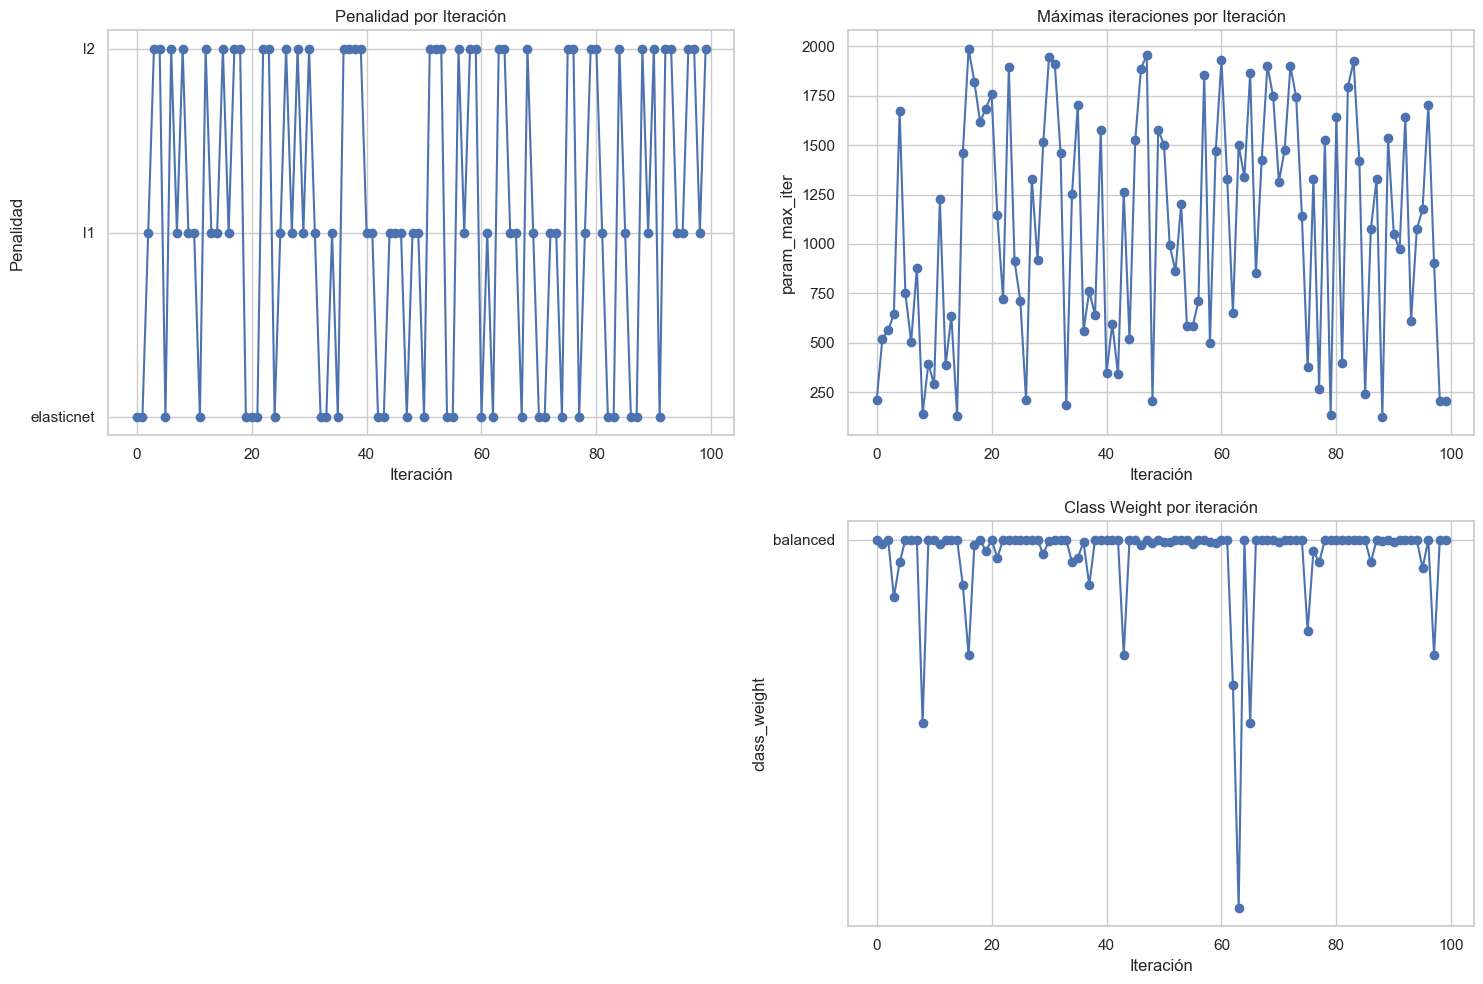

In [106]:
plot_params_trials(trials_random)

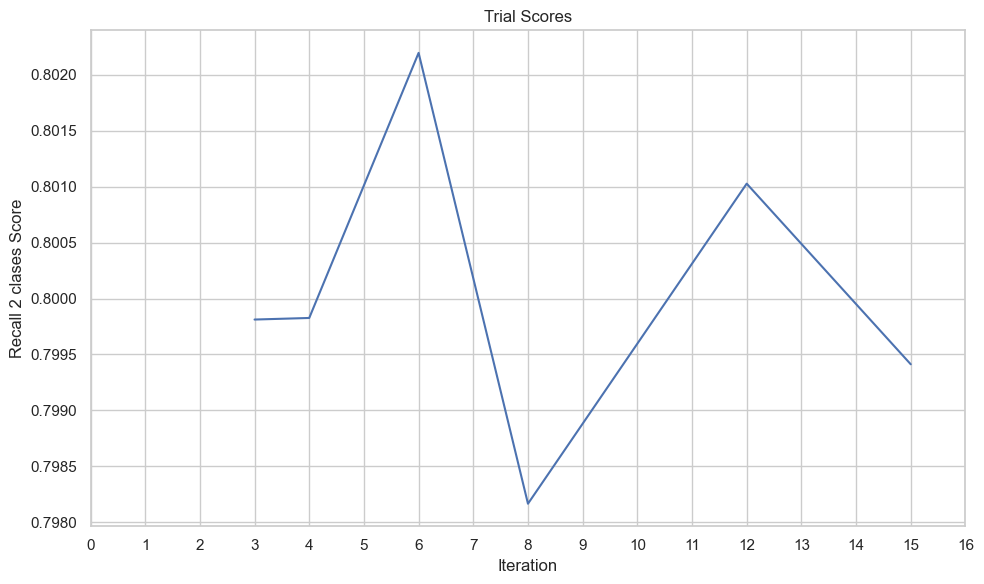

Iteration  \
0           0   
1           1   
2           2   
3           3   
4           4   
5           5   
6           6   
7           7   
8           8   
9           9   
10         10   
11         11   
12         12   
13         13   
14         14   
15         15   
16         16   

                                                                                            Params  \
0   {'C': 2.848035868435799, 'penalty': 'elasticnet', 'max_iter': 209, 'class_weight': 'balanced'}   
1        {'C': 1204.5035402587837, 'penalty': 'elasticnet', 'max_iter': 521, 'class_weight': None}   
2         {'C': 0.22051307399030456, 'penalty': 'l1', 'max_iter': 564, 'class_weight': 'balanced'}   
3                {'C': 15556.761439304722, 'penalty': 'l2', 'max_iter': 644, 'class_weight': None}   
4                {'C': 6135.907273413163, 'penalty': 'l2', 'max_iter': 1673, 'class_weight': None}   
5       {'C': 0.00210490414451202, 'penalty': 'elasticnet', 'max_iter': 753, 'class_weight': None}   
6                {'C': 1.4174741629268048, 'penalty': 'l2', 'max_iter': 503, 'class_weight': None}   
7      {'C': 0.00041320124001153346, 'penalty': 'l1', 'max_iter': 880, 'class_weight': 'balanced'}   
8                 {'C': 49770.23564332114, 'penalty': 'l2', 'max_iter': 140, 'class_weight': None}   
9                {'C': 148.49682622544634, 'penalty': 'l1', 'max_iter': 394, 'class_weight': None}   
10         {'C': 0.1747528400007683, 'penalty': 'l1', 'max_iter': 289, 'class_weight': 'balanced'}   
11      {'C': 1204.5035402587837, 'penalty': 'elasticnet', 'max_iter': 1226, 'class_weight': None}   
12               {'C': 0.8902150854450392, 'penalty': 'l2', 'max_iter': 385, 'class_weight': None}   
13           {'C': 0.00032745491628777284, 'penalty': 'l1', 'max_iter': 636, 'class_weight': None}   
14         {'C': 1.1233240329780265, 'penalty': 'l1', 'max_iter': 131, 'class_weight': 'balanced'}   
15              {'C': 12328.467394420633, 'penalty': 'l2', 'max_iter': 1463, 'class_weight': None}   
16         {'C': 31257.15849688235, 'penalty': 'l1', 'max_iter': 1988, 'class_weight': 'balanced'}   

    Recall 2 clases Score  
0                     NaN  
1                     NaN  
2                     NaN  
3                0.799812  
4                0.799826  
5                     NaN  
6                0.802195  
7                     NaN  
8                0.798166  
9                     NaN  
10                    NaN  
11                    NaN  
12               0.801027  
13                    NaN  
14                    NaN  
15               0.799412  
16                    NaN

In [107]:
plot_trials(trials_random, 'Recall 2 clases', 'random')

## Optuna

In [108]:
from sklearn.model_selection import KFold, cross_val_predict

In [109]:
def objective(trial):
    # Definir el espacio de búsqueda para los hiperparámetros
    C = trial.suggest_loguniform('C', 1e-5, 1e5)  # Rango amplio para C
    penalty = trial.suggest_categorical('penalty', ['l2'])  # Solo l2 en este caso
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 100, 2000)  # Rango para max_iter

    # Crear el modelo con los hiperparámetros sugeridos
    modelo_optuna = LogisticRegression(C=C, penalty=penalty, class_weight=class_weight, max_iter=max_iter)

    # Validación cruzada con predicciones
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    preds = cross_val_predict(modelo_optuna, X_val_resampled, y_val_resampled, cv=kf, method='predict')

    # Calcular la métrica personalizada
    mean_recall = recall_2_clases(y_val_resampled, preds)

    # Mostrar el progreso del trial
    print(f"Trial {trial.number}: recall={mean_recall:.4f}, C={C}, penalty={penalty}, class_weight={class_weight}, max_iter={max_iter}")

    return mean_recall

# Crear un estudio de Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) #cambiar a 60 trials

# Obtener los mejores hiperparámetros y resultados
best_params_optuna = study.best_params
best_value_optuna = study.best_value

print("Mejores hiperparámetros encontrados:", best_params_optuna)
print("Mejor recall:", best_value_optuna)


[I 2024-12-11 08:20:07,920] A new study created in memory with name: no-name-c763249b-b22c-4927-a383-390ae2abb396
[I 2024-12-11 08:20:12,314] Trial 0 finished with value: 0.7996755725190838 and parameters: {'C': 17541.637864119442, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1155}. Best is trial 0 with value: 0.7996755725190838.


Trial 0: recall=0.7997, C=17541.637864119442, penalty=l2, class_weight=None, max_iter=1155


[I 2024-12-11 08:20:17,780] Trial 1 finished with value: 0.7988931297709922 and parameters: {'C': 52463.33885120595, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1478}. Best is trial 0 with value: 0.7996755725190838.


Trial 1: recall=0.7989, C=52463.33885120595, penalty=l2, class_weight=balanced, max_iter=1478


[I 2024-12-11 08:20:22,797] Trial 2 finished with value: 0.7994656488549617 and parameters: {'C': 0.05196624081647182, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1343}. Best is trial 0 with value: 0.7996755725190838.


Trial 2: recall=0.7995, C=0.05196624081647182, penalty=l2, class_weight=None, max_iter=1343


[I 2024-12-11 08:20:23,245] Trial 3 finished with value: 0.7969274809160306 and parameters: {'C': 361.6768221341112, 'penalty': 'l2', 'class_weight': None, 'max_iter': 113}. Best is trial 0 with value: 0.7996755725190838.


Trial 3: recall=0.7969, C=361.6768221341112, penalty=l2, class_weight=None, max_iter=113


[I 2024-12-11 08:20:28,348] Trial 4 finished with value: 0.7995801526717556 and parameters: {'C': 0.08982277990676178, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1207}. Best is trial 0 with value: 0.7996755725190838.


Trial 4: recall=0.7996, C=0.08982277990676178, penalty=l2, class_weight=balanced, max_iter=1207


[I 2024-12-11 08:20:33,747] Trial 5 finished with value: 0.7941984732824428 and parameters: {'C': 0.0002811854257807467, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1866}. Best is trial 0 with value: 0.7996755725190838.


Trial 5: recall=0.7942, C=0.0002811854257807467, penalty=l2, class_weight=None, max_iter=1866


[I 2024-12-11 08:20:36,575] Trial 6 finished with value: 0.8018702290076336 and parameters: {'C': 0.007014709513805415, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 654}. Best is trial 6 with value: 0.8018702290076336.


Trial 6: recall=0.8019, C=0.007014709513805415, penalty=l2, class_weight=balanced, max_iter=654


[I 2024-12-11 08:20:43,184] Trial 7 finished with value: 0.801030534351145 and parameters: {'C': 0.011210805335339837, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1660}. Best is trial 6 with value: 0.8018702290076336.


Trial 7: recall=0.8010, C=0.011210805335339837, penalty=l2, class_weight=None, max_iter=1660


[I 2024-12-11 08:20:47,263] Trial 8 finished with value: 0.7990076335877861 and parameters: {'C': 483.86277239446855, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1081}. Best is trial 6 with value: 0.8018702290076336.


Trial 8: recall=0.7990, C=483.86277239446855, penalty=l2, class_weight=balanced, max_iter=1081


[I 2024-12-11 08:20:52,863] Trial 9 finished with value: 0.7992557251908396 and parameters: {'C': 22.609314847212598, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1535}. Best is trial 6 with value: 0.8018702290076336.


Trial 9: recall=0.7993, C=22.609314847212598, penalty=l2, class_weight=None, max_iter=1535
Mejores hiperparámetros encontrados: {'C': 0.007014709513805415, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 654}
Mejor recall: 0.8018702290076336


In [110]:
trials_optuna = study.trials
C = [trial.params['C'] for trial in trials_optuna]

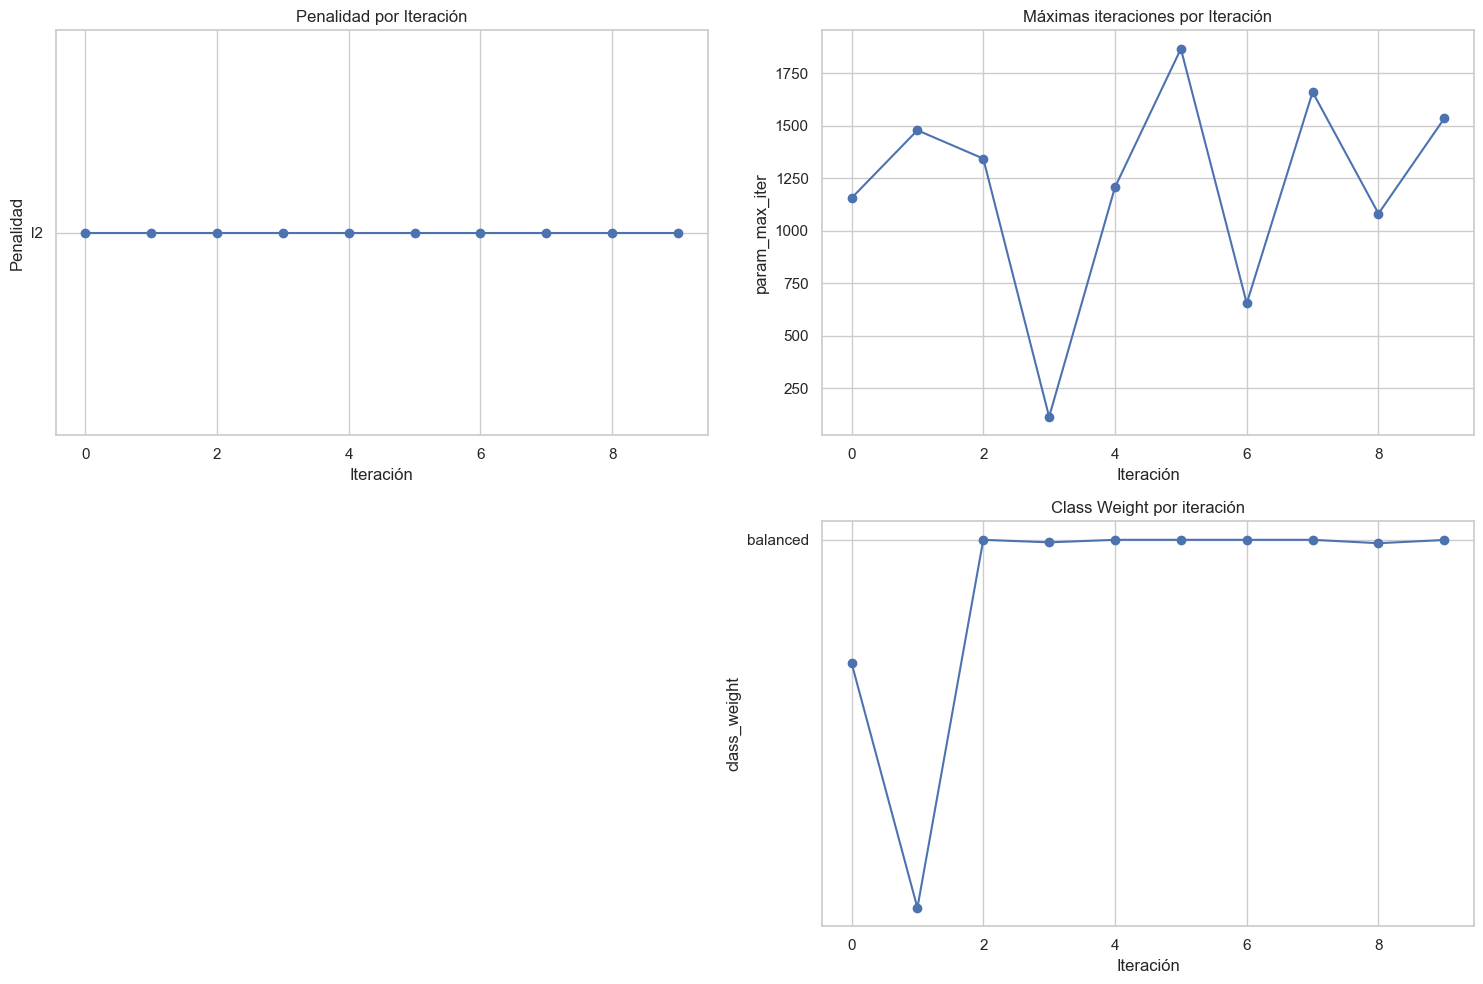

In [111]:
plot_params_trials(trials_optuna, 'Optuna')

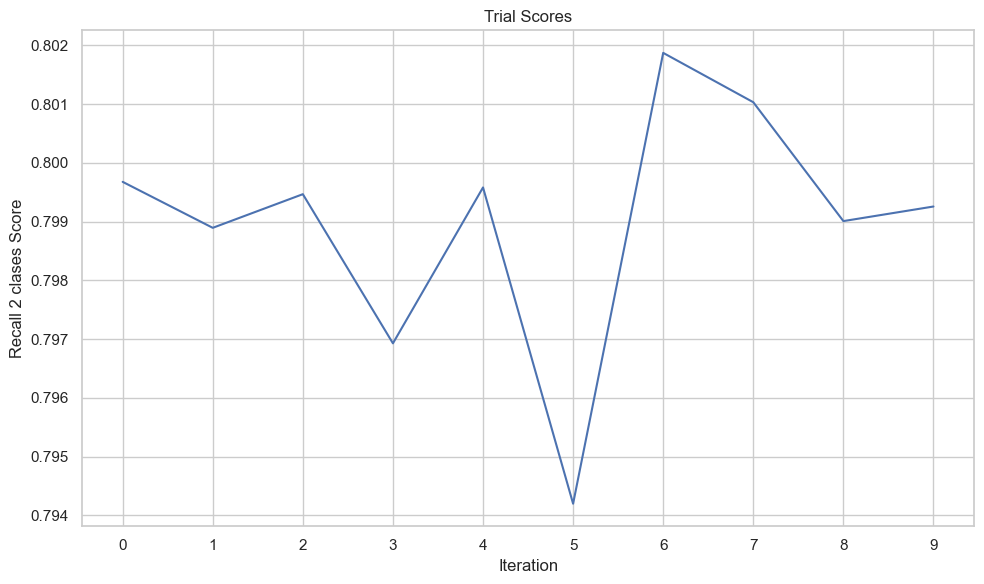

Iteration  \
0          0   
1          1   
2          2   
3          3   
4          4   
5          5   
6          6   
7          7   
8          8   
9          9   

                                                                                      Params  \
0         {'C': 17541.637864119442, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1155}   
1    {'C': 52463.33885120595, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1478}   
2        {'C': 0.05196624081647182, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1343}   
3           {'C': 361.6768221341112, 'penalty': 'l2', 'class_weight': None, 'max_iter': 113}   
4  {'C': 0.08982277990676178, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1207}   
5      {'C': 0.0002811854257807467, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1866}   
6  {'C': 0.007014709513805415, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 654}   
7       {'C': 0.011210805335339837, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1660}   
8   {'C': 483.86277239446855, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 1081}   
9         {'C': 22.609314847212598, 'penalty': 'l2', 'class_weight': None, 'max_iter': 1535}   

   Recall 2 clases Score  
0               0.799676  
1               0.798893  
2               0.799466  
3               0.796927  
4               0.799580  
5               0.794198  
6               0.801870  
7               0.801031  
8               0.799008  
9               0.799256

In [112]:
# Llama a la función con tus datos
plot_trials(trials_optuna, 'Recall 2 clases', 'optuna')

Luego de usar y analizar estas 3 tecnicas de optimizacion de hiperparametros, podemos decir que:
* **Grid Search** no nos conviene, pues este mismo se usa cuando hay un espacio de hiperparametros mas pequeños, y cuando se busca una solucion rapida, el cual no es nuestro caso.
* **Random Search** es mas eficiente, pues puede encontrar buenas combinacines mas rapido que Grid Search. Péro una de sus desventajas es que no garantiza que se evaluen todas las combinaciones, por lo que puede llegar a pasar por alto la mejor configuracion.
* Y por ultimo **Optuna**, la cual utiliza un enfoque mucho mas inteligente para explorar el espacio de hiperparametros, lo que resulta en una optimizacion mas rapida y efectiva. Otra ventaja es que tiene un manejo de espacio complejos efectivo.

Entonces la tecnica de optimizacion de hiperparametros que mas nos conviene usar es **Optuna**

Los hiperparametros a optimizar son los siguientes:
- **`n_estimators`**: Número de árboles en el bosque. Aumentar este número puede mejorar la precisión, pero también incrementa el tiempo de entrenamiento. En nuestro caso, el valor mas optimo seria alrededor de los 120-170, el cual es un rango comun.

- **`max_depth`**: Profundidad máxima de los árboles. Limitar la profundidad puede ayudar a prevenir el sobreajuste. En nuestro caso, el valor mas optimo suele ser None, o oscila entre 10-30.

- **`min_samples_split`**: Número mínimo de muestras necesarias para dividir un nodo. Aumentar este valor puede ayudar a prevenir el sobreajuste. En nuestro caso el valor mas optimo estaria entre 5-10.

- **`min_samples_leaf`**: Número mínimo de muestras que debe tener un nodo hoja. Esto también puede ayudar a prevenir el sobreajuste. En nuestro caso el valor mas optimo estaria entre 1-5.

In [113]:
best_value_optuna , best_params_optuna

(0.8018702290076336,
 {'C': 0.007014709513805415,
  'penalty': 'l2',
  'class_weight': 'balanced',
  'max_iter': 654})

In [114]:
random_search.best_score_, best_params_random

(0.8034029112918584,
 {'penalty': 'l2',
  'max_iter': 1894,
  'class_weight': None,
  'C': 0.0013219411484660286})

# Modelo con mejores Hiperparámetros para Recall 2 Clases

In [115]:
C_op = best_params_optuna['C']
class_w = best_params_optuna['class_weight']
max_iters = best_params_optuna['max_iter']

best_model_optuna = make_pipeline(RobustScaler(), LogisticRegression(penalty = 'l2', max_iter = max_iters, C= C_op,class_weight =class_w))


In [116]:
best_model_optuna.fit(X_resampled, y_resampled)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.007014709513805415,
                                    class_weight='balanced', max_iter=654))])

In [117]:
y_train_pred_ov_optuna = best_model_optuna.predict(X_resampled)
y_val_pred_ov_optuna = best_model_optuna.predict(X_val_resampled)
y_test_pred_ov_optuna = best_model_optuna.predict(X_test_encoded)

In [118]:
metricas_reg_logistica = pd.concat([metricas_reg_logistica,metricas(
    {'Regresión Logística Oversampled optimizada':[
     [X_resampled,X_val_resampled,X_test_encoded],
     (y_resampled, y_train_pred_ov_optuna),
     (y_val_resampled, y_val_pred_ov_optuna),
     (y_test_encoded, y_test_pred_ov_optuna)
     ]},
     best_model_optuna

)])

In [119]:
metricas_reg_logistica

Nombre Modelo  \
Regresion Logistica Weighted                              Regresion Logistica Weighted   
Regresion Logistica Balanced                              Regresion Logistica Balanced   
Regresion Logistica Oversampled                        Regresion Logistica Oversampled   
Regresión Logística Oversampled optimizada  Regresión Logística Oversampled optimizada   

                                            Accuracy Train  \
Regresion Logistica Weighted                      0.817373   
Regresion Logistica Balanced                      0.781826   
Regresion Logistica Oversampled                   0.778480   
Regresión Logística Oversampled optimizada        0.776285   

                                            Recall 2 clases Train  \
Regresion Logistica Weighted                             0.663959   
Regresion Logistica Balanced                             0.774419   
Regresion Logistica Oversampled                          0.775143   
Regresión Logística Oversampled optimizada               0.773087   

                                            Precision Llueve Train  \
Regresion Logistica Weighted                              0.719058   
Regresion Logistica Balanced                              0.578883   
Regresion Logistica Oversampled                           0.783207   
Regresión Logística Oversampled optimizada                0.780773   

                                            Recall Llueve Train  \
Regresion Logistica Weighted                           0.555402   
Regresion Logistica Balanced                           0.769178   
Regresion Logistica Oversampled                        0.770136   
Regresión Logística Oversampled optimizada             0.768292   

                                            F1-Score Llueve Train  \
Regresion Logistica Weighted                             0.626722   
Regresion Logistica Balanced                             0.660599   
Regresion Logistica Oversampled                          0.776616   
Regresión Logística Oversampled optimizada               0.774482   

                                            AUC-ROC Llueve Train  \
Regresion Logistica Weighted                            0.860877   
Regresion Logistica Balanced                            0.861105   
Regresion Logistica Oversampled                         0.864909   
Regresión Logística Oversampled optimizada              0.861822   

                                            Precision No Llueve Train  \
Regresion Logistica Weighted                                 0.844015   
Regresion Logistica Balanced                                 0.899377   
Regresion Logistica Oversampled                              0.773909   
Regresión Logística Oversampled optimizada                   0.771937   

                                            Recall No Llueve Train  \
Regresion Logistica Weighted                              0.917260   
Regresion Logistica Balanced                              0.786649   
Regresion Logistica Oversampled                           0.786825   
Regresión Logística Oversampled optimizada                0.784278   

                                            F1-Score No Llueve Train  ...  \
Regresion Logistica Weighted                                0.879114  ...   
Regresion Logistica Balanced                                0.839245  ...   
Regresion Logistica Oversampled                             0.780314  ...   
Regresión Logística Oversampled optimizada                  0.778059  ...   

                                            Accuracy Test  \
Regresion Logistica Weighted                     0.557059   
Regresion Logistica Balanced                     0.431013   
Regresion Logistica Oversampled                  0.558661   
Regresión Logística Oversampled optimizada       0.714082   

                                            Recall 2 clases Test  \
Regresion Logistica Weighted                            0.691300   
Regresion Logistica Balanced                  

Vemos que el modelo optimizado, si bien tiene por poco una peor métrica en train, no es así en test donde supera a los otros modelos, aunque por un pequeño margen.

# Punto 5

In [120]:
# from sklearn.metrics import classification_report
import shap

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
np.random.seed(10)
shap.initjs()

In [123]:
model_random = make_pipeline(RobustScaler(), best_model_random)

In [124]:
model_random

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0013219411484660286, max_iter=1894))])

In [125]:
model_random.fit(X_train_encoded,y_train_encoded)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0013219411484660286, max_iter=1894))])

In [126]:
explainer = shap.Explainer(
    best_model_random, X_train_encoded, feature_names=list(X_train_encoded.columns)
)
shap_values = explainer(X_test_encoded)

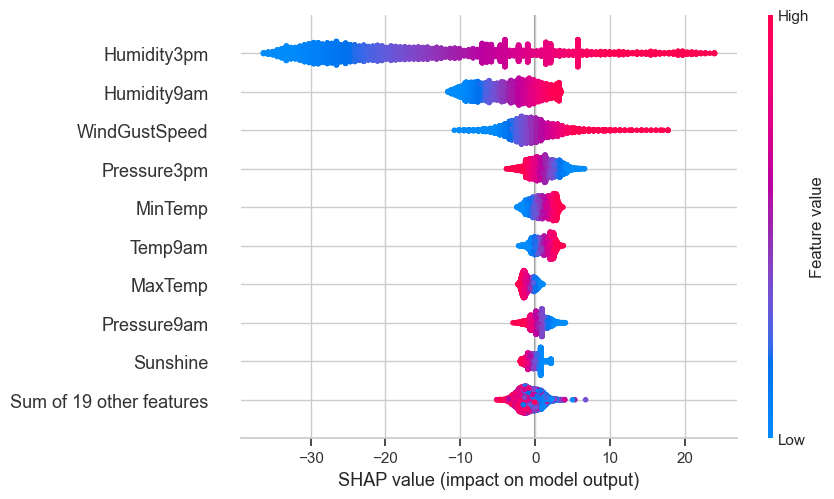

In [127]:
shap.plots.beeswarm(shap_values)

Podemos observar que 'Humedad' es la variable que mayor influencia tiene en el modelo ya que a mayor valor, mayor probabilidad hay de que llueva y, caso contrario, de que no llueva. Lo mismo sucede con la variable 'WindGustSpeed'.
Con variables como 'Preassure' sucede lo contrario, a mayor valores tira más a que no llueva y a menor, a que llueva.1

In [128]:
ind_1 = 0
shap.initjs()
shap.plots.force(shap_values[ind_1])

Se puede ver en este caso, donde la humedad es baja, junto con la velocidad del viento (que también lo es), que da como resultado 'No Lluve' ya que estas dos variables con estos valores están restando mucho a que llueva.

In [129]:
print('Llueve.' if y_test_encoded.iloc[ind_1] == 1 else 'No llueve.', 'Caso:')
X_test.iloc[ind_1]

No llueve. Caso:


Location         Launceston
MinTemp                 4.3
MaxTemp                17.4
Rainfall                0.0
Evaporation             2.2
Sunshine                6.0
WindGustDir              NW
WindGustSpeed          24.0
WindDir9am              WNW
WindDir3pm               NW
WindSpeed9am            0.0
WindSpeed3pm           13.0
Humidity9am            92.0
Humidity3pm            57.0
Pressure9am          1019.1
Pressure3pm          1016.9
Cloud9am                8.0
Cloud3pm                7.0
Temp9am                 8.0
Temp3pm                16.4
RainToday                No
Day_of_Year             240
Name: 135038, dtype: object

In [130]:
ind_2 = 4
shap.initjs()
shap.plots.force(shap_values[ind_2])

En este otro caso, donde la humedad y el viento tienen valores más altos, y además las variables que restan a que llueva tienen pesos pequeños, da como resultado la predicción de 'Lluvia'.

In [131]:
print('Llueve.' if y_test_encoded.iloc[ind_2] == 1 else 'No llueve.', 'Caso:')
X_test.iloc[ind_2]

Llueve. Caso:


Location         Launceston
MinTemp                 8.3
MaxTemp                13.8
Rainfall                0.4
Evaporation             3.0
Sunshine                6.9
WindGustDir              SE
WindGustSpeed          50.0
WindDir9am              NNW
WindDir3pm              NNW
WindSpeed9am            7.0
WindSpeed3pm           19.0
Humidity9am            87.0
Humidity3pm            93.0
Pressure9am          1018.0
Pressure3pm          1015.8
Cloud9am                8.0
Cloud3pm                8.0
Temp9am                12.8
Temp3pm                12.3
RainToday                No
Day_of_Year             244
Name: 135042, dtype: object

# Punto 6. AutoML

### Utilizamos **pycaret** para resolver este problema

In [132]:
import pycaret
from pycaret.classification import *

Volvemos a leer el archivo y nos quedamos con las ciudades seleccionadas al principio del trabajo

In [133]:
data_pyc = pd.read_csv('src\weatherAUS.csv', sep = ',')
# Filtrmos el DataFrame para quedarnos solo con las ciudades seleccionadas en el punto 1
data_pyc = data_pyc[data_pyc['Location'].isin(selected_cities)]
data_pyc = data_pyc.dropna(subset=['RainTomorrow']) #Borramos los que tienen la variable objetivo nula

### Corremos los elementos de pycaret para poder comparar entre los modelos para saber cual arroja mejores metricas

In [134]:
# Configurar PyCaret
clf1 = setup(
    data=data_pyc,  
    target='RainTomorrow',  # variable objetivo
    train_size=0.8,
    session_id=42,
    verbose=True
)

# Agregar la métrica personalizada al sistema de PyCaret
add_metric(
    id="recall_2_clases", 
    name="Recall 2 clases",  
    score_func=recall_2_clases,  
    greater_is_better=True  
    )

# Comparar modelos utilizando la métrica personalizada
best_model = compare_models(sort='recall_2_clases')

Podemos obresrvar que la libreria PyCaret realiza automáticamente la preparación de datos, incluyendo la imputación de valores nulos y la codificación de variables categóricas. Esto simplifica y acelera el flujo de trabajo, permitiendo enfocarse en la selección y evaluación de modelos.

Comparación de Múltiples Modelos: compare_models() entrena y evalúa varios algoritmos de clasificación, proporcionando una tabla de métricas como Accuracy, AUC, Recall, F1, entre otras, para cada modelo. Además incluímos nuestra métrica de interés "recall 2 clases". Esta función ayuda a identificar rápidamente qué modelo tiene el mejor rendimiento en la métrica de interés.

En la tabla de resultados, se observa que el modelo Extra Trees Classifier tiene el mejor rendimiento en precisión y otras métricas, sin embargo no tiene buena métrica en "recall 2 clases", lo que sugiere que, si bien el recall de la clase 1 es alto, debe estar elevando el mismo a costa de disminuir el recall de la clase 0. 

Esto no se evidencia en "Quadratic Discriminant Analysis" el cual, si bien da peor en las otras métricas en comparación al modelo anterior, en nuestra métrica de interés da el mejor valor (0.72)

En resumen, PyCaret proporciona herramientas útiles para el preprocesamiento, comparación de modelos y análisis de métricas.

En este caso nos seleccionamos 'Quadratic Discriminant Analysis' que es aquel que tiene la mejor métrica en "Recall 2 clases", la cual es la que nos interesa y la que estamos utilizando para comparar modelos.

### Matriz de confusión

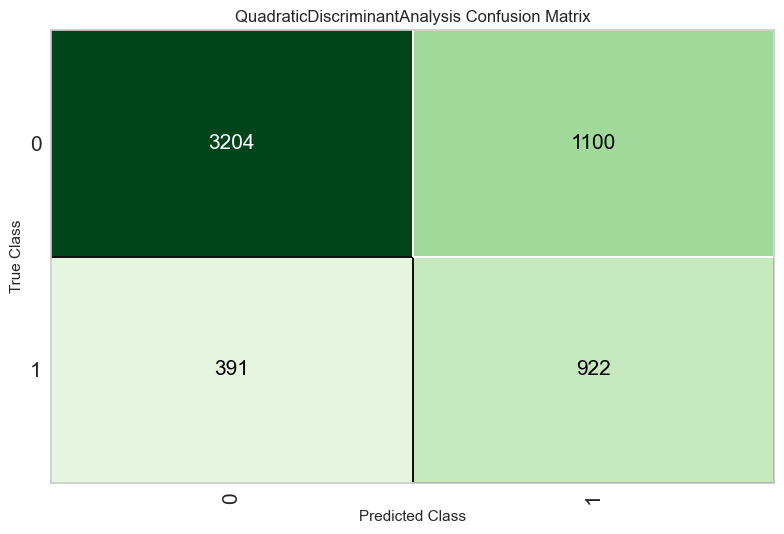

In [135]:
plot_model(best_model, plot = 'confusion_matrix')

En esta matriz de confusión y basado en las metricas que arroja este modelo, podemos ver que tiene un gran porcentaje de dias predichos en caso de que llueva

### Curva ROC

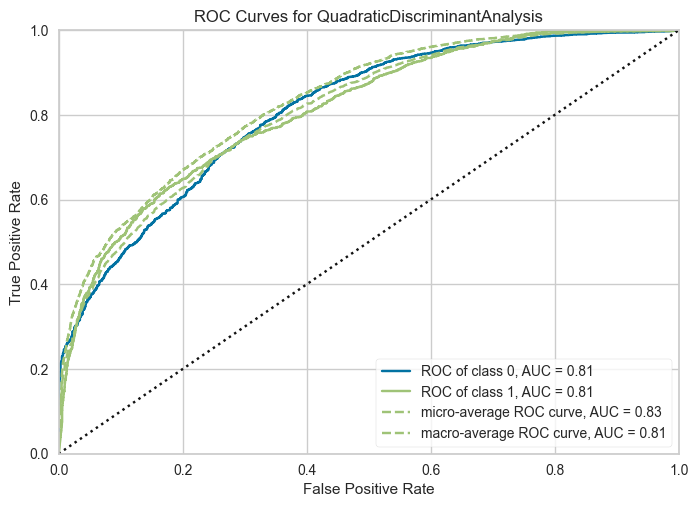

In [136]:
plot_model(best_model, plot = 'auc')

El gráfico muestra las curvas ROC de el modelo Quadratic Discriminant Analysis. 
* Las curvas para cada clase tienen un AUC de 0.81, indicando una buena capacidad de clasificación individual. 
* La curva micro-averaged tiene un AUC de 0.83, refleja un rendimiento elevado al considerar todas las instancias en conjunto. 
* La curva macro-averaged (AUC = 0.81) muestra un rendimiento promedio por clase.

Micro-average:
Considera cada instancia de cada clase individualmente, sin importar la clase a la que pertenece.
Calcula el rendimiento acumulando los verdaderos positivos, falsos positivos y falsos negativos de todas las clases y luego genera la curva ROC.
Es útil cuando se quiere evaluar el rendimiento general del modelo, especialmente si tenemos clases desbalanceadas, ya que da más peso a las clases con más ejemplos.

Macro-average:
Calcula la curva ROC y el AUC de cada clase individualmente y luego hace el promedio de esos valores.
Da igual peso a cada clase, sin importar su tamaño.
Es útil para ver el rendimiento medio del modelo en todas las clases, pero puede no reflejar bien el rendimiento general si las clases están desbalanceadas.

### Gráfico de Importancia de Características

El modelo Quadratic Discriminant Analysis no permite este tipo de análisis.

### Guardamos el modelo

In [137]:
save_model(best_model, 'pipeline_auto_ml')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['MinTemp', 'MaxTemp', 'Rainfall',
                                              'Evaporation', 'Sunshine',
                                              'WindGustSpeed', 'WindSpeed9am',
                                              'WindSpeed3pm', 'Humidity9am',
                                              'Humidity3pm', 'Pressure9...
                  TransformerWrapper(exclude=None, include=['Date'],
                                     transformer=TargetEncoder(cols=['Date'],
                                                               drop_invariant=False,
                                                               h

In [138]:
loaded_best_pipeline = load_model('pipeline_auto_ml')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\julil\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['MinTemp', 'MaxTemp', 'Rainfall',
                                             'Evaporation', 'Sunshine',
                                             'WindGustSpeed', 'WindSpeed9am',
                                             'WindSpeed3pm...
                 TransformerWrapper(exclude=None, include=['Date'],
                                    transformer=TargetEncoder(cols=['Date'],
                                                              drop_invariant=False,
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              hierarchy=None,
                                                              min_samples_leaf=20,
                                                              return_df=True,
                                                              smoothing=10,
                                                              verbose=0))),
                ('trained_model',
                 QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                                               store_covariance=False,
                                               tol=0.0001))],
         verbose=False)

# PUNTO 7

In [139]:
X_test.iloc[0]

Location         Launceston
MinTemp                 4.3
MaxTemp                17.4
Rainfall                0.0
Evaporation             2.2
Sunshine                6.0
WindGustDir              NW
WindGustSpeed          24.0
WindDir9am              WNW
WindDir3pm               NW
WindSpeed9am            0.0
WindSpeed3pm           13.0
Humidity9am            92.0
Humidity3pm            57.0
Pressure9am          1019.1
Pressure3pm          1016.9
Cloud9am                8.0
Cloud3pm                7.0
Temp9am                 8.0
Temp3pm                16.4
RainToday                No
Day_of_Year             240
Name: 135038, dtype: object

In [140]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.metrics import Recall
import tensorflow as tf

In [141]:
scaler = RobustScaler()
X_train_escaled = scaler.fit_transform(X_resampled)
X_val_escaled = scaler.transform(X_val_resampled)
X_test_escaled = scaler.transform(X_test_encoded)

with open('Docker/scalers.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

Primero debemos convertir las etiquetas a codificacion categorica, ya que este es un problema multiclase

Definimos el modelo de red neuronal

In [142]:
import tensorflow as tf

class CustomRecallMetric(tf.keras.metrics.Metric):
    def __init__(self, name="custom_recall_metric", threshold=0.5, **kwargs):
        """
        Métrica personalizada para calcular un recall ponderado entre dos clases, con un umbral ajustable.

        Parameters:
        - name: Nombre de la métrica.
        - threshold: Umbral para convertir las predicciones en valores binarios.
        """
        super(CustomRecallMetric, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        # Variables para las métricas de clase 0 y 1
        self.true_positives_0 = self.add_weight(name="tp0", initializer="zeros")
        self.false_negatives_0 = self.add_weight(name="fn0", initializer="zeros")
        self.true_positives_1 = self.add_weight(name="tp1", initializer="zeros")
        self.false_negatives_1 = self.add_weight(name="fn1", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Actualiza el estado interno de la métrica con los valores reales y predichos.

        Parameters:
        - y_true: Tensor de etiquetas reales.
        - y_pred: Tensor de predicciones del modelo.
        - sample_weight: Pesos opcionales para las muestras.
        """
        # Convertir predicciones a valores binarios según el umbral
        y_pred = tf.cast(y_pred >= self.threshold, tf.int32)
        y_true = tf.cast(y_true, tf.int32)

        # Actualizar métricas para la clase 0
        self.true_positives_0.assign_add(tf.reduce_sum(tf.cast((y_true == 0) & (y_pred == 0), tf.float32)))
        self.false_negatives_0.assign_add(tf.reduce_sum(tf.cast((y_true == 0) & (y_pred != 0), tf.float32)))

        # Actualizar métricas para la clase 1
        self.true_positives_1.assign_add(tf.reduce_sum(tf.cast((y_true == 1) & (y_pred == 1), tf.float32)))
        self.false_negatives_1.assign_add(tf.reduce_sum(tf.cast((y_true == 1) & (y_pred != 1), tf.float32)))

    def result(self):
        """
        Calcula el resultado de la métrica basada en el estado interno.

        Returns:
        - recall_conjunto: Recall ponderado entre las clases 0 y 1.
        """
        # Calcular el recall para cada clase
        recall_0 = self.true_positives_0 / (self.true_positives_0 + self.false_negatives_0 + tf.keras.backend.epsilon())
        recall_1 = self.true_positives_1 / (self.true_positives_1 + self.false_negatives_1 + tf.keras.backend.epsilon())

        # Combinar con los pesos proporcionados
        recall_conjunto = 0.3 * recall_0 + 0.7 * recall_1
        return recall_conjunto

    def reset_states(self):
        """
        Reinicia las variables internas al inicio de cada época.
        """
        self.true_positives_0.assign(0)
        self.false_negatives_0.assign(0)
        self.true_positives_1.assign(0)
        self.false_negatives_1.assign(0)


In [143]:
from tensorflow.keras.regularizers import l1, l2

In [261]:
class RainNetwork:
    def __init__(self, eps: int = 50, batch_size: int = 16, learning_rate: float = 0.01, capas : int = 4, neuronas: int = 64, dropout: float = 0.0, activation : str = 'relu', type :str = 'binary_clas', l2: float = 0.0, umbral: int = 0.5):
        self.eps = eps
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.capas = capas
        self.neuronas = neuronas
        self.dropout = dropout
        self.activation = activation
        self.type = type
        self.model = Sequential()
        self.l2 = l2
        self.umbral = umbral
    
    def create_model(self, X_train, num_clases):
    
        for i in range(self.capas):
            self.model.add(Dense(self.neuronas, input_shape= (X_train.shape[1],), activation = self.activation, kernel_regularizer = l2(self.l2)))
            if self.dropout != 0.0:
                self.model.add(Dropout(self.dropout))
                
        if self.type == 'binary_class':
            self.model.add(Dense(1, activation='sigmoid'))
        else:
            self.model.add(Dense(num_clases, activation='softmax'))

        self.model.compile(optimizer = Adam(learning_rate= self.learning_rate),
                      loss = 'binary_crossentropy',
                      metrics = [CustomRecallMetric(threshold=self.umbral)])
    
    def train(self, X_train, y_train, X_val, y_val):
        history = self.model.fit(X_train,y_train, validation_data= (X_val, y_val), epochs = self.eps, batch_size = self.batch_size )
        return history.history['loss'], history.history['val_loss']

    def evaluate(self, X_test, y_test):
        loss, rec_2_clases = self.model.evaluate(X_test,y_test)
        print(f"Test recall 2 clases: {rec_2_clases:.4f}")

    def predict(self, X_new):
        prob = self.model.predict(X_new)  # Usar directamente la probabilidad de la clase 1
        prediction = (prob >= self.umbral).astype(int)  # Comparar con el umbral y convertir a 0 o 1
        return prediction

    
    def predict_proba(self, X_new):
        prob_class_1 = self.model.predict(X_new)
        prob_class_0 = 1 - prob_class_1 
        return np.column_stack((prob_class_0, prob_class_1))  
   

In [205]:
rnn_rain = RainNetwork(eps = 50, batch_size=int(np.sqrt(len(X_train_escaled))),learning_rate=0.01, capas=3, neuronas=64, dropout=0.1, activation='relu', type= 'binary_class')
rnn_rain.create_model(X_train_escaled, num_clases=2)
rnn_rain.train(X_train_escaled,y_resampled, X_val_escaled, y_val_resampled)

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - custom_recall_metric: 0.7578 - loss: 0.4864 - val_custom_recall_metric: 0.8073 - val_loss: 0.4687
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_recall_metric: 0.8076 - loss: 0.4217 - val_custom_recall_metric: 0.8191 - val_loss: 0.4699
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_recall_metric: 0.8269 - loss: 0.3886 - val_custom_recall_metric: 0.8122 - val_loss: 0.4673
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_recall_metric: 0.8311 - loss: 0.3820 - val_custom_recall_metric: 0.8117 - val_loss: 0.5077
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_recall_metric: 0.8411 - loss: 0.3770 - val_custom_recall_metric: 0.8128 - val_loss: 0.4908
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_recall_metric: 0.8319 - loss: 0.3730 - val_custom_recall_metric: 0.8069 - val_loss: 0.4316
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - custom_recall_metric: 0.8431 - los

([0.45767250657081604,
  0.4173188805580139,
  0.3950236141681671,
  0.3868008852005005,
  0.38105469942092896,
  0.3712838590145111,
  0.3672792315483093,
  0.35916730761528015,
  0.35454317927360535,
  0.35283464193344116,
  0.3428308069705963,
  0.34271398186683655,
  0.3371652364730835,
  0.3343481719493866,
  0.3309955298900604,
  0.3272905647754669,
  0.3238131105899811,
  0.3237355351448059,
  0.31921449303627014,
  0.31496477127075195,
  0.3106069564819336,
  0.3116022050380707,
  0.3115267753601074,
  0.30482709407806396,
  0.30478766560554504,
  0.3043926954269409,
  0.2982845902442932,
  0.30124378204345703,
  0.29479941725730896,
  0.2942158877849579,
  0.2934340536594391,
  0.2915048599243164,
  0.29177385568618774,
  0.28595876693725586,
  0.2792440354824066,
  0.29116785526275635,
  0.2876395285129547,
  0.284115195274353,
  0.2824897766113281,
  0.2863372266292572,
  0.27940186858177185,
  0.27938470244407654,
  0.2752895653247833,
  0.2754397392272949,
  0.274779498577

Y calculamos las predicciones y metricas adicionales

In [206]:
rnn_rain.evaluate(X_test_escaled,y_test_encoded)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - custom_recall_metric: 0.5917 - loss: 0.5473  
Test recall 2 clases: 0.5556


Podemos ver que la red esta sobrentrenada ya que posee buenas metricas en train y val, pero malas en test.

### Punto 4 para redes neuronales


Para buscar los mejores hiperparametros, usaremos solo Optuna, ya es la biblioteca de optimizacion de hiperparametros mas rapida y util.

Luego, definimos una funcion objetivo para Optuna. En esta función objetivo, vamos a configurar y entrenar un modelo con los hiperparámetros seleccionados por Optuna. Utilizaremos validación cruzada k-fold en el conjunto de entrenamiento para evaluar cada conjunto de hiperparámetros.

In [147]:
np.sqrt(len(X_resampled))

150.8973160795115

In [148]:
X_val_escaled_not_resampled = scaler.transform(X_val_encoded)

In [149]:
import optuna

def objective(trial):
    """
    Función objetivo para Optuna que optimiza los hiperparámetros de la clase RainNetwork
    utilizando la métrica personalizada CustomRecallMetric.
    """
    # Espacio de búsqueda de hiperparámetros
    eps = trial.suggest_int("eps", 10, 42, step = 2)  # Número de épocas
    learning_rate = trial.suggest_categorical("learning_rate", [1e-3,1e-4, 1e-5, 1e-6])  # Tasa de aprendizaje
    capas = trial.suggest_int("capas", 3, 9, step = 2)  # Número de capas ocultas
    neuronas = trial.suggest_int("neuronas", 12, 64, step=4)  # Número de neuronas por capa
    dropout = trial.suggest_uniform("dropout", 0.3, 0.5)  # Tasa de dropout
    umbral = trial.suggest_float("umbral", 0.3,0.8, step = 0.05)
    l2 = trial.suggest_float('l2', 0.01,0.2, step = 0.03)
    # Instanciar la clase RainNetwork con los hiperparámetros sugeridos
    rnn_rain = RainNetwork(
        eps=eps,
        batch_size=1024,
        learning_rate=learning_rate,
        capas=capas,
        neuronas=neuronas,
        dropout=dropout,
        activation="relu",  # Puedes incluirlo en el espacio de búsqueda si lo deseas
        type="binary_class",
        umbral=umbral,
        l2 = l2
    )

    # Crear el modelo con la métrica personalizada
    rnn_rain.create_model(X_train_escaled, num_clases=2)

    # Entrenar el modelo
    rnn_rain.train(X_train_escaled, y_resampled, X_val_escaled, y_val_resampled)

    # Evaluar la métrica personalizada en los datos de validación
    val_metrics = rnn_rain.model.evaluate(X_val_escaled, y_val_resampled)
    custom_recall_score = val_metrics[1]  # Índice de la métrica personalizada en los resultados

    # Devolver el valor de la métrica personalizada para maximizar
    return custom_recall_score


# Ejecutar el estudio de Optuna
study = optuna.create_study(direction="maximize")  # Maximizar la métrica personalizada
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas de búsqueda

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)


[I 2024-12-11 08:22:55,294] A new study created in memory with name: no-name-020c1c35-1d0e-4bdb-a1bd-5b7bf08985be


Epoch 1/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - custom_recall_metric: 0.6689 - loss: 89.5410 - val_custom_recall_metric: 0.7000 - val_loss: 89.4749
Epoch 2/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6669 - loss: 89.5126 - val_custom_recall_metric: 0.7000 - val_loss: 89.4471
Epoch 3/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6698 - loss: 89.4794 - val_custom_recall_metric: 0.7000 - val_loss: 89.4193
Epoch 4/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6706 - loss: 89.4574 - val_custom_recall_metric: 0.7000 - val_loss: 89.3915
Epoch 5/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6721 - loss: 89.4251 - val_custom_recall_metric: 0.7000 - val_loss: 89.3637
Epoch 6/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6672 - loss: 89.4002 - val_custom_recall_metric: 0.7000 - val_loss: 89.3360
Epoch 7/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6699 

[I 2024-12-11 08:23:08,036] Trial 0 finished with value: 0.699999988079071 and parameters: {'eps': 26, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 64, 'dropout': 0.48173322440827554, 'umbral': 0.3, 'l2': 0.16}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - custom_recall_metric: 0.3873 - loss: 3.6907 - val_custom_recall_metric: 0.3739 - val_loss: 3.6190
Epoch 2/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4153 - loss: 3.6102 - val_custom_recall_metric: 0.5000 - val_loss: 3.5469
Epoch 3/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4482 - loss: 3.5359 - val_custom_recall_metric: 0.5787 - val_loss: 3.4766
Epoch 4/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4749 - loss: 3.4615 - val_custom_recall_metric: 0.6409 - val_loss: 3.4079
Epoch 5/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4864 - loss: 3.3939 - val_custom_recall_metric: 0.6699 - val_loss: 3.3406
Epoch 6/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.5031 - loss: 3.3276 - val_custom_recall_metric: 0.6851 - val_loss: 3.2747
Epoch 7/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.5183 - loss: 3.2612 - 

[I 2024-12-11 08:23:15,466] Trial 1 finished with value: 0.6995038390159607 and parameters: {'eps': 14, 'learning_rate': 0.0001, 'capas': 7, 'neuronas': 44, 'dropout': 0.33606047085382135, 'umbral': 0.5, 'l2': 0.01}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - custom_recall_metric: 0.6625 - loss: 39.1662 - val_custom_recall_metric: 0.6997 - val_loss: 38.2052
Epoch 2/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6777 - loss: 37.9590 - val_custom_recall_metric: 0.7000 - val_loss: 37.0436
Epoch 3/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6819 - loss: 36.7982 - val_custom_recall_metric: 0.7000 - val_loss: 35.9158
Epoch 4/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6886 - loss: 35.6653 - val_custom_recall_metric: 0.7000 - val_loss: 34.8208
Epoch 5/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6898 - loss: 34.5738 - val_custom_recall_metric: 0.7000 - val_loss: 33.7574
Epoch 6/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6924 - loss: 33.5132 - val_custom_recall_metric: 0.7000 - val_loss: 32.7246
Epoch 7/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6949 

[I 2024-12-11 08:23:30,854] Trial 2 finished with value: 0.699999988079071 and parameters: {'eps': 34, 'learning_rate': 0.0001, 'capas': 9, 'neuronas': 64, 'dropout': 0.4596996143780885, 'umbral': 0.3, 'l2': 0.06999999999999999}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - custom_recall_metric: 0.3115 - loss: 3.6336 - val_custom_recall_metric: 0.3000 - val_loss: 3.5598
Epoch 2/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3114 - loss: 3.5414 - val_custom_recall_metric: 0.3032 - val_loss: 3.4709
Epoch 3/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3113 - loss: 3.4542 - val_custom_recall_metric: 0.3048 - val_loss: 3.3860
Epoch 4/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3101 - loss: 3.3770 - val_custom_recall_metric: 0.3066 - val_loss: 3.3043
Epoch 5/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3121 - loss: 3.2901 - val_custom_recall_metric: 0.3112 - val_loss: 3.2246
Epoch 6/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3103 - loss: 3.2161 - val_custom_recall_metric: 0.3162 - val_loss: 3.1474
Epoch 7/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3120 - loss: 3.1395 - 

[I 2024-12-11 08:23:38,367] Trial 3 finished with value: 0.35622137784957886 and parameters: {'eps': 18, 'learning_rate': 0.0001, 'capas': 5, 'neuronas': 64, 'dropout': 0.35137199617710485, 'umbral': 0.75, 'l2': 0.01}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - custom_recall_metric: 0.6103 - loss: 16.5744 - val_custom_recall_metric: 0.5909 - val_loss: 16.5240
Epoch 2/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6191 - loss: 16.5277 - val_custom_recall_metric: 0.5933 - val_loss: 16.4760
Epoch 3/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6220 - loss: 16.4755 - val_custom_recall_metric: 0.5938 - val_loss: 16.4280
Epoch 4/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6170 - loss: 16.4278 - val_custom_recall_metric: 0.5944 - val_loss: 16.3803
Epoch 5/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6185 - loss: 16.3814 - val_custom_recall_metric: 0.5944 - val_loss: 16.3327
Epoch 6/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6180 - loss: 16.3371 - val_custom_recall_metric: 0.5938 - val_loss: 16.2853
Epoch 7/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6243 - loss

[I 2024-12-11 08:23:46,191] Trial 4 finished with value: 0.6250953674316406 and parameters: {'eps': 24, 'learning_rate': 1e-05, 'capas': 3, 'neuronas': 60, 'dropout': 0.33248602940431865, 'umbral': 0.4, 'l2': 0.09999999999999999}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - custom_recall_metric: 0.3005 - loss: 39.0365 - val_custom_recall_metric: 0.3000 - val_loss: 38.2739
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3007 - loss: 38.0361 - val_custom_recall_metric: 0.3000 - val_loss: 37.2944
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.3001 - loss: 37.0618 - val_custom_recall_metric: 0.3000 - val_loss: 36.3392
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3000 - loss: 36.1131 - val_custom_recall_metric: 0.3000 - val_loss: 35.4078
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3004 - loss: 35.1827 - val_custom_recall_metric: 0.3000 - val_loss: 34.4999
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3001 - loss: 34.2803 - val_custom_recall_metric: 0.3000 - val_loss: 33.6145
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3000 

[I 2024-12-11 08:23:57,612] Trial 5 finished with value: 0.30000001192092896 and parameters: {'eps': 20, 'learning_rate': 0.0001, 'capas': 9, 'neuronas': 44, 'dropout': 0.3264403258040021, 'umbral': 0.75, 'l2': 0.09999999999999999}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - custom_recall_metric: 0.3063 - loss: 52.7813 - val_custom_recall_metric: 0.3000 - val_loss: 51.5410
Epoch 2/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3046 - loss: 51.2129 - val_custom_recall_metric: 0.3000 - val_loss: 50.0172
Epoch 3/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3029 - loss: 49.6976 - val_custom_recall_metric: 0.3000 - val_loss: 48.5370
Epoch 4/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3053 - loss: 48.2141 - val_custom_recall_metric: 0.3000 - val_loss: 47.0998
Epoch 5/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3026 - loss: 46.7906 - val_custom_recall_metric: 0.3000 - val_loss: 45.7037
Epoch 6/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3032 - loss: 45.3888 - val_custom_recall_metric: 0.3000 - val_loss: 44.3477
Epoch 7/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3039 -

[I 2024-12-11 08:24:10,739] Trial 6 finished with value: 0.30000001192092896 and parameters: {'eps': 36, 'learning_rate': 0.0001, 'capas': 5, 'neuronas': 60, 'dropout': 0.48297886492965014, 'umbral': 0.75, 'l2': 0.19}. Best is trial 0 with value: 0.699999988079071.


Epoch 1/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - custom_recall_metric: 0.5249 - loss: 14.6854 - val_custom_recall_metric: 0.7030 - val_loss: 14.5889
Epoch 2/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.5325 - loss: 14.6801 - val_custom_recall_metric: 0.7034 - val_loss: 14.5851
Epoch 3/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.5278 - loss: 14.6741 - val_custom_recall_metric: 0.7035 - val_loss: 14.5813
Epoch 4/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.5276 - loss: 14.6708 - val_custom_recall_metric: 0.7028 - val_loss: 14.5775
Epoch 5/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.5288 - loss: 14.6755 - val_custom_recall_metric: 0.7036 - val_loss: 14.5737
Epoch 6/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.5299 - loss: 14.6705 - val_custom_recall_metric: 0.7043 - val_loss: 14.5699
Epoch 7/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.5290 

[I 2024-12-11 08:24:18,535] Trial 7 finished with value: 0.7028244137763977 and parameters: {'eps': 14, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 52, 'dropout': 0.4802317949282251, 'umbral': 0.45, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - custom_recall_metric: 0.4328 - loss: 17.5973 - val_custom_recall_metric: 0.3604 - val_loss: 14.7974
Epoch 2/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3424 - loss: 14.0302 - val_custom_recall_metric: 0.3362 - val_loss: 11.7968
Epoch 3/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3220 - loss: 11.1771 - val_custom_recall_metric: 0.3243 - val_loss: 9.4007
Epoch 4/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.3092 - loss: 8.9054 - val_custom_recall_metric: 0.3178 - val_loss: 7.4902
Epoch 5/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.3042 - loss: 7.0953 - val_custom_recall_metric: 0.3121 - val_loss: 5.9715
Epoch 6/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3040 - loss: 5.6581 - val_custom_recall_metric: 0.3068 - val_loss: 4.7693
Epoch 7/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3014 - loss: 4.521

[I 2024-12-11 08:24:25,880] Trial 8 finished with value: 0.30000001192092896 and parameters: {'eps': 24, 'learning_rate': 0.001, 'capas': 3, 'neuronas': 32, 'dropout': 0.3422956135891456, 'umbral': 0.7, 'l2': 0.19}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - custom_recall_metric: 0.5968 - loss: 26.2722 - val_custom_recall_metric: 0.6198 - val_loss: 25.7567
Epoch 2/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.5644 - loss: 25.5135 - val_custom_recall_metric: 0.6004 - val_loss: 25.0039
Epoch 3/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.5514 - loss: 24.7755 - val_custom_recall_metric: 0.5859 - val_loss: 24.2771
Epoch 4/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.5379 - loss: 24.0593 - val_custom_recall_metric: 0.5765 - val_loss: 23.5738
Epoch 5/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.5251 - loss: 23.3624 - val_custom_recall_metric: 0.5618 - val_loss: 22.8925
Epoch 6/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.5132 - loss: 22.6896 - val_custom_recall_metric: 0.5510 - val_loss: 22.2321
Epoch 7/42
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.5041 - loss

[I 2024-12-11 08:24:37,354] Trial 9 finished with value: 0.5448091626167297 and parameters: {'eps': 42, 'learning_rate': 0.0001, 'capas': 3, 'neuronas': 60, 'dropout': 0.3095440735420629, 'umbral': 0.55, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - custom_recall_metric: 0.6984 - loss: 4.1314 - val_custom_recall_metric: 0.7000 - val_loss: 4.1232
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6978 - loss: 4.1312 - val_custom_recall_metric: 0.7000 - val_loss: 4.1227
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6988 - loss: 4.1295 - val_custom_recall_metric: 0.7000 - val_loss: 4.1222
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6985 - loss: 4.1290 - val_custom_recall_metric: 0.7000 - val_loss: 4.1217
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6999 - loss: 4.1280 - val_custom_recall_metric: 0.7000 - val_loss: 4.1211
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6987 - loss: 4.1279 - val_custom_recall_metric: 0.7000 - val_loss: 4.1206
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6994 - loss: 4.1283 - v

[I 2024-12-11 08:24:43,422] Trial 10 finished with value: 0.699999988079071 and parameters: {'eps': 10, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 12, 'dropout': 0.42093279383142207, 'umbral': 0.45, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - custom_recall_metric: 0.6455 - loss: 55.2520 - val_custom_recall_metric: 0.7000 - val_loss: 55.1454
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6537 - loss: 55.2404 - val_custom_recall_metric: 0.7000 - val_loss: 55.1306
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6480 - loss: 55.2318 - val_custom_recall_metric: 0.7000 - val_loss: 55.1159
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6456 - loss: 55.2117 - val_custom_recall_metric: 0.7000 - val_loss: 55.1011
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6480 - loss: 55.1940 - val_custom_recall_metric: 0.7000 - val_loss: 55.0863
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6451 - loss: 55.1765 - val_custom_recall_metric: 0.7000 - val_loss: 55.0716
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6456 

[I 2024-12-11 08:24:56,564] Trial 11 finished with value: 0.699999988079071 and parameters: {'eps': 30, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 48, 'dropout': 0.49755418074215874, 'umbral': 0.35, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - custom_recall_metric: 0.6678 - loss: 46.2805 - val_custom_recall_metric: 0.7000 - val_loss: 46.2043
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6712 - loss: 46.2588 - val_custom_recall_metric: 0.7000 - val_loss: 46.1914
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6735 - loss: 46.2451 - val_custom_recall_metric: 0.7000 - val_loss: 46.1786
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6714 - loss: 46.2342 - val_custom_recall_metric: 0.7000 - val_loss: 46.1658
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6702 - loss: 46.2227 - val_custom_recall_metric: 0.7000 - val_loss: 46.1530
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6689 - loss: 46.2159 - val_custom_recall_metric: 0.7000 - val_loss: 46.1401
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6732 -

[I 2024-12-11 08:25:03,350] Trial 12 finished with value: 0.699999988079071 and parameters: {'eps': 10, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 52, 'dropout': 0.44180875271771103, 'umbral': 0.3, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - custom_recall_metric: 0.3185 - loss: 20.6921 - val_custom_recall_metric: 0.3000 - val_loss: 20.6643
Epoch 2/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.3146 - loss: 20.6929 - val_custom_recall_metric: 0.3000 - val_loss: 20.6598
Epoch 3/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3159 - loss: 20.6914 - val_custom_recall_metric: 0.3000 - val_loss: 20.6554
Epoch 4/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3161 - loss: 20.6891 - val_custom_recall_metric: 0.3000 - val_loss: 20.6509
Epoch 5/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3167 - loss: 20.6800 - val_custom_recall_metric: 0.3000 - val_loss: 20.6464
Epoch 6/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3168 - loss: 20.6761 - val_custom_recall_metric: 0.3000 - val_loss: 20.6420
Epoch 7/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3158 - lo

[I 2024-12-11 08:25:16,136] Trial 13 finished with value: 0.30000001192092896 and parameters: {'eps': 28, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 32, 'dropout': 0.38757650407579164, 'umbral': 0.6000000000000001, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - custom_recall_metric: 0.6166 - loss: 56.4605 - val_custom_recall_metric: 0.7000 - val_loss: 56.3449
Epoch 2/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6109 - loss: 56.4511 - val_custom_recall_metric: 0.7000 - val_loss: 56.3292
Epoch 3/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6112 - loss: 56.4355 - val_custom_recall_metric: 0.7000 - val_loss: 56.3135
Epoch 4/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6100 - loss: 56.4196 - val_custom_recall_metric: 0.7000 - val_loss: 56.2978
Epoch 5/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6110 - loss: 56.4057 - val_custom_recall_metric: 0.7000 - val_loss: 56.2821
Epoch 6/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6144 - loss: 56.3886 - val_custom_recall_metric: 0.7000 - val_loss: 56.2664
Epoch 7/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6110 

[I 2024-12-11 08:25:25,126] Trial 14 finished with value: 0.699999988079071 and parameters: {'eps': 18, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 52, 'dropout': 0.4572304973034181, 'umbral': 0.4, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - custom_recall_metric: 0.3721 - loss: 7.2208 - val_custom_recall_metric: 0.3361 - val_loss: 6.0639
Epoch 2/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3409 - loss: 5.7646 - val_custom_recall_metric: 0.3236 - val_loss: 4.8672
Epoch 3/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3156 - loss: 4.6272 - val_custom_recall_metric: 0.3132 - val_loss: 3.9182
Epoch 4/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3070 - loss: 3.7266 - val_custom_recall_metric: 0.3053 - val_loss: 3.1686
Epoch 5/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3035 - loss: 3.0195 - val_custom_recall_metric: 0.3000 - val_loss: 2.5818
Epoch 6/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3014 - loss: 2.4667 - val_custom_recall_metric: 0.3000 - val_loss: 2.1255
Epoch 7/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3002 - loss: 2.0357 - v

[I 2024-12-11 08:25:31,775] Trial 15 finished with value: 0.30000001192092896 and parameters: {'eps': 14, 'learning_rate': 0.001, 'capas': 5, 'neuronas': 36, 'dropout': 0.3995044059586369, 'umbral': 0.6000000000000001, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - custom_recall_metric: 0.6789 - loss: 19.6012 - val_custom_recall_metric: 0.7000 - val_loss: 19.5339
Epoch 2/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6792 - loss: 19.5721 - val_custom_recall_metric: 0.7000 - val_loss: 19.5031
Epoch 3/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6800 - loss: 19.5383 - val_custom_recall_metric: 0.7000 - val_loss: 19.4723
Epoch 4/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6801 - loss: 19.5144 - val_custom_recall_metric: 0.7000 - val_loss: 19.4415
Epoch 5/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6812 - loss: 19.4793 - val_custom_recall_metric: 0.7000 - val_loss: 19.4108
Epoch 6/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6818 - loss: 19.4377 - val_custom_recall_metric: 0.7000 - val_loss: 19.3801
Epoch 7/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6839 - los

[I 2024-12-11 08:25:44,343] Trial 16 finished with value: 0.699999988079071 and parameters: {'eps': 34, 'learning_rate': 1e-05, 'capas': 9, 'neuronas': 16, 'dropout': 0.4669618854664991, 'umbral': 0.45, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - custom_recall_metric: 0.6169 - loss: 25.2351 - val_custom_recall_metric: 0.6871 - val_loss: 25.1661
Epoch 2/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6094 - loss: 25.2294 - val_custom_recall_metric: 0.6871 - val_loss: 25.1592
Epoch 3/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6105 - loss: 25.2260 - val_custom_recall_metric: 0.6871 - val_loss: 25.1523
Epoch 4/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6159 - loss: 25.2126 - val_custom_recall_metric: 0.6873 - val_loss: 25.1454
Epoch 5/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6212 - loss: 25.1996 - val_custom_recall_metric: 0.6875 - val_loss: 25.1385
Epoch 6/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6139 - loss: 25.2045 - val_custom_recall_metric: 0.6876 - val_loss: 25.1317
Epoch 7/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6239 

[I 2024-12-11 08:25:54,421] Trial 17 finished with value: 0.6882633566856384 and parameters: {'eps': 22, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 52, 'dropout': 0.4295246983764346, 'umbral': 0.35, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - custom_recall_metric: 0.4273 - loss: 35.1590 - val_custom_recall_metric: 0.5452 - val_loss: 35.1035
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4280 - loss: 35.1472 - val_custom_recall_metric: 0.5462 - val_loss: 35.0967
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4351 - loss: 35.1513 - val_custom_recall_metric: 0.5465 - val_loss: 35.0899
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4320 - loss: 35.1391 - val_custom_recall_metric: 0.5470 - val_loss: 35.0831
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4361 - loss: 35.1329 - val_custom_recall_metric: 0.5477 - val_loss: 35.0764
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4360 - loss: 35.1245 - val_custom_recall_metric: 0.5492 - val_loss: 35.0696
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4323 - loss

[I 2024-12-11 08:26:09,017] Trial 18 finished with value: 0.5803816318511963 and parameters: {'eps': 40, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 24, 'dropout': 0.4957237895391348, 'umbral': 0.5, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - custom_recall_metric: 0.6899 - loss: 15.4889 - val_custom_recall_metric: 0.7000 - val_loss: 15.4741
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - custom_recall_metric: 0.6886 - loss: 15.4849 - val_custom_recall_metric: 0.7000 - val_loss: 15.4698
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6894 - loss: 15.4830 - val_custom_recall_metric: 0.7000 - val_loss: 15.4655
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6900 - loss: 15.4745 - val_custom_recall_metric: 0.7000 - val_loss: 15.4611
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6913 - loss: 15.4730 - val_custom_recall_metric: 0.7000 - val_loss: 15.4568
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6907 - loss: 15.4687 - val_custom_recall_metric: 0.7000 - val_loss: 15.4525
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6872 

[I 2024-12-11 08:26:23,545] Trial 19 finished with value: 0.699999988079071 and parameters: {'eps': 30, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 56, 'dropout': 0.3761782192186316, 'umbral': 0.35, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - custom_recall_metric: 0.6432 - loss: 19.8887 - val_custom_recall_metric: 0.7000 - val_loss: 19.7622
Epoch 2/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6424 - loss: 19.8476 - val_custom_recall_metric: 0.7000 - val_loss: 19.7152
Epoch 3/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6405 - loss: 19.7914 - val_custom_recall_metric: 0.7000 - val_loss: 19.6683
Epoch 4/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6391 - loss: 19.7512 - val_custom_recall_metric: 0.7000 - val_loss: 19.6214
Epoch 5/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6400 - loss: 19.7003 - val_custom_recall_metric: 0.7000 - val_loss: 19.5747
Epoch 6/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6449 - loss: 19.6488 - val_custom_recall_metric: 0.7000 - val_loss: 19.5281
Epoch 7/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6430 - loss

[I 2024-12-11 08:26:29,821] Trial 20 finished with value: 0.699999988079071 and parameters: {'eps': 14, 'learning_rate': 1e-05, 'capas': 5, 'neuronas': 40, 'dropout': 0.4779966940362973, 'umbral': 0.4, 'l2': 0.09999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - custom_recall_metric: 0.6870 - loss: 36.4558 - val_custom_recall_metric: 0.7000 - val_loss: 28.5121
Epoch 2/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6996 - loss: 26.3349 - val_custom_recall_metric: 0.7000 - val_loss: 20.3970
Epoch 3/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.7000 - loss: 18.8030 - val_custom_recall_metric: 0.7000 - val_loss: 14.4860
Epoch 4/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - custom_recall_metric: 0.7000 - loss: 13.3368 - val_custom_recall_metric: 0.7000 - val_loss: 10.2349
Epoch 5/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.7000 - loss: 9.4147 - val_custom_recall_metric: 0.7000 - val_loss: 7.2093
Epoch 6/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - custom_recall_metric: 0.7000 - loss: 6.6306 - val_custom_recall_metric: 0.7000 - val_loss: 5.0815
Epoch 7/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.7000 - lo

[I 2024-12-11 08:26:43,597] Trial 21 finished with value: 0.699999988079071 and parameters: {'eps': 34, 'learning_rate': 0.001, 'capas': 9, 'neuronas': 64, 'dropout': 0.4517230173798687, 'umbral': 0.3, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - custom_recall_metric: 0.6780 - loss: 39.1885 - val_custom_recall_metric: 0.7000 - val_loss: 38.2431
Epoch 2/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6824 - loss: 37.9857 - val_custom_recall_metric: 0.7000 - val_loss: 37.0809
Epoch 3/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6899 - loss: 36.8193 - val_custom_recall_metric: 0.7000 - val_loss: 35.9519
Epoch 4/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6917 - loss: 35.6952 - val_custom_recall_metric: 0.7000 - val_loss: 34.8557
Epoch 5/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6961 - loss: 34.6020 - val_custom_recall_metric: 0.7000 - val_loss: 33.7914
Epoch 6/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6950 - loss: 33.5433 - val_custom_recall_metric: 0.7000 - val_loss: 32.7580
Epoch 7/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6974 

[I 2024-12-11 08:26:55,469] Trial 22 finished with value: 0.699999988079071 and parameters: {'eps': 28, 'learning_rate': 0.0001, 'capas': 9, 'neuronas': 64, 'dropout': 0.4709227130066438, 'umbral': 0.3, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - custom_recall_metric: 0.6743 - loss: 20.2373 - val_custom_recall_metric: 0.7000 - val_loss: 20.2060
Epoch 2/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6789 - loss: 20.2303 - val_custom_recall_metric: 0.7000 - val_loss: 20.2003
Epoch 3/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6782 - loss: 20.2236 - val_custom_recall_metric: 0.7000 - val_loss: 20.1946
Epoch 4/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6749 - loss: 20.2191 - val_custom_recall_metric: 0.7000 - val_loss: 20.1890
Epoch 5/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6758 - loss: 20.2148 - val_custom_recall_metric: 0.7000 - val_loss: 20.1833
Epoch 6/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6778 - loss: 20.2078 - val_custom_recall_metric: 0.7000 - val_loss: 20.1777
Epoch 7/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6776 - los

[I 2024-12-11 08:27:08,545] Trial 23 finished with value: 0.699999988079071 and parameters: {'eps': 38, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 56, 'dropout': 0.42558053071940644, 'umbral': 0.3, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - custom_recall_metric: 0.6395 - loss: 4.5345 - val_custom_recall_metric: 0.7000 - val_loss: 4.4766
Epoch 2/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6417 - loss: 4.5352 - val_custom_recall_metric: 0.7000 - val_loss: 4.4757
Epoch 3/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6416 - loss: 4.5297 - val_custom_recall_metric: 0.7000 - val_loss: 4.4747
Epoch 4/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6409 - loss: 4.5339 - val_custom_recall_metric: 0.7000 - val_loss: 4.4738
Epoch 5/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6424 - loss: 4.5268 - val_custom_recall_metric: 0.7000 - val_loss: 4.4728
Epoch 6/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6471 - loss: 4.5251 - val_custom_recall_metric: 0.7000 - val_loss: 4.4719
Epoch 7/34
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6414 - loss: 4.5303 -

[I 2024-12-11 08:27:20,437] Trial 24 finished with value: 0.699999988079071 and parameters: {'eps': 34, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 56, 'dropout': 0.44493648826750587, 'umbral': 0.35, 'l2': 0.01}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - custom_recall_metric: 0.5591 - loss: 38.9984 - val_custom_recall_metric: 0.6924 - val_loss: 38.0576
Epoch 2/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.5792 - loss: 37.7976 - val_custom_recall_metric: 0.6947 - val_loss: 36.8979
Epoch 3/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6028 - loss: 36.6403 - val_custom_recall_metric: 0.6956 - val_loss: 35.7721
Epoch 4/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6285 - loss: 35.5128 - val_custom_recall_metric: 0.6963 - val_loss: 34.6789
Epoch 5/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6332 - loss: 34.4266 - val_custom_recall_metric: 0.6988 - val_loss: 33.6174
Epoch 6/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6407 - loss: 33.3702 - val_custom_recall_metric: 0.6992 - val_loss: 32.5867
Epoch 7/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6594 

[I 2024-12-11 08:27:34,063] Trial 25 finished with value: 0.699999988079071 and parameters: {'eps': 32, 'learning_rate': 0.0001, 'capas': 9, 'neuronas': 64, 'dropout': 0.487017952078405, 'umbral': 0.45, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - custom_recall_metric: 0.3574 - loss: 13.6074 - val_custom_recall_metric: 0.3122 - val_loss: 13.5100
Epoch 2/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3602 - loss: 13.5677 - val_custom_recall_metric: 0.3118 - val_loss: 13.4762
Epoch 3/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3602 - loss: 13.5372 - val_custom_recall_metric: 0.3113 - val_loss: 13.4426
Epoch 4/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.3546 - loss: 13.5093 - val_custom_recall_metric: 0.3111 - val_loss: 13.4090
Epoch 5/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3550 - loss: 13.4701 - val_custom_recall_metric: 0.3107 - val_loss: 13.3756
Epoch 6/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3518 - loss: 13.4365 - val_custom_recall_metric: 0.3106 - val_loss: 13.3422
Epoch 7/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3495 - loss

[I 2024-12-11 08:27:42,152] Trial 26 finished with value: 0.30534350872039795 and parameters: {'eps': 26, 'learning_rate': 1e-05, 'capas': 7, 'neuronas': 48, 'dropout': 0.46365765835290923, 'umbral': 0.65, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - custom_recall_metric: 0.5654 - loss: 63.1775 - val_custom_recall_metric: 0.3100 - val_loss: 49.6967
Epoch 2/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3790 - loss: 45.9812 - val_custom_recall_metric: 0.3049 - val_loss: 35.8196
Epoch 3/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3167 - loss: 33.0715 - val_custom_recall_metric: 0.3000 - val_loss: 25.5993
Epoch 4/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3236 - loss: 23.5948 - val_custom_recall_metric: 0.3000 - val_loss: 18.1621
Epoch 5/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.4179 - loss: 16.7137 - val_custom_recall_metric: 0.7000 - val_loss: 12.8014
Epoch 6/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3783 - loss: 11.7655 - val_custom_recall_metric: 0.3000 - val_loss: 8.9789
Epoch 7/38
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.4289 -

[I 2024-12-11 08:27:58,049] Trial 27 finished with value: 0.30000001192092896 and parameters: {'eps': 38, 'learning_rate': 0.001, 'capas': 9, 'neuronas': 60, 'dropout': 0.43436828573353187, 'umbral': 0.5, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - custom_recall_metric: 0.5997 - loss: 49.6310 - val_custom_recall_metric: 0.6989 - val_loss: 49.5772
Epoch 2/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6009 - loss: 49.6100 - val_custom_recall_metric: 0.6989 - val_loss: 49.5629
Epoch 3/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6111 - loss: 49.5972 - val_custom_recall_metric: 0.6989 - val_loss: 49.5486
Epoch 4/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6007 - loss: 49.5824 - val_custom_recall_metric: 0.6989 - val_loss: 49.5343
Epoch 5/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6042 - loss: 49.5712 - val_custom_recall_metric: 0.6989 - val_loss: 49.5199
Epoch 6/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6010 - loss: 49.5543 - val_custom_recall_metric: 0.6989 - val_loss: 49.5056
Epoch 7/18
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6040 

[I 2024-12-11 08:28:07,027] Trial 28 finished with value: 0.6991984248161316 and parameters: {'eps': 18, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 56, 'dropout': 0.40475968408478624, 'umbral': 0.4, 'l2': 0.09999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - custom_recall_metric: 0.4355 - loss: 3.7922 - val_custom_recall_metric: 0.3224 - val_loss: 3.6733
Epoch 2/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4501 - loss: 3.7094 - val_custom_recall_metric: 0.4720 - val_loss: 3.6084
Epoch 3/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4669 - loss: 3.6364 - val_custom_recall_metric: 0.6017 - val_loss: 3.5449
Epoch 4/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4726 - loss: 3.5637 - val_custom_recall_metric: 0.6558 - val_loss: 3.4826
Epoch 5/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.4810 - loss: 3.4988 - val_custom_recall_metric: 0.6826 - val_loss: 3.4215
Epoch 6/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4915 - loss: 3.4316 - val_custom_recall_metric: 0.6927 - val_loss: 3.3611
Epoch 7/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.4985 - loss: 3.3642 - 

[I 2024-12-11 08:28:13,154] Trial 29 finished with value: 0.6993893384933472 and parameters: {'eps': 12, 'learning_rate': 0.0001, 'capas': 7, 'neuronas': 44, 'dropout': 0.4817851782507989, 'umbral': 0.5, 'l2': 0.01}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - custom_recall_metric: 0.3757 - loss: 23.1614 - val_custom_recall_metric: 0.3000 - val_loss: 22.5962
Epoch 2/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3710 - loss: 22.5548 - val_custom_recall_metric: 0.3000 - val_loss: 22.0155
Epoch 3/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3686 - loss: 21.9554 - val_custom_recall_metric: 0.3000 - val_loss: 21.4490
Epoch 4/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3706 - loss: 21.3729 - val_custom_recall_metric: 0.3000 - val_loss: 20.8962
Epoch 5/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3625 - loss: 20.8140 - val_custom_recall_metric: 0.3000 - val_loss: 20.3567
Epoch 6/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3654 - loss: 20.2693 - val_custom_recall_metric: 0.3000 - val_loss: 19.8304
Epoch 7/22
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.3544 - lo

[I 2024-12-11 08:28:21,763] Trial 30 finished with value: 0.30000001192092896 and parameters: {'eps': 22, 'learning_rate': 0.0001, 'capas': 7, 'neuronas': 48, 'dropout': 0.49991345750638855, 'umbral': 0.55, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - custom_recall_metric: 0.6999 - loss: 4.4799 - val_custom_recall_metric: 0.7000 - val_loss: 4.3426
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6996 - loss: 4.4939 - val_custom_recall_metric: 0.7000 - val_loss: 4.3421
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.7000 - loss: 4.4937 - val_custom_recall_metric: 0.7000 - val_loss: 4.3416
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6999 - loss: 4.5035 - val_custom_recall_metric: 0.7000 - val_loss: 4.3410
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6999 - loss: 4.4832 - val_custom_recall_metric: 0.7000 - val_loss: 4.3405
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.7001 - loss: 4.4768 - val_custom_recall_metric: 0.7000 - val_loss: 4.3399
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.7000 - loss: 4.4911 - v

[I 2024-12-11 08:28:27,298] Trial 31 finished with value: 0.699999988079071 and parameters: {'eps': 10, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 12, 'dropout': 0.4138745460525276, 'umbral': 0.45, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - custom_recall_metric: 0.6067 - loss: 1.7651 - val_custom_recall_metric: 0.7000 - val_loss: 1.7202
Epoch 2/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.6038 - loss: 1.7683 - val_custom_recall_metric: 0.7000 - val_loss: 1.7200
Epoch 3/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.6108 - loss: 1.7644 - val_custom_recall_metric: 0.7000 - val_loss: 1.7198
Epoch 4/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.6056 - loss: 1.7695 - val_custom_recall_metric: 0.7000 - val_loss: 1.7197
Epoch 5/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6079 - loss: 1.7675 - val_custom_recall_metric: 0.7000 - val_loss: 1.7195
Epoch 6/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6116 - loss: 1.7642 - val_custom_recall_metric: 0.7000 - val_loss: 1.7194
Epoch 7/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6097 - loss: 1.7653 - v

[I 2024-12-11 08:28:32,949] Trial 32 finished with value: 0.699999988079071 and parameters: {'eps': 16, 'learning_rate': 1e-06, 'capas': 5, 'neuronas': 20, 'dropout': 0.4568595497925193, 'umbral': 0.45, 'l2': 0.01}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - custom_recall_metric: 0.6713 - loss: 7.4024 - val_custom_recall_metric: 0.7000 - val_loss: 7.3731
Epoch 2/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6717 - loss: 7.3977 - val_custom_recall_metric: 0.7000 - val_loss: 7.3718
Epoch 3/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6733 - loss: 7.4003 - val_custom_recall_metric: 0.7000 - val_loss: 7.3705
Epoch 4/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6737 - loss: 7.3965 - val_custom_recall_metric: 0.7000 - val_loss: 7.3692
Epoch 5/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6689 - loss: 7.3939 - val_custom_recall_metric: 0.7000 - val_loss: 7.3679
Epoch 6/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6683 - loss: 7.3976 - val_custom_recall_metric: 0.7000 - val_loss: 7.3666
Epoch 7/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6693 - loss: 7.3977 - v

[I 2024-12-11 08:28:38,624] Trial 33 finished with value: 0.699999988079071 and parameters: {'eps': 12, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 24, 'dropout': 0.36778191045114095, 'umbral': 0.35, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - custom_recall_metric: 0.6227 - loss: 4.9738 - val_custom_recall_metric: 0.7000 - val_loss: 4.9333
Epoch 2/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6290 - loss: 4.9749 - val_custom_recall_metric: 0.7000 - val_loss: 4.9322
Epoch 3/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6209 - loss: 4.9755 - val_custom_recall_metric: 0.7000 - val_loss: 4.9310
Epoch 4/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6289 - loss: 4.9678 - val_custom_recall_metric: 0.7000 - val_loss: 4.9299
Epoch 5/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6197 - loss: 4.9765 - val_custom_recall_metric: 0.7000 - val_loss: 4.9288
Epoch 6/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6228 - loss: 4.9729 - val_custom_recall_metric: 0.7000 - val_loss: 4.9276
Epoch 7/14
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6184 - loss: 4.9686

[I 2024-12-11 08:28:45,594] Trial 34 finished with value: 0.699999988079071 and parameters: {'eps': 14, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 64, 'dropout': 0.41880229162173427, 'umbral': 0.4, 'l2': 0.01}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - custom_recall_metric: 0.6973 - loss: 10.6412 - val_custom_recall_metric: 0.7000 - val_loss: 10.4533
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6971 - loss: 10.4238 - val_custom_recall_metric: 0.7000 - val_loss: 10.2512
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6981 - loss: 10.2207 - val_custom_recall_metric: 0.7000 - val_loss: 10.0530
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6988 - loss: 10.0204 - val_custom_recall_metric: 0.7000 - val_loss: 9.8585
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6989 - loss: 9.8217 - val_custom_recall_metric: 0.7000 - val_loss: 9.6680
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6987 - loss: 9.6311 - val_custom_recall_metric: 0.7000 - val_loss: 9.4809
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6985 - loss: 9.4

[I 2024-12-11 08:28:53,166] Trial 35 finished with value: 0.699999988079071 and parameters: {'eps': 10, 'learning_rate': 0.0001, 'capas': 9, 'neuronas': 28, 'dropout': 0.4750662164229198, 'umbral': 0.3, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - custom_recall_metric: 0.3030 - loss: 20.0644 - val_custom_recall_metric: 0.3000 - val_loss: 20.0313
Epoch 2/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3042 - loss: 20.0526 - val_custom_recall_metric: 0.3000 - val_loss: 20.0265
Epoch 3/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3028 - loss: 20.0533 - val_custom_recall_metric: 0.3000 - val_loss: 20.0217
Epoch 4/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3027 - loss: 20.0457 - val_custom_recall_metric: 0.3000 - val_loss: 20.0168
Epoch 5/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3026 - loss: 20.0405 - val_custom_recall_metric: 0.3000 - val_loss: 20.0120
Epoch 6/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3016 - loss: 20.0378 - val_custom_recall_metric: 0.3000 - val_loss: 20.0072
Epoch 7/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.3021 - loss

[I 2024-12-11 08:28:59,224] Trial 36 finished with value: 0.30000001192092896 and parameters: {'eps': 16, 'learning_rate': 1e-06, 'capas': 5, 'neuronas': 40, 'dropout': 0.44624670882804895, 'umbral': 0.8, 'l2': 0.09999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - custom_recall_metric: 0.5698 - loss: 54.0218 - val_custom_recall_metric: 0.7028 - val_loss: 53.8063
Epoch 2/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.5789 - loss: 53.8566 - val_custom_recall_metric: 0.7026 - val_loss: 53.6467
Epoch 3/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.5633 - loss: 53.7073 - val_custom_recall_metric: 0.7024 - val_loss: 53.4876
Epoch 4/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.5714 - loss: 53.5442 - val_custom_recall_metric: 0.7017 - val_loss: 53.3289
Epoch 5/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.5634 - loss: 53.3820 - val_custom_recall_metric: 0.7015 - val_loss: 53.1708
Epoch 6/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.5653 - loss: 53.2207 - val_custom_recall_metric: 0.7017 - val_loss: 53.0130
Epoch 7/24
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.5667 - loss

[I 2024-12-11 08:29:07,872] Trial 37 finished with value: 0.6797709465026855 and parameters: {'eps': 24, 'learning_rate': 1e-05, 'capas': 5, 'neuronas': 60, 'dropout': 0.4901619519451528, 'umbral': 0.5, 'l2': 0.19}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - custom_recall_metric: 0.3353 - loss: 27.6919 - val_custom_recall_metric: 0.3000 - val_loss: 27.1363
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3279 - loss: 26.9839 - val_custom_recall_metric: 0.3000 - val_loss: 26.4523
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3249 - loss: 26.3012 - val_custom_recall_metric: 0.3000 - val_loss: 25.7845
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3208 - loss: 25.6341 - val_custom_recall_metric: 0.3000 - val_loss: 25.1331
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.3173 - loss: 24.9838 - val_custom_recall_metric: 0.3000 - val_loss: 24.4977
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3076 - loss: 24.3519 - val_custom_recall_metric: 0.3000 - val_loss: 23.8777
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3103 

[I 2024-12-11 08:29:17,953] Trial 38 finished with value: 0.30000001192092896 and parameters: {'eps': 20, 'learning_rate': 0.0001, 'capas': 9, 'neuronas': 44, 'dropout': 0.46466982095707265, 'umbral': 0.6000000000000001, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - custom_recall_metric: 0.6147 - loss: 16.7060 - val_custom_recall_metric: 0.6749 - val_loss: 16.6483
Epoch 2/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6234 - loss: 16.6949 - val_custom_recall_metric: 0.6750 - val_loss: 16.6435
Epoch 3/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6147 - loss: 16.6947 - val_custom_recall_metric: 0.6756 - val_loss: 16.6387
Epoch 4/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6195 - loss: 16.6835 - val_custom_recall_metric: 0.6759 - val_loss: 16.6340
Epoch 5/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6173 - loss: 16.6862 - val_custom_recall_metric: 0.6760 - val_loss: 16.6292
Epoch 6/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6153 - loss: 16.6805 - val_custom_recall_metric: 0.6762 - val_loss: 16.6244
Epoch 7/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6096 - loss

[I 2024-12-11 08:29:22,311] Trial 39 finished with value: 0.6786068677902222 and parameters: {'eps': 12, 'learning_rate': 1e-06, 'capas': 3, 'neuronas': 60, 'dropout': 0.43657102680623944, 'umbral': 0.35, 'l2': 0.09999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - custom_recall_metric: 0.6185 - loss: 10.2242 - val_custom_recall_metric: 0.6961 - val_loss: 8.5778
Epoch 2/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6798 - loss: 8.1376 - val_custom_recall_metric: 0.7000 - val_loss: 6.8500
Epoch 3/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6940 - loss: 6.4875 - val_custom_recall_metric: 0.7000 - val_loss: 5.4691
Epoch 4/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6979 - loss: 5.1814 - val_custom_recall_metric: 0.7000 - val_loss: 4.3760
Epoch 5/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6996 - loss: 4.1488 - val_custom_recall_metric: 0.7000 - val_loss: 3.5146
Epoch 6/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.7000 - loss: 3.3361 - val_custom_recall_metric: 0.7000 - val_loss: 2.8394
Epoch 7/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.7000 - loss: 2.7001 - 

[I 2024-12-11 08:29:31,520] Trial 40 finished with value: 0.699999988079071 and parameters: {'eps': 26, 'learning_rate': 0.001, 'capas': 7, 'neuronas': 36, 'dropout': 0.48300885074724376, 'umbral': 0.4, 'l2': 0.04}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - custom_recall_metric: 0.6467 - loss: 67.3843 - val_custom_recall_metric: 0.7000 - val_loss: 67.3127
Epoch 2/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6522 - loss: 67.3535 - val_custom_recall_metric: 0.7000 - val_loss: 67.2945
Epoch 3/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6500 - loss: 67.3430 - val_custom_recall_metric: 0.7000 - val_loss: 67.2763
Epoch 4/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6483 - loss: 67.3254 - val_custom_recall_metric: 0.7000 - val_loss: 67.2581
Epoch 5/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6547 - loss: 67.3049 - val_custom_recall_metric: 0.7000 - val_loss: 67.2400
Epoch 6/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6507 - loss: 67.2908 - val_custom_recall_metric: 0.7000 - val_loss: 67.2218
Epoch 7/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6445 

[I 2024-12-11 08:29:44,348] Trial 41 finished with value: 0.699999988079071 and parameters: {'eps': 32, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 48, 'dropout': 0.4947161427535174, 'umbral': 0.35, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - custom_recall_metric: 0.6957 - loss: 59.0502 - val_custom_recall_metric: 0.7000 - val_loss: 58.9718
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6957 - loss: 59.0328 - val_custom_recall_metric: 0.7000 - val_loss: 58.9552
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6945 - loss: 59.0152 - val_custom_recall_metric: 0.7000 - val_loss: 58.9387
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - custom_recall_metric: 0.6955 - loss: 59.0079 - val_custom_recall_metric: 0.7000 - val_loss: 58.9222
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6970 - loss: 58.9807 - val_custom_recall_metric: 0.7000 - val_loss: 58.9056
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6970 - loss: 58.9663 - val_custom_recall_metric: 0.7000 - val_loss: 58.8891
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6945 

[I 2024-12-11 08:29:56,794] Trial 42 finished with value: 0.699999988079071 and parameters: {'eps': 30, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 52, 'dropout': 0.47327729173990674, 'umbral': 0.3, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - custom_recall_metric: 0.6938 - loss: 68.4604 - val_custom_recall_metric: 0.7000 - val_loss: 68.3864
Epoch 2/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6945 - loss: 68.4427 - val_custom_recall_metric: 0.7000 - val_loss: 68.3680
Epoch 3/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6937 - loss: 68.4236 - val_custom_recall_metric: 0.7000 - val_loss: 68.3496
Epoch 4/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6960 - loss: 68.4017 - val_custom_recall_metric: 0.7000 - val_loss: 68.3312
Epoch 5/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6955 - loss: 68.3898 - val_custom_recall_metric: 0.7000 - val_loss: 68.3128
Epoch 6/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - custom_recall_metric: 0.6955 - loss: 68.3672 - val_custom_recall_metric: 0.7000 - val_loss: 68.2944
Epoch 7/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6955 

[I 2024-12-11 08:30:10,902] Trial 43 finished with value: 0.699999988079071 and parameters: {'eps': 36, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 48, 'dropout': 0.4598043427847476, 'umbral': 0.35, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - custom_recall_metric: 0.6172 - loss: 68.0866 - val_custom_recall_metric: 0.7000 - val_loss: 67.9574
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6148 - loss: 68.0678 - val_custom_recall_metric: 0.7000 - val_loss: 67.9370
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6188 - loss: 68.0382 - val_custom_recall_metric: 0.7000 - val_loss: 67.9167
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6147 - loss: 68.0211 - val_custom_recall_metric: 0.7000 - val_loss: 67.8964
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6196 - loss: 67.9949 - val_custom_recall_metric: 0.7000 - val_loss: 67.8760
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6147 - loss: 67.9726 - val_custom_recall_metric: 0.7000 - val_loss: 67.8557
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6166 

[I 2024-12-11 08:30:24,883] Trial 44 finished with value: 0.699999988079071 and parameters: {'eps': 30, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 60, 'dropout': 0.4862782355287277, 'umbral': 0.3, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - custom_recall_metric: 0.6699 - loss: 22.1014 - val_custom_recall_metric: 0.7000 - val_loss: 22.0018
Epoch 2/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_recall_metric: 0.6690 - loss: 22.0953 - val_custom_recall_metric: 0.7000 - val_loss: 21.9988
Epoch 3/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6691 - loss: 22.1036 - val_custom_recall_metric: 0.7000 - val_loss: 21.9957
Epoch 4/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6699 - loss: 22.0998 - val_custom_recall_metric: 0.7000 - val_loss: 21.9927
Epoch 5/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6699 - loss: 22.1012 - val_custom_recall_metric: 0.7000 - val_loss: 21.9896
Epoch 6/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - custom_recall_metric: 0.6686 - loss: 22.0772 - val_custom_recall_metric: 0.7000 - val_loss: 21.9866
Epoch 7/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.6667 - loss

[I 2024-12-11 08:30:37,944] Trial 45 finished with value: 0.699999988079071 and parameters: {'eps': 32, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 12, 'dropout': 0.49762934716156665, 'umbral': 0.45, 'l2': 0.19}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - custom_recall_metric: 0.6475 - loss: 59.5828 - val_custom_recall_metric: 0.6857 - val_loss: 58.2699
Epoch 2/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6572 - loss: 57.8610 - val_custom_recall_metric: 0.6882 - val_loss: 56.5851
Epoch 3/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6659 - loss: 56.1872 - val_custom_recall_metric: 0.6915 - val_loss: 54.9473
Epoch 4/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6778 - loss: 54.5563 - val_custom_recall_metric: 0.6935 - val_loss: 53.3560
Epoch 5/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6874 - loss: 52.9735 - val_custom_recall_metric: 0.6948 - val_loss: 51.8094
Epoch 6/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6870 - loss: 51.4398 - val_custom_recall_metric: 0.6951 - val_loss: 50.3058
Epoch 7/28
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6895 

[I 2024-12-11 08:30:50,741] Trial 46 finished with value: 0.699999988079071 and parameters: {'eps': 28, 'learning_rate': 0.0001, 'capas': 7, 'neuronas': 56, 'dropout': 0.322427002249204, 'umbral': 0.4, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - custom_recall_metric: 0.3982 - loss: 37.8128 - val_custom_recall_metric: 0.3367 - val_loss: 37.7782
Epoch 2/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.3990 - loss: 37.8035 - val_custom_recall_metric: 0.3365 - val_loss: 37.7698
Epoch 3/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4090 - loss: 37.7956 - val_custom_recall_metric: 0.3364 - val_loss: 37.7615
Epoch 4/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - custom_recall_metric: 0.4051 - loss: 37.7889 - val_custom_recall_metric: 0.3363 - val_loss: 37.7532
Epoch 5/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.4036 - loss: 37.7817 - val_custom_recall_metric: 0.3363 - val_loss: 37.7448
Epoch 6/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.4043 - loss: 37.7722 - val_custom_recall_metric: 0.3363 - val_loss: 37.7365
Epoch 7/36
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - custom_recall_metric: 0.4094 - 

[I 2024-12-11 08:31:05,022] Trial 47 finished with value: 0.3326526880264282 and parameters: {'eps': 36, 'learning_rate': 1e-06, 'capas': 9, 'neuronas': 32, 'dropout': 0.39068574086940877, 'umbral': 0.55, 'l2': 0.13}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - custom_recall_metric: 0.6976 - loss: 56.5838 - val_custom_recall_metric: 0.7000 - val_loss: 56.5345
Epoch 2/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - custom_recall_metric: 0.6973 - loss: 56.5704 - val_custom_recall_metric: 0.7000 - val_loss: 56.5187
Epoch 3/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6972 - loss: 56.5541 - val_custom_recall_metric: 0.7000 - val_loss: 56.5029
Epoch 4/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6962 - loss: 56.5367 - val_custom_recall_metric: 0.7000 - val_loss: 56.4871
Epoch 5/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6971 - loss: 56.5204 - val_custom_recall_metric: 0.7000 - val_loss: 56.4713
Epoch 6/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6974 - loss: 56.5074 - val_custom_recall_metric: 0.7000 - val_loss: 56.4555
Epoch 7/16
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6972 

[I 2024-12-11 08:31:13,584] Trial 48 finished with value: 0.699999988079071 and parameters: {'eps': 16, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 52, 'dropout': 0.3539342638259116, 'umbral': 0.35, 'l2': 0.16}. Best is trial 7 with value: 0.7028244137763977.


Epoch 1/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - custom_recall_metric: 0.6841 - loss: 25.4489 - val_custom_recall_metric: 0.7000 - val_loss: 25.3352
Epoch 2/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6883 - loss: 25.3793 - val_custom_recall_metric: 0.7000 - val_loss: 25.2744
Epoch 3/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6848 - loss: 25.3239 - val_custom_recall_metric: 0.7000 - val_loss: 25.2137
Epoch 4/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6837 - loss: 25.2627 - val_custom_recall_metric: 0.7000 - val_loss: 25.1531
Epoch 5/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6855 - loss: 25.1956 - val_custom_recall_metric: 0.7000 - val_loss: 25.0927
Epoch 6/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - custom_recall_metric: 0.6832 - loss: 25.1374 - val_custom_recall_metric: 0.7000 - val_loss: 25.0324
Epoch 7/26
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - custom_recall_metric: 0.6858 

[I 2024-12-11 08:31:25,560] Trial 49 finished with value: 0.699999988079071 and parameters: {'eps': 26, 'learning_rate': 1e-05, 'capas': 9, 'neuronas': 40, 'dropout': 0.45122911100874297, 'umbral': 0.4, 'l2': 0.06999999999999999}. Best is trial 7 with value: 0.7028244137763977.


Mejores hiperparámetros: {'eps': 14, 'learning_rate': 1e-06, 'capas': 7, 'neuronas': 52, 'dropout': 0.4802317949282251, 'umbral': 0.45, 'l2': 0.04}


Obtenemos los siguientes hiperparámetros:
Mejores hiperparámetros: {'eps': 32, 'learning_rate': 0.001, 'capas': 5, 'neuronas': 12, 'dropout': 0.4720186841926516, 'umbral': 0.4, 'l2': 0.01} Mejor valor Recall 2 clases:  0.8162785768508911

In [262]:
# Entrenar el modelo final con los mejores hiperparámetros
final_rnn_rain = RainNetwork(
    eps= 32,
    batch_size=1024,
    learning_rate=0.001,
    capas=5,
    neuronas=12,
    dropout=0.4720186841926516,
    activation="relu",
    type="binary_class",
    umbral = 0.4,
    l2 = 0.01
)
final_rnn_rain.create_model(X_train_escaled, num_clases=2)

final_history = final_rnn_rain.train(X_train_escaled, y_resampled, X_val_escaled, y_val_resampled)


Epoch 1/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - custom_recall_metric: 0.6452 - loss: 1.3779 - val_custom_recall_metric: 0.7000 - val_loss: 1.2559
Epoch 2/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_recall_metric: 0.6713 - loss: 1.2553 - val_custom_recall_metric: 0.7000 - val_loss: 1.1839
Epoch 3/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_recall_metric: 0.6831 - loss: 1.1749 - val_custom_recall_metric: 0.7000 - val_loss: 1.1205
Epoch 4/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_recall_metric: 0.6938 - loss: 1.1091 - val_custom_recall_metric: 0.7000 - val_loss: 1.0653
Epoch 5/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.6960 - loss: 1.0543 - val_custom_recall_metric: 0.7000 - val_loss: 1.0172
Epoch 6/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_recall_metric: 0.6996 - loss: 1.0062 - val_custom_recall_metric: 0.7000 - val_loss: 0.9752
Epoch 7/32
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - custom_recall_metric: 0.6988 - loss: 0.9658 - v

In [263]:
final_rnn_rain.evaluate(X_test_escaled,y_test_encoded)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - custom_recall_metric: 0.7796 - loss: 0.5683
Test recall 2 clases: 0.8161


Ejecutamos la Búsqueda de Hiperparámetros con Optuna para encontrar el mejor conjunto de hiperparámetros ejecutando la optimización en un número definido de ensayos.

### Punto 5 para redes neuronales

Se usa KernelExplainer. pues, para modelos complejos como redes neuronales, donde la relación entre las características y las predicciones no es lineal y es difícil de interpretar, KernelExplainer puede proporcionar una forma de obtener explicaciones, aunque a un costo computacional más alto. Aqui utilizamos un tamaño de muestra pequeño, y usamos 100 clusteres de fondo, para hacer mas rapido el proceso de SHAP, ya que si no, el estimado de horas que devolvia era abismal.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 638us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 651us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 615us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 615us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 603us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 609us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 611us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 604us/step


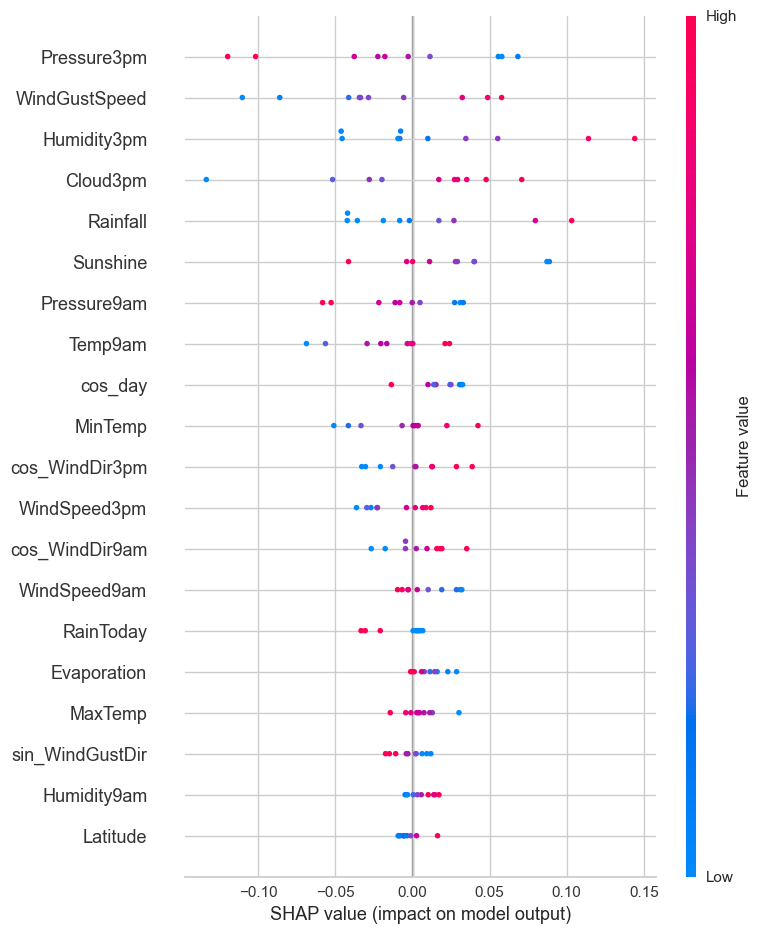

In [170]:
import shap
import pandas as pd

# Configurar muestra de datos
sample_size = 10
X_train_sample = pd.DataFrame(X_train_escaled, columns=X_train_encoded.columns).sample(n=sample_size, random_state=42)

# Crear el fondo utilizando k-means
background_kmeans = shap.kmeans(X_train_escaled, 100)  # Usa 100 clusters como fondo

# Crear una función de predicción que devuelve solo las probabilidades de la clase positiva
def predict_fn(X):
    # final_rnn_rain es tu modelo con los métodos predict y predict_proba definidos
    return final_rnn_rain.predict_proba(X)[:, 1]  # Probabilidad de la clase 1 (positiva)

# Usar KernelExplainer con la función de predicción y el fondo k-means
explainer = shap.KernelExplainer(predict_fn, background_kmeans)

# Calcular los valores SHAP para la muestra de prueba
shap_values = explainer.shap_values(X_train_sample)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_train_sample)

* Humidity3pm es una característica importante que influye en la predicción del modelo, especialmente en el rango de 20 a 50.
* La relación entre Humidity3pm y MinTemp sugiere que estas características pueden estar interrelacionadas y que ambas influyen en la predicción del modelo.

In [201]:
val = final_rnn_rain.predict_proba(X_train_sample[0:1])[:, 1]

explainer = shap.KernelExplainer(
    lambda x: final_rnn_rain.predict_proba(x)[:, 1], 
    shap.kmeans(X_train_escaled, 100)
)

shap_values = explainer.shap_values(X_train_sample)

shap.plots.force(
    explainer.expected_value,  # Valor base esperado para la salida de la clase positiva
    shap_values[0],            # Valores SHAP correspondientes a la muestra
    X_train_sample.iloc[0].values
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 672us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 624us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 629us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 4s 676us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 5s 684us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 5s 721us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 5s 695us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 5s 722us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 5s 696us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6575/6575 ━━━━━━━━━━━━━━━━━━━━ 5s 713us/step


#### Diferencias

* En la complejidad del modelo, las redes neuronales son modelos no lineales que pueden capturar relaciones complejas entre las características y la variable de salida. Esto les permite modelar interacciones más complejas, pero a costa de una mayor complejidad.
* En su interpretabilidad, las redes neuronales son mas complejas de intepretar que las de regresion logistica, ya que las interacciones entre las caracteristicas no son tan evidentes
* En el rendimiento, las redes neuronales son suelen ofrecer un mayor rendimiento en problemas complejos y en grandes conjuntos de datos, cosa que en la regresion logistica no pasa
* En tiempo de entrenamiento, la regresion logistica suele ser mucho mas rapida de entrenar que las redes neuronales, ya que en las redes neuronales, se utilizan arquitecturas profundas o grandes conjuntos de datos.

## Guardamos modelo

In [202]:
import pickle
import sys
import numpy as np

In [ ]:
#final_rnn_rain.model.save("Docker/rnn.h5")

# Punto 8

Para comparar los modelos elegimos la métrica "recall 2 clases" esto se debe a que consideramos que predicir incorrectamente una etiqueta que es "lluvia" como "no lluvia" es mas grave que viceversa -o bien el error en la etiqueta "lluvia" es más importante, pero también es importante no dejar de lado los errores de clasificación en clase no lluvia. 

Por ejemplo, en casos de eventos al aire libre, activades deportivas, recitales, entre otros; sería mayor la consecuencia de predecir que ese día no va a llover y que llueva, a que predecir que ese día va a llover y no llueva. Pero tampoco nos serviría un modelo que prediga que siempre llueve.

Ahora bien, comparando los modelos:

- Regresión Logística: 
    En su mejor versión (es decir, el modelo con datos Oversampleados y optimizado con optuna), el recall para 2 clases en los datos de test da 0.79 aproximado para la clase 1 ("llueve"). Este modelo funciona bien cuando se balancean las clases, de otra manera, no tiene una buena performance. Su costo computacional no fue muy elevado.

- Red Neuronal:
    Con sus parámetros optimizados mediante optuna, obtenemos un recall de 0.81 aproximado con optimización de 20 trials para test. 


Con una diferencia de 0.10 puntos aproximados contra la regresión logística, la  red neuronal tiene el mejor recall para dos clases, aunque un cómputo más elevado que la primera.

In [ ]:
## Modelos comparados

#Optuna Regresion Logistica
best_model_optuna
y_val_pred_optuna = best_model_optuna.predict(X_val_resampled)

#Red Neuronal
final_rnn_rain

In [ ]:
metricas_reg_logistica['Recall 2 clases Train']

Regresion Logistica Weighted                  0.663959
Regresion Logistica Balanced                  0.774419
Regresion Logistica Oversampled               0.775143
Regresión Logística Oversampled optimizada    0.775248
Name: Recall 2 clases Train, dtype: float64

In [ ]:
metricas_reg_logistica['Recall 2 clases Test']

Regresion Logistica Weighted                  0.691300
Regresion Logistica Balanced                  0.698771
Regresion Logistica Oversampled               0.754521
Regresión Logística Oversampled optimizada    0.750905
Name: Recall 2 clases Test, dtype: float64

In [ ]:
metricas_modelos_base['Recall 2 clases Test']


Modelo Base Regresión Lineal       0.386720
Modelo Base Regresión Logistica    0.429062
Modelo Base Moda                   0.300000
Modelo Base Random                 0.491427
Name: Recall 2 clases Test, dtype: float64

In [ ]:
final_rnn_rain.evaluate(X_test_escaled,y_test_encoded)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - custom_recall_metric: 0.8032 - loss: 0.6150
Test recall 2 clases: 0.8238


Como mejor modelo, se observa la red neuronal.

# Plots


In [264]:
y_test_pred_rn = final_rnn_rain.predict(X_test_escaled)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


In [305]:
y_test_pred_probs = final_rnn_rain.predict_proba(X_test_escaled)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


In [307]:
y_test_pred_probs[:,1]

array([0.5038768 , 0.48088115, 0.46212798, ..., 0.39457154, 0.3715613 ,
       0.38337517], dtype=float32)

In [308]:
# Asegurándote de que ambos valores sean unidimensionales
date_pred = [df['Date'].loc[X_test.index].values, y_test_pred_rn.flatten(), y_test_pred_probs[:,1]]

# Crear el DataFrame
date_pred_df = pd.DataFrame({
    'Date': date_pred[0],  # Las fechas
    'Pred': date_pred[1], 
    'Prob': date_pred[2]   # Las predicciones
})


## Lluvias predichas en conjunto test

In [316]:
pd.to_datetime(date_pred_df['Date'][952])

Timestamp('2017-04-08 00:00:00')

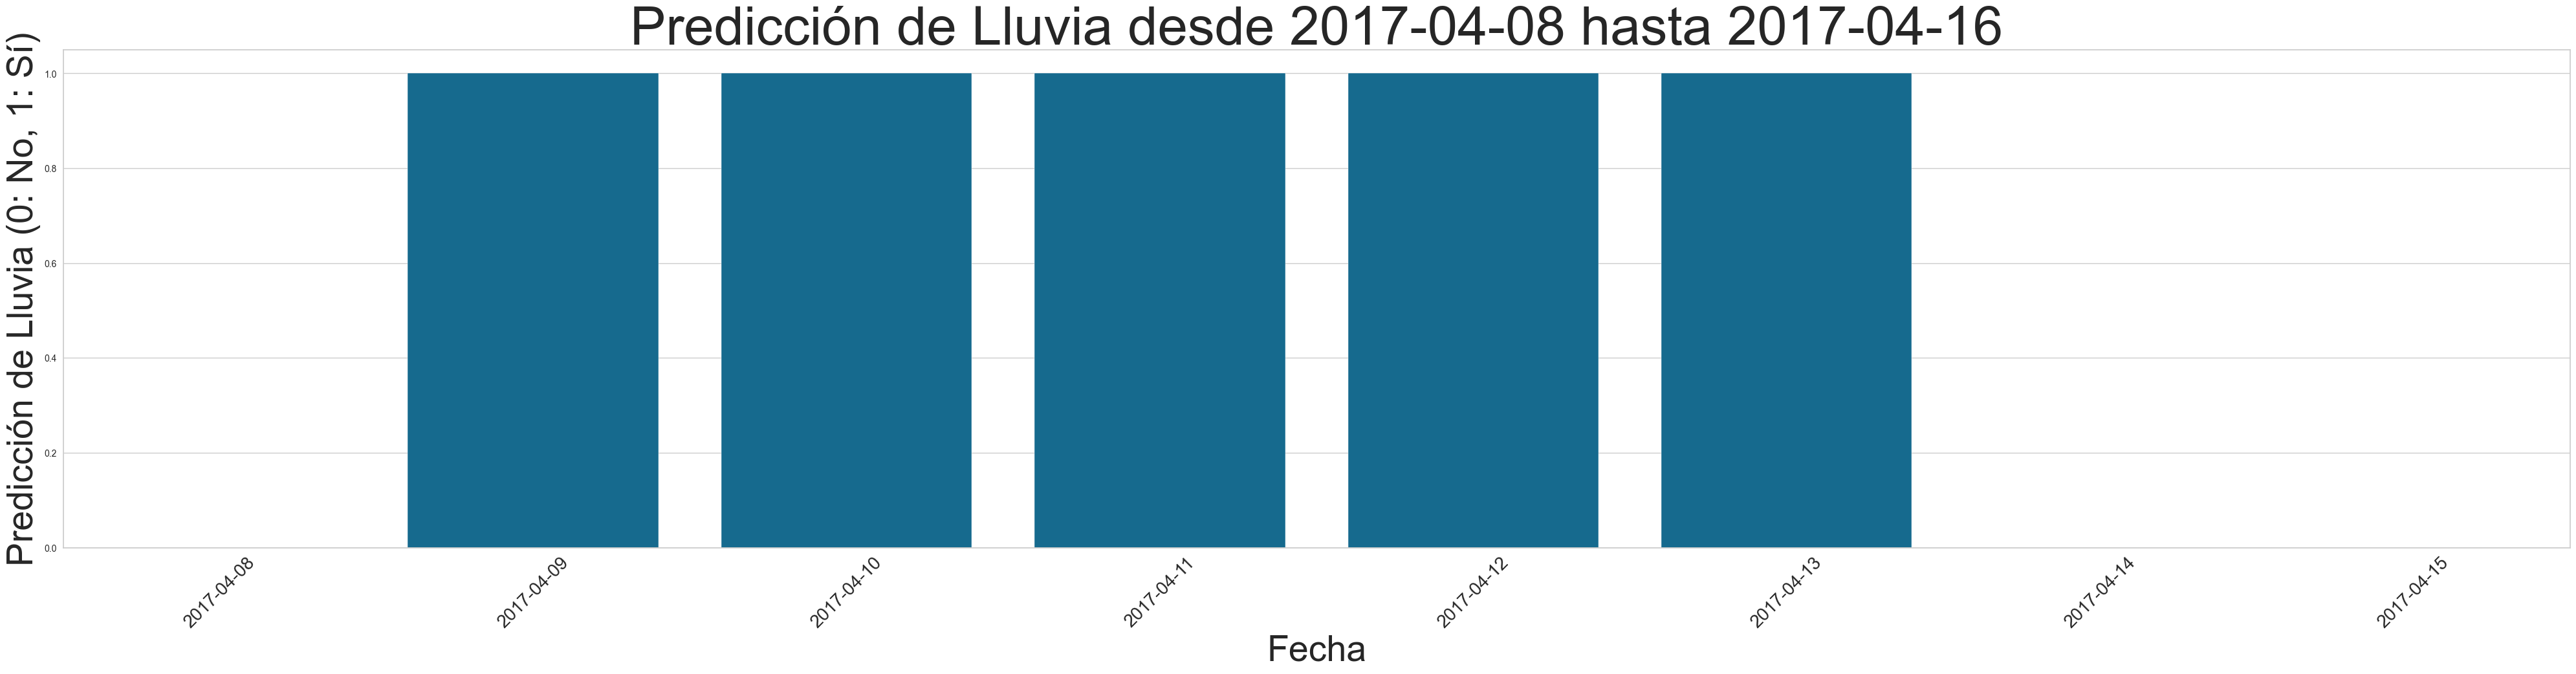

In [322]:
# Crear el gráfico de barras
plt.figure(figsize=(50, 10))
sns.barplot(x=date_pred_df['Date'][952:960], y=date_pred_df['Pred'][952:960])
# Personalizar el gráfico
plt.title(f'Predicción de Lluvia desde {date_pred_df["Date"][952].strftime("%Y-%m-%d")} hasta {date_pred_df["Date"][960].strftime("%Y-%m-%d")}', fontsize=60)
plt.xlabel('Fecha',fontsize= 40)
plt.ylabel('Predicción de Lluvia (0: No, 1: Sí)', fontsize= 40)
plt.xticks(rotation=45, fontsize= 20)   # Rotar las fechas para mejor visibilidad

# Mostrar el gráfico
plt.show()


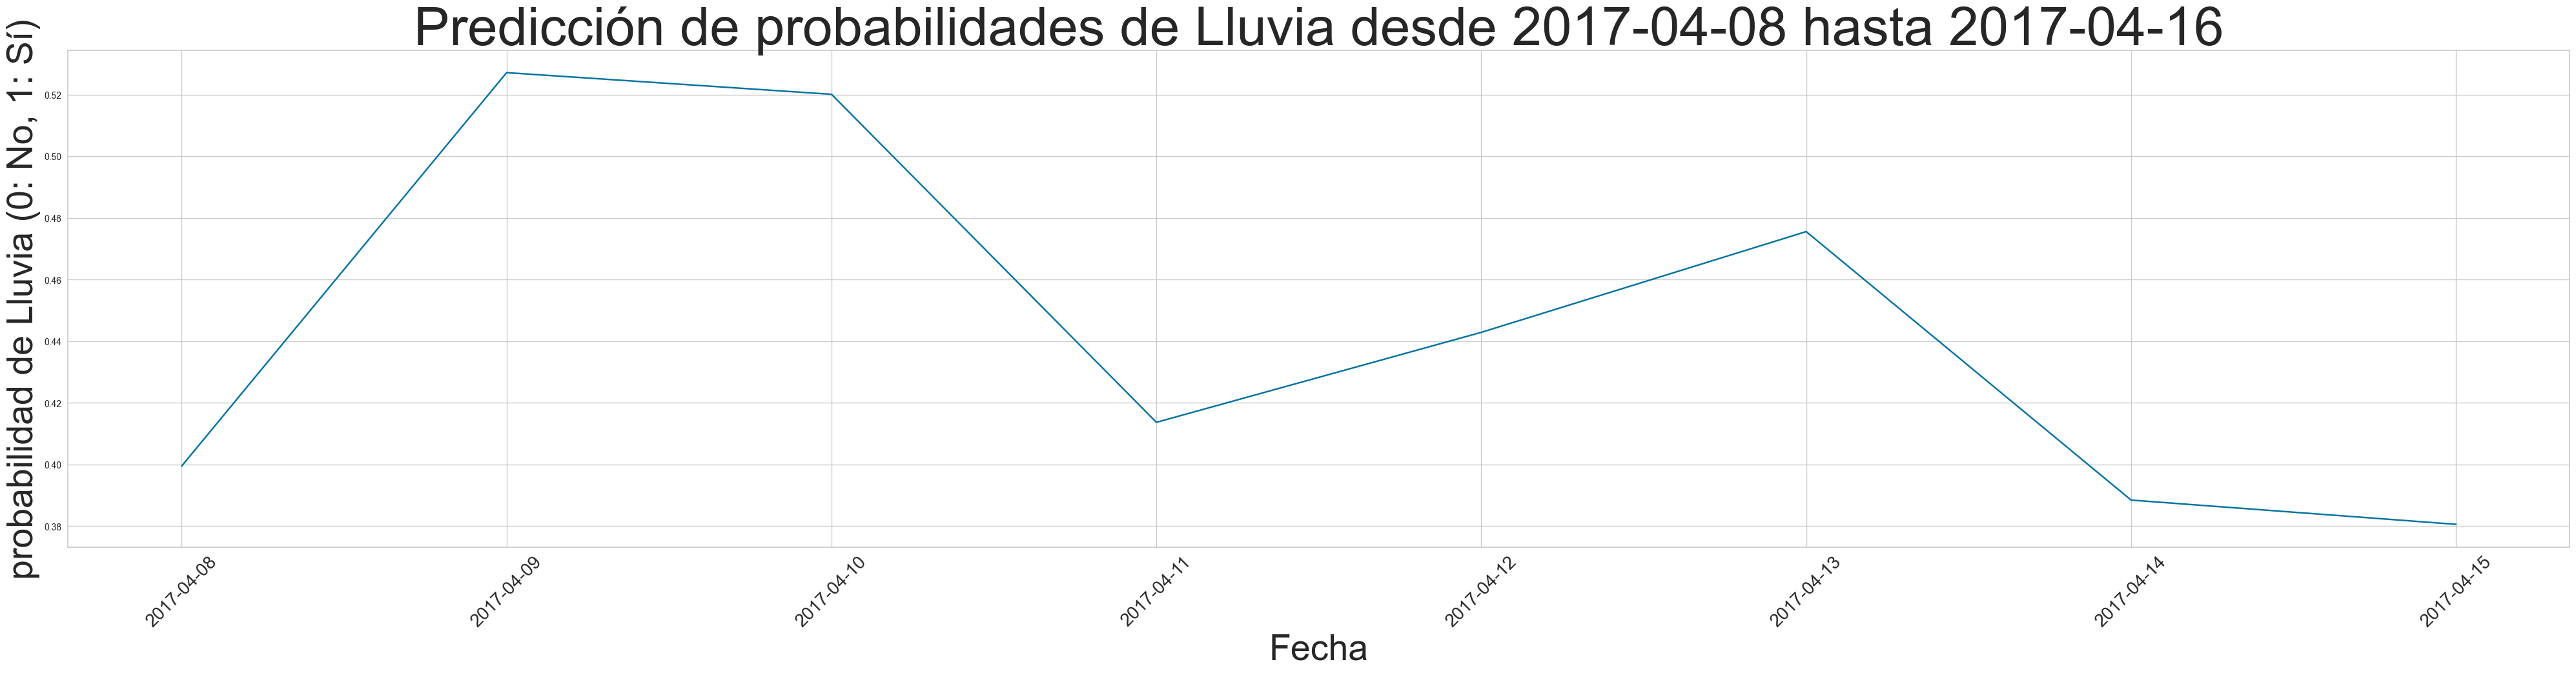

In [323]:
# Crear el gráfico de barras
plt.figure(figsize=(50, 10))
sns.lineplot(x=date_pred_df['Date'][952:960], y=date_pred_df['Prob'][952:960])
# Personalizar el gráfico
plt.title(f'Predicción de probabilidades de Lluvia desde {date_pred_df["Date"][952].strftime("%Y-%m-%d")} hasta {date_pred_df["Date"][960].strftime("%Y-%m-%d")}', fontsize=60)
plt.xlabel('Fecha',fontsize= 40)
plt.ylabel('probabilidad de Lluvia (0: No, 1: Sí)', fontsize= 40)
plt.xticks(rotation=45, fontsize= 20)   # Rotar las fechas para mejor visibilidad

# Mostrar el gráfico
plt.show()

# Conclusión

A lo largo de este trabajo práctico teniamos como objetivo la predecir la condición de lluvia al día siguiente en diferentes ciudades de Australia, utilizando el dataset weatherAUS.csv. A lo largo de las distintas fases del análisis y modelado, se tomamos varias decisiones que se ven reflejadas en los resultados obtenidos.

Comenzamos con el preprocesamiento de los datos haciendo un análisis descriptivo de cada una de las variables involucradas, lo que nos permitió entender como se comporta, rango de variación y la necesidad de realizar imputación de valores faltantes. Implementamos estrategias para manejar los datos faltantes y se realizamos visualizaciones para una mejor comprensión del comportamiento de las variables. Para las variables categóricas fue necesaria la codificación para usarlas en los modelos de predicción. Para la codificacíon usamos distintos codificadores como las coordenadas polares sin-cos para los dias, dirección del viento y para cada ciudad.

Durante el análisis del dataset pudimos ver que estaba desbalanceado, con más casos de "No" lluvia que de "Sí" lluvia. Para abordar este problema, utilizamos distintas técnicas como la de darle pesos a la clase desbalanceada o SMOTE (sobre-muestreo() para balancear las clases y mejorar la capacidad del modelo para predecir correctamente los días de lluvia.

Luego implementamos un modelo de regresión logística, entrenado con diferentes configuraciones y optimizado finalmente con Optuna al ser la más eficiente y devolviendonos el mejor rendimiento posible. Además, realizamos validación cruzada y evaluamos el rendimiento de los modelos utilizando métricas clave como recall, precisión, F1-score, y la curva ROC. De forma particular, nos enfocamos en la métrica recall, ya que nuestro objetivo principal era maximizarla para nuestra función recall_2_clases para obtener una evaluación balanceada de ambas clases, ponderando más la clase positiva.

También implementamos un modelo de **red neuronal** con TensorFlow, lo que nos permitió comparar su rendimiento con el modelo de regresión logística. Si bien la regresión logística mostró un buen desempeño, las redes neuronales ofrecen mejores redimientos, ya que esta usa más de un solo modelo de regresión para la prediccion. No obstante,para esta tambien tuvimos ajustes en sus hiperparámetros para alcanzar el mejor rendimiento posible.

Implementamos técnicas de explicabilidad usando SHAP para interpretar los resultados del modelo y visualizar las variables más importantes. Esto nos permitió entender mejor qué características meteorológicas influyen más en la predicción de la lluvia.

Finalmente, empaquetamos al modelo utilizando Docker para su puesta en producción. El contenedor incluye todos los componentes necesarios para hacer inferencias, como el modelo entrenado, los scalers y los imputers.

En conclusión, hemos logrado desarrollar un modelo de clasificación robusto para la predicción de la lluvia, optimizado mediante el uso de regresión logística, redes neuronales y técnicas de optimización de hiperparámetros. El trabajo también destaca la importancia del balanceo de clases y la interpretabilidad del modelo para asegurar que las predicciones sean tanto precisas como comprensibles.